<a href="https://colab.research.google.com/github/camrivera8/UM_ECoG_Multiclass_Open_Loop/blob/main/1_ECoG_Multiclass_Sorting_Master.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Overview**:
- This project's goal is to process EEG into epochs
- EEG data exists in .edf files
- Epochs exist in .tsv sheets
- -> We want to separate eeg by task for further analysis
- This sheet is step 1 of a larger pipeline to analyze these bins

**Instructions**:

1) load the pacakges

2) can run skip the EEG import, next section runs the saved pickle

3) can skip the fourier transform/power calculations, next section loads the .csv

**End goal of data handling**

Dictionary with in dictionary

{ses-###-run-###: {notes:"", trial_type_list:[ ], onset_list:[ ], raw_EEG_data: , data_mod: [trial_type, EEG_data]}
,...}

**Steps of Code w/ Associated Lines**:
1) Import package to access google drive
2) Import OS, Data Handling, EEG, and Analysis Packages
3) Import set main directory


To-Do:

- Write code to compile notes

- task_epochs -> include all sessions not just

- pre-processing:

- some sessions have 7 runs must alter code to accomodate

read the supplemental again

edit band bins to include the extra bands in the loops

take out the first packet?

any other pre-processing from supp.?

outliers: any epochs with PSD outside x st.d.?

industry standard for number/overlap?

#Load Packages

generic

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#%% ** Startup Packages **
# OS library
import os
import sys
import argparse
import pickle


# Basics
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import csv
import time


# EEG
from scipy import signal

# Analysis
from scipy import stats
from statistics import mean
!pip install statannot
from statannot import add_stat_annotation
from scipy.stats import f_oneway
from sklearn.utils import resample

# Machine Learning
from sklearn import datasets
from sklearn import metrics
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import RocCurveDisplay
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import label_binarize
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler, FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

#ANN specifically
import keras
from keras.wrappers.scikit_learn import KerasClassifier
from keras.utils import np_utils
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import tensorflow as tf
from numpy import loadtxt
from keras.models import Sequential
from keras.layers import Dense

from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adadelta, Adagrad


from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import classification_report, roc_curve, roc_auc_score
import statsmodels.api as sm
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import validation_curve

# Set directory
main_directory = '/content/drive/Shareddrives/ECoG_Multi-Class/'

# Set the current working directory to the script directory
os.chdir(main_directory)

sample_rate_200 = [0,2]
sample_rate_5 = [1,3]

eeg-specific

In [3]:
!pip install pyedflib
import pyedflib
from pyedflib import *
import glob
import json

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 14.2 MB/s eta 0:00:00


#Import EEG

##Organize EEG data

In [ ]:

main_directory = '/content/drive/Shareddrives/ECoG_Multi-Class/'
subject_id = 'sub-001'

master = {}
# task_epochs_master = []

# Main Loop - Loop over session folders
for session_folder in os.listdir(os.path.join(main_directory, subject_id)):

    # Make sure only looping through session folders
    if not session_folder.startswith('ses-'):
        continue

    # Directory pathway for session associated with current loop
    session_path = os.path.join(main_directory, subject_id, session_folder)
    session = session_path.split('/')[-1]

    # Sub Loop - Loop over folders associated with in current session folder
    for run_folder in os.listdir(os.path.join(session_path, 'ieeg')):

      # extract notes
      notes = []
      null_trial = []
      if run_folder.endswith('_notes.json'):
        notes_file = os.path.join(session_path, 'ieeg', run_folder)
        text_notes = json.load(open(notes_file))


        # if notes exist
        if len(text_notes) != 0:

          for note in text_notes:
            master[session + '-' + note] = text_notes[note]

        # to get True/False for null trial - master['ses-###-run-###']['null trial']
        # to get notes - master['ses-###-run-###']['notes']

########## Check if .edf is associated with ses-###-run-001 and edf data to master list under key session + 'run-001'

# Main Loop - Loop over session folders
for session_folder in os.listdir(os.path.join(main_directory, subject_id)):

    # Make sure only looping through session folders
    if not session_folder.startswith('ses-'):
        continue

    # Directory pathway for session associated with current loop
    session_path = os.path.join(main_directory, subject_id, session_folder)
    session = session_path.split('/')[-1]

    # Sub Loop - Loop over folders associated with in current session folder
    for run_folder in os.listdir(os.path.join(session_path, 'ieeg')):

      if run_folder.endswith('_ieeg.edf'):
        run_path = os.path.join(session_path, 'ieeg', run_folder)
        # Load the .edf file
        edf_file = pyedflib.EdfReader(run_path) #os.path.join(run_path, '{}.edf'.format(run_folder)))
        n_channels = edf_file.signals_in_file
        sample_rate_individual = edf_file.getSampleFrequencies()
        sampling_rate = np.mean(edf_file.getSampleFrequencies())
        duration_sec = edf_file.file_duration
        eeg_data = []

        parts = run_path.split("/")

        # Extract "ses-###" and "run-###" from the relevant parts
        ses = parts[8].split("_")[-4]
        run = parts[8].split("_")[-2]

        for channel in range(n_channels):
          channel_data = edf_file.readSignal(channel)
          master[ses + '-' + run]['Channel-' + str(channel)] = channel_data
          # print('Channel - ' + str(channel))
          # print('Channel data - ' + str(channel_data))
          eeg_data = pd.conccat([eeg_data, channel_data])
        edf_file.close()

######### Get onset and trial_type data from runs ###############################

# Main Loop - Loop over session folders
for session_folder in os.listdir(os.path.join(main_directory, subject_id)):

    # Make sure only looping through session folders
    if not session_folder.startswith('ses-'):
        continue

    # Directory pathway for session associated with current loop
    session_path = os.path.join(main_directory, subject_id, session_folder)
    session = session_path.split('/')[-1]

    # Sub Loop - Loop over folders associated with in current session folder
    for run_folder in os.listdir(os.path.join(session_path, 'ieeg')):

      if run_folder.endswith('events.tsv'):
        run_path = os.path.join(session_path, 'ieeg', run_folder)
        # print(run_path)

        parts = run_path.split("/")

        # Extract "ses-###" and "run-###" from the relevant parts
        ses = parts[8].split("_")[-4]
        run = parts[8].split("_")[-2]

        onset = []  # To store data from column A
        duration = [] # To store data from column B
        trial_type = []  # To store data from column C

        with open(run_path, 'rb') as file:
            reader = pd.read_csv(file, delimiter='\t')  # Use '\t' as the delimiter for TSV files
            for column in reader:
              master[ses + '-' + run]['onset'] = reader['onset'].values
              master[ses + '-' + run]['duration'] = reader['duration'].values
              master[ses + '-' + run]['trial type'] = reader['trial_type'].values

####### Loop through dictionary and remove runs with master['ses-###-run-###']['notes']['null trial'] == 'False'

keys_to_remove = []
for key in master:
  if 'True' in str(master[key]['null trial']):
    keys_to_remove = pd.concat([keys_to_remove, key])

for key in keys_to_remove:
    del master[key]

####### Extract the channel data based on each task #######################################

# Trial Type = [[Channel 0: [], Channel 1: [], Channel 2: [], Channel 3: []], ...]

Right_Epoch = []
Left_Epoch = []
Both_Epoch = []
Rest_Epoch = []
None_Epoch = []

for key in master:
  for i in range(len(master[key]['onset'])):

    if 'Right' in master[key]['trial type'][i]:
      Channel_0 = master[key]['Channel-0'][int(master[key]['onset'][i]*200):int(master[key]['onset'][i]*200+master[key]['duration'][i]*200)]
      Channel_1 = master[key]['Channel-1'][int(master[key]['onset'][i]*5):int(master[key]['onset'][i]*5+master[key]['duration'][i]*5)]
      Channel_2 = master[key]['Channel-2'][int(master[key]['onset'][i]*200):int(master[key]['onset'][i]*200+master[key]['duration'][i]*200)]
      Channel_3 = master[key]['Channel-3'][int(master[key]['onset'][i]*5):int(master[key]['onset'][i]*5+master[key]['duration'][i]*5)]
      Right_Epoch = Right_Epoch + [[Channel_0, Channel_1, Channel_2, Channel_3]]
      # print(master[key]['Channel-0'][int(master[key]['onset'][i]*200):int(master[key]['onset'][i]*200+master[key]['duration'][i]*200)])

    if 'Left' in master[key]['trial type'][i]:
      Channel_0 = master[key]['Channel-0'][int(master[key]['onset'][i]*200):int(master[key]['onset'][i]*200+master[key]['duration'][i]*200)]
      Channel_1 = master[key]['Channel-1'][int(master[key]['onset'][i]*5):int(master[key]['onset'][i]*5+master[key]['duration'][i]*5)]
      Channel_2 = master[key]['Channel-2'][int(master[key]['onset'][i]*200):int(master[key]['onset'][i]*200+master[key]['duration'][i]*200)]
      Channel_3 = master[key]['Channel-3'][int(master[key]['onset'][i]*5):int(master[key]['onset'][i]*5+master[key]['duration'][i]*5)]
      Left_Epoch = Left_Epoch + [[Channel_0, Channel_1, Channel_2, Channel_3]]

    if 'Both' in master[key]['trial type'][i]:
      Channel_0 = master[key]['Channel-0'][int(master[key]['onset'][i]*200):int(master[key]['onset'][i]*200+master[key]['duration'][i]*200)]
      Channel_1 = master[key]['Channel-1'][int(master[key]['onset'][i]*5):int(master[key]['onset'][i]*5+master[key]['duration'][i]*5)]
      Channel_2 = master[key]['Channel-2'][int(master[key]['onset'][i]*200):int(master[key]['onset'][i]*200+master[key]['duration'][i]*200)]
      Channel_3 = master[key]['Channel-3'][int(master[key]['onset'][i]*5):int(master[key]['onset'][i]*5+master[key]['duration'][i]*5)]
      Both_Epoch = Both_Epoch + [[Channel_0, Channel_1, Channel_2, Channel_3]]

    if 'Rest' in master[key]['trial type'][i]:
      Channel_0 = master[key]['Channel-0'][int(master[key]['onset'][i]*200):int(master[key]['onset'][i]*200+master[key]['duration'][i]*200)]
      Channel_1 = master[key]['Channel-1'][int(master[key]['onset'][i]*5):int(master[key]['onset'][i]*5+master[key]['duration'][i]*5)]
      Channel_2 = master[key]['Channel-2'][int(master[key]['onset'][i]*200):int(master[key]['onset'][i]*200+master[key]['duration'][i]*200)]
      Channel_3 = master[key]['Channel-3'][int(master[key]['onset'][i]*5):int(master[key]['onset'][i]*5+master[key]['duration'][i]*5)]
      Rest_Epoch = Rest_Epoch + [[Channel_0, Channel_1, Channel_2, Channel_3]]

    if 'None' in master[key]['trial type'][i]:
      Channel_0 = master[key]['Channel-0'][int(master[key]['onset'][i]*200):int(master[key]['onset'][i]*200+master[key]['duration'][i]*200)]
      Channel_1 = master[key]['Channel-1'][int(master[key]['onset'][i]*5):int(master[key]['onset'][i]*5+master[key]['duration'][i]*5)]
      Channel_2 = master[key]['Channel-2'][int(master[key]['onset'][i]*200):int(master[key]['onset'][i]*200+master[key]['duration'][i]*200)]
      Channel_3 = master[key]['Channel-3'][int(master[key]['onset'][i]*5):int(master[key]['onset'][i]*5+master[key]['duration'][i]*5)]
      None_Epoch = None_Epoch + [[Channel_0, Channel_1, Channel_2, Channel_3]]

################ Save the variable to a file ######################################################

# [Trial Type, Channel-0, Channel-1, Channel-2, Channel-3]
task_epochs = []

for trial in Right_Epoch:
  task_epochs = task_epochs + [['Right'] + trial]

for trial in Left_Epoch:
  task_epochs = task_epochs + [['Left'] + trial]

for trial in Both_Epoch:
  task_epochs = task_epochs + [['Both'] + trial]

for trial in Rest_Epoch:
  task_epochs = task_epochs + [['Rest'] + trial]

for trial in None_Epoch:
  task_epochs = task_epochs + [['None'] + trial]

# print(task_epochs[0])

with open("task_epochs.pkl", "wb") as f:
    pickle.dump(task_epochs, f)

In [ ]:
# Get the data and trial type for the first epoch

# Create a figure with subplots for each channel
fig, axs = plt.subplots(nrows=4, sharex=True, sharey=False)

trial_number = 2500

#plot the data (x,y)
axs[0].plot(np.arange(len(task_epochs[trial_number][1])) / 200, task_epochs[trial_number][1])
axs[0].set_ylabel("Channel 1")

axs[1].plot(np.arange(len(task_epochs[trial_number][2])) / 5, task_epochs[trial_number][2])
axs[1].set_ylabel("Channel 2")

axs[2].plot(np.arange(len(task_epochs[trial_number][3])) / 200, task_epochs[trial_number][3])
axs[2].set_ylabel("Channel 3")

axs[3].plot(np.arange(len(task_epochs[trial_number][4])) / 5, task_epochs[trial_number][4])
axs[3].set_ylabel("Channel 4")
axs[3].set_xlabel("Seconds")

# Add a title with the trial type
fig.suptitle("EEG Data for Trial type: {}".format(task_epochs[trial_number][0]))

plt.show()



##Hyperparamets Log & Window

looking at task_epochs_lag0_windowed08:

-- the first entry is a list of 5 items

-- 0 = trial type, 1-4 are strings of numbers

-- 1-4 are all the same length even though channels 1 & 3 should be shorter. i.e. all are len=33 instead of longer.

In [5]:
######## Hyper Parameterization based on lag #########################################################
import copy

# Lags: 0.0, 0.4, 0.8 based on binary paper

Lags = [0.0, 0.4, 0.8]

# print(len(task_epochs))
# print(len(task_epochs[0][1]))
# print(len(task_epochs[0][2]))

task_epochs_lag0 = []
task_epochs_lag04 = []
task_epochs_lag08 = []

task_epochs_lag0 = copy.deepcopy(task_epochs)
for i in range(0,len(task_epochs_lag0)):

  task_epochs_lag0 = task_epochs_lag0 + list([task_epochs_lag0[i]])
  '''
  Wouldn't "lag 0" just be a copy of the original "task_epochs"?
  Seems to be that this loop just doubles the existing entreis
  -Cam 7/31/23
  '''

task_epochs_lag04 = copy.deepcopy(task_epochs)
for i in range(0,len(task_epochs_lag04)):
  task_epochs_lag04[i][1] = task_epochs_lag04[i][1][int(200*Lags[1]):]
  task_epochs_lag04[i][2] = task_epochs_lag04[i][2][int(5*Lags[1]):]
  task_epochs_lag04[i][3] = task_epochs_lag04[i][3][int(200*Lags[1]):]
  task_epochs_lag04[i][4] = task_epochs_lag04[i][4][int(5*Lags[1]):]

task_epochs_lag08 = copy.deepcopy(task_epochs)
for i in range(0,len(task_epochs_lag08)):
  task_epochs_lag08[i][1] = task_epochs_lag08[i][1][int(200*Lags[2]):]
  task_epochs_lag08[i][2] = task_epochs_lag08[i][2][int(5*Lags[2]):]
  task_epochs_lag08[i][3] = task_epochs_lag08[i][3][int(200*Lags[2]):]
  task_epochs_lag08[i][4] = task_epochs_lag08[i][4][int(5*Lags[2]):]

######## Hyper Paremeterization based on window size lag 0 #################################################
# Window: size 0.8, 1.2, 1.6, 2.0, 2.4, 2.8, 3.2

# get the first 160 indices move 40 forward get the next 160 indices and so on until trial complete for each of the 4 channels
def split_list_with_overlap(lst, window_size, step_size):
    return [lst[i:i+window_size] for i in range(0, len(lst)-window_size+1, step_size)]

##### Hyperparameterization based on 0.8 Window Size for first line on task_epochs_lag0
task_epoch_lag0_windowed08 = []

for i in range(0,len(task_epochs_lag0)):

  # Loops through task epochs lag0
  task_epoch_lag0_windowed08_individual = []

  my_list = task_epochs_lag0[i][1]
  window_size = 160
  step_size = 40
  result1 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag0[i][2]
  window_size = 4
  step_size = 1
  result2 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag0[i][3]
  window_size = 160
  step_size = 40
  result3 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag0[i][4]
  window_size = 4
  step_size = 1
  result4 = split_list_with_overlap(my_list, window_size, step_size)

  task_epoch_lag0_windowed08_individual = [task_epochs_lag0[i][0], result1, result2, result3, result4]
  task_epoch_lag0_windowed08 = task_epoch_lag0_windowed08 + [task_epoch_lag0_windowed08_individual]

# Check to determine if first 160 positions match
if sorted(task_epoch_lag0_windowed08[0][1][0]) == sorted(task_epoch_lag0_windowed08[0][1][0][:160]):
  print('Succcess window 0.8 first')

# Check to determine if last 160 positions match
if sorted(task_epoch_lag0_windowed08[0][1][-1]) == sorted(task_epoch_lag0_windowed08[0][1][-1]):
  print('Succcess window 0.8 last')

##### Hyperparameterization based on 1.2 Window Size for lag0
task_epoch_lag0_windowed12 = []

for i in range(0,len(task_epochs_lag0)):

  # Loops through task epochs lag0
  task_epoch_lag0_windowed12_individual = []

  my_list = task_epochs_lag0[i][1]
  window_size = 240
  step_size = 40
  result1 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag0[i][2]
  window_size = 6
  step_size = 1
  result2 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag0[i][3]
  window_size = 240
  step_size = 40
  result3 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag0[i][4]
  window_size = 6
  step_size = 1
  result4 = split_list_with_overlap(my_list, window_size, step_size)

  task_epoch_lag0_windowed12_individual = [task_epochs_lag0[i][0], result1, result2, result3, result4]
  task_epoch_lag0_windowed12 = task_epoch_lag0_windowed12 + [task_epoch_lag0_windowed12_individual]

# Check to determine if first 160 positions match
if sorted(task_epoch_lag0_windowed08[0][1][0]) == sorted(task_epoch_lag0_windowed12[0][1][0][:160]):
  print('Succcess window 1.2 first')

# Check to determine if last 160 positions match
if sorted(task_epoch_lag0_windowed08[0][1][-1]) == sorted(task_epoch_lag0_windowed12[0][1][-1][80:240]):
  print('Succcess window 1.2 last')

# Hyperparameterization based on 1.6 Window Size #####
task_epoch_lag0_windowed16 = []

for i in range(0,len(task_epochs_lag0)):

  # Loops through task epochs lag0
  task_epoch_lag0_windowed16_individual = []

  my_list = task_epochs_lag0[i][1]
  window_size = 320
  step_size = 40
  result1 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag0[i][2]
  window_size = 8
  step_size = 1
  result2 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag0[i][3]
  window_size = 320
  step_size = 40
  result3 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag0[i][4]
  window_size = 8
  step_size = 1
  result4 = split_list_with_overlap(my_list, window_size, step_size)

  task_epoch_lag0_windowed16_individual = [task_epochs_lag0[i][0], result1, result2, result3, result4]
  task_epoch_lag0_windowed16 = task_epoch_lag0_windowed16 + [task_epoch_lag0_windowed16_individual]

# Check to determine if first 160 positions match
if sorted(task_epoch_lag0_windowed08[0][1][0]) == sorted(task_epoch_lag0_windowed16[0][1][0][:160]):
  print('Succcess window 1.6 first')

# Check to determine if last 160 positions match
if sorted(task_epoch_lag0_windowed08[0][1][-1]) == sorted(task_epoch_lag0_windowed16[0][1][-1][160:320]):
  print('Succcess window 1.6 last')

# Hyperparameterization based on 2.0 Window Size

task_epoch_lag0_windowed20 = []

for i in range(0,len(task_epochs_lag0)):

  # Loops through task epochs lag0
  task_epoch_lag0_windowed20_individual = []

  my_list = task_epochs_lag0[i][1]
  window_size = 400
  step_size = 40
  result1 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag0[i][2]
  window_size = 10
  step_size = 1
  result2 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag0[i][3]
  window_size = 400
  step_size = 40
  result3 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag0[i][4]
  window_size = 10
  step_size = 1
  result4 = split_list_with_overlap(my_list, window_size, step_size)

  task_epoch_lag0_windowed20_individual = [task_epochs_lag0[i][0], result1, result2, result3, result4]
  task_epoch_lag0_windowed20 = task_epoch_lag0_windowed20 + [task_epoch_lag0_windowed20_individual]

# Check to determine if first 160 positions match
if sorted(task_epoch_lag0_windowed08[0][1][0]) == sorted(task_epoch_lag0_windowed20[0][1][0][:160]):
  print('Succcess window 2.0 first')

# Check to determine if last 160 positions match
if sorted(task_epoch_lag0_windowed08[0][1][-1]) == sorted(task_epoch_lag0_windowed20[0][1][-1][240:400]):
  print('Succcess window 2.0 last')

# Hyperparameterization based on 2.4 Window Size

task_epoch_lag0_windowed24 = []

for i in range(0,len(task_epochs_lag0)):

  # Loops through task epochs lag0
  task_epoch_lag0_windowed24_individual = []

  my_list = task_epochs_lag0[i][1]
  window_size = 480
  step_size = 40
  result1 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag0[i][2]
  window_size = 12
  step_size = 1
  result2 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag0[i][3]
  window_size = 480
  step_size = 40
  result3 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag0[i][4]
  window_size = 12
  step_size = 1
  result4 = split_list_with_overlap(my_list, window_size, step_size)

  task_epoch_lag0_windowed24_individual = [task_epochs_lag0[i][0], result1, result2, result3, result4]
  task_epoch_lag0_windowed24 = task_epoch_lag0_windowed24 + [task_epoch_lag0_windowed24_individual]

# Check to determine if first 160 positions match
if sorted(task_epoch_lag0_windowed08[0][1][0]) == sorted(task_epoch_lag0_windowed24[0][1][0][:160]):
  print('Succcess window 2.4 first')

# Check to determine if last 160 positions match
if sorted(task_epoch_lag0_windowed08[0][1][-1]) == sorted(task_epoch_lag0_windowed24[0][1][-1][320:480]):
  print('Succcess window 2.4 last')

# Hyperparameterization based on 2.8 Window Size

task_epoch_lag0_windowed28 = []

for i in range(0,len(task_epochs_lag0)):

  # Loops through task epochs lag0
  task_epoch_lag0_windowed28_individual = []

  my_list = task_epochs_lag0[i][1]
  window_size = 560
  step_size = 40
  result1 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag0[i][2]
  window_size = 14
  step_size = 1
  result2 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag0[i][3]
  window_size = 560
  step_size = 40
  result3 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag0[i][4]
  window_size = 14
  step_size = 1
  result4 = split_list_with_overlap(my_list, window_size, step_size)

  task_epoch_lag0_windowed28_individual = [task_epochs_lag0[i][0], result1, result2, result3, result4]
  task_epoch_lag0_windowed28 = task_epoch_lag0_windowed28 + [task_epoch_lag0_windowed28_individual]

# Check to determine if first 160 positions match
if sorted(task_epoch_lag0_windowed08[0][1][0]) == sorted(task_epoch_lag0_windowed28[0][1][0][:160]):
  print('Succcess window 2.8 first')

# Check to determine if last 160 positions match
if sorted(task_epoch_lag0_windowed08[0][1][-1]) == sorted(task_epoch_lag0_windowed28[0][1][-1][400:560]):
  print('Succcess window 2.8 last')

# Hyperparameterization based on 3.2 Window Size

task_epoch_lag0_windowed32 = []

for i in range(0,len(task_epochs_lag0)):

  # Loops through task epochs lag0
  task_epoch_lag0_windowed32_individual = []

  my_list = task_epochs_lag0[i][1]
  window_size = 640
  step_size = 40
  result1 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag0[i][2]
  window_size = 16
  step_size = 1
  result2 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag0[i][3]
  window_size = 640
  step_size = 40
  result3 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag0[i][4]
  window_size = 16
  step_size = 1
  result4 = split_list_with_overlap(my_list, window_size, step_size)

  task_epoch_lag0_windowed32_individual = [task_epochs_lag0[i][0], result1, result2, result3, result4]
  task_epoch_lag0_windowed32 = task_epoch_lag0_windowed32 + [task_epoch_lag0_windowed32_individual]

# Check to determine if first 160 positions match
if sorted(task_epoch_lag0_windowed08[0][1][0]) == sorted(task_epoch_lag0_windowed32[0][1][0][:160]):
  print('Succcess window 3.2 first')

# Check to determine if last 160 positions match
if sorted(task_epoch_lag0_windowed08[0][1][-1]) == sorted(task_epoch_lag0_windowed32[0][1][-1][480:640]):
  print('Succcess window 3.2 last')

######## Hyper Paremeterization based on window size lag 0.4 #################################################
# Window: size 0.8, 1.2, 1.6, 2.0, 2.4, 2.8, 3.2

# get the first 160 indices move 40 forward get the next 160 indices and so on until trial complete for each of the 4 channels
def split_list_with_overlap(lst, window_size, step_size):
    return [lst[i:i+window_size] for i in range(0, len(lst)-window_size+1, step_size)]

##### Hyperparameterization based on 0.8 Window Size for first line on task_epochs_lag0
task_epoch_lag04_windowed08 = []

for i in range(0,len(task_epochs_lag04)):

  # Loops through task epochs lag0
  task_epoch_lag04_windowed08_individual = []

  my_list = task_epochs_lag04[i][1]
  window_size = 160
  step_size = 40
  result1 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag04[i][2]
  window_size = 4
  step_size = 1
  result2 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag04[i][3]
  window_size = 160
  step_size = 40
  result3 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag04[i][4]
  window_size = 4
  step_size = 1
  result4 = split_list_with_overlap(my_list, window_size, step_size)

  task_epoch_lag04_windowed08_individual = [task_epochs_lag04[i][0], result1, result2, result3, result4]
  task_epoch_lag04_windowed08 = task_epoch_lag04_windowed08 + [task_epoch_lag04_windowed08_individual]

# Check to determine if first 160 positions match
if sorted(task_epoch_lag04_windowed08[0][1][0]) == sorted(task_epoch_lag04_windowed08[0][1][0][:160]):
  print('Succcess lag 0.4 window 0.8 first')

# Check to determine if last 160 positions match
if sorted(task_epoch_lag04_windowed08[0][1][-1]) == sorted(task_epoch_lag04_windowed08[0][1][-1]):
  print('Succcess lag 0.4 window 0.8 last')

# Check to determine if first 160 positions match that of same window without lag
if sorted(task_epoch_lag04_windowed08[0][1][0]) != sorted(task_epoch_lag0_windowed08[0][1][0]):
  print('success lag 0.4 window 0.8 last does NOT equal lag 0.0')

##### Hyperparameterization based on 1.2 Window Size for lag0.4
task_epoch_lag04_windowed12 = []

for i in range(0,len(task_epochs_lag04)):

  # Loops through task epochs lag0
  task_epoch_lag04_windowed12_individual = []

  my_list = task_epochs_lag04[i][1]
  window_size = 240
  step_size = 40
  result1 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag04[i][2]
  window_size = 6
  step_size = 1
  result2 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag04[i][3]
  window_size = 240
  step_size = 40
  result3 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag04[i][4]
  window_size = 6
  step_size = 1
  result4 = split_list_with_overlap(my_list, window_size, step_size)

  task_epoch_lag04_windowed12_individual = [task_epochs_lag04[i][0], result1, result2, result3, result4]
  task_epoch_lag04_windowed12 = task_epoch_lag04_windowed12 + [task_epoch_lag04_windowed12_individual]

# Check to determine if first 160 positions match
if sorted(task_epoch_lag04_windowed08[0][1][0]) == sorted(task_epoch_lag04_windowed12[0][1][0][:160]):
  print('Succcess lag 0.4 window 1.2 first')

# Check to determine if last 160 positions match
if sorted(task_epoch_lag04_windowed08[0][1][-1]) == sorted(task_epoch_lag04_windowed12[0][1][-1][80:240]):
  print('Succcess lag 0.4 window 1.2 last')

# Check to determine if first 160 positions match that of same window without lag
if sorted(task_epoch_lag04_windowed12[0][1][0]) != sorted(task_epoch_lag0_windowed12[0][1][0]):
  print('Success lag 0.4 window 1.2 last does NOT equal lag 0.0')

# Hyperparameterization based on 1.6 Window Size #####
task_epoch_lag04_windowed16 = []

for i in range(0,len(task_epochs_lag04)):

  # Loops through task epochs lag0
  task_epoch_lag04_windowed16_individual = []

  my_list = task_epochs_lag04[i][1]
  window_size = 320
  step_size = 40
  result1 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag04[i][2]
  window_size = 8
  step_size = 1
  result2 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag04[i][3]
  window_size = 320
  step_size = 40
  result3 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag04[i][4]
  window_size = 8
  step_size = 1
  result4 = split_list_with_overlap(my_list, window_size, step_size)

  task_epoch_lag04_windowed16_individual = [task_epochs_lag04[i][0], result1, result2, result3, result4]
  task_epoch_lag04_windowed16 = task_epoch_lag04_windowed16 + [task_epoch_lag04_windowed16_individual]

# Check to determine if first 160 positions match
if sorted(task_epoch_lag04_windowed08[0][1][0]) == sorted(task_epoch_lag04_windowed16[0][1][0][:160]):
  print('Succcess window 1.6 first')

# Check to determine if last 160 positions match
if sorted(task_epoch_lag04_windowed08[0][1][-1]) == sorted(task_epoch_lag04_windowed16[0][1][-1][160:320]):
  print('Succcess window 1.6 last')

# Check to determine if first 160 positions match that of same window without lag
if sorted(task_epoch_lag04_windowed16[0][1][0]) != sorted(task_epoch_lag0_windowed16[0][1][0]):
  print('Success lag 0.4 window 1.6 last does NOT equal lag 0.0')

# Hyperparameterization based on 2.0 Window Size

task_epoch_lag04_windowed20 = []

for i in range(0,len(task_epochs_lag04)):

  # Loops through task epochs lag0
  task_epoch_lag04_windowed20_individual = []

  my_list = task_epochs_lag04[i][1]
  window_size = 400
  step_size = 40
  result1 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag04[i][2]
  window_size = 10
  step_size = 1
  result2 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag04[i][3]
  window_size = 400
  step_size = 40
  result3 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag04[i][4]
  window_size = 10
  step_size = 1
  result4 = split_list_with_overlap(my_list, window_size, step_size)

  task_epoch_lag04_windowed20_individual = [task_epochs_lag04[i][0], result1, result2, result3, result4]
  task_epoch_lag04_windowed20 = task_epoch_lag04_windowed20 + [task_epoch_lag04_windowed20_individual]

# Check to determine if first 160 positions match
if sorted(task_epoch_lag04_windowed08[0][1][0]) == sorted(task_epoch_lag04_windowed20[0][1][0][:160]):
  print('Succcess window 2.0 first')

# Check to determine if last 160 positions match
if sorted(task_epoch_lag04_windowed08[0][1][-1]) == sorted(task_epoch_lag04_windowed20[0][1][-1][240:400]):
  print('Succcess window 2.0 last')

# Check to determine if first 160 positions match that of same window without lag
if sorted(task_epoch_lag04_windowed20[0][1][0]) != sorted(task_epoch_lag0_windowed20[0][1][0]):
  print('Success lag 0.4 window 2.0 last does NOT equal lag 0.0')

# Hyperparameterization based on 2.4 Window Size
task_epoch_lag04_windowed24 = []

for i in range(0,len(task_epochs_lag04)):

  # Loops through task epochs lag0
  task_epoch_lag04_windowed24_individual = []

  my_list = task_epochs_lag04[i][1]
  window_size = 480
  step_size = 40
  result1 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag04[i][2]
  window_size = 12
  step_size = 1
  result2 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag04[i][3]
  window_size = 480
  step_size = 40
  result3 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag04[i][4]
  window_size = 12
  step_size = 1
  result4 = split_list_with_overlap(my_list, window_size, step_size)

  task_epoch_lag04_windowed24_individual = [task_epochs_lag04[i][0], result1, result2, result3, result4]
  task_epoch_lag04_windowed24 = task_epoch_lag04_windowed24 + [task_epoch_lag04_windowed24_individual]

# Check to determine if first 160 positions match
if sorted(task_epoch_lag04_windowed08[0][1][0]) == sorted(task_epoch_lag04_windowed24[0][1][0][:160]):
  print('Succcess window 2.4 first')

# Check to determine if last 160 positions match
if sorted(task_epoch_lag04_windowed08[0][1][-1]) == sorted(task_epoch_lag04_windowed24[0][1][-1][320:480]):
  print('Succcess window 2.4 last')

# Check to determine if first 160 positions match that of same window without lag
if sorted(task_epoch_lag04_windowed24[0][1][0]) != sorted(task_epoch_lag0_windowed24[0][1][0]):
  print('Success lag 0.4 window 2.4 last does NOT equal lag 0.0')

# Hyperparameterization based on 2.8 Window Size
task_epoch_lag04_windowed28 = []

for i in range(0,len(task_epochs_lag04)):

  # Loops through task epochs lag0
  task_epoch_lag04_windowed28_individual = []

  my_list = task_epochs_lag04[i][1]
  window_size = 560
  step_size = 40
  result1 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag04[i][2]
  window_size = 14
  step_size = 1
  result2 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag04[i][3]
  window_size = 560
  step_size = 40
  result3 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag04[i][4]
  window_size = 14
  step_size = 1
  result4 = split_list_with_overlap(my_list, window_size, step_size)

  task_epoch_lag04_windowed28_individual = [task_epochs_lag04[i][0], result1, result2, result3, result4]
  task_epoch_lag04_windowed28 = task_epoch_lag04_windowed28 + [task_epoch_lag04_windowed28_individual]

# Check to determine if first 160 positions match
if sorted(task_epoch_lag04_windowed08[0][1][0]) == sorted(task_epoch_lag04_windowed28[0][1][0][:160]):
  print('Succcess window 2.8 first')

# Check to determine if last 160 positions match
if sorted(task_epoch_lag04_windowed08[0][1][-1]) == sorted(task_epoch_lag04_windowed28[0][1][-1][400:560]):
  print('Succcess window 2.8 last')

# Check to determine if first 160 positions match that of same window without lag
if sorted(task_epoch_lag04_windowed28[0][1][0]) != sorted(task_epoch_lag0_windowed28[0][1][0]):
  print('Success lag 0.4 window 2.8 last does NOT equal lag 0.0')

# Hyperparameterization based on 3.2 Window Size
task_epoch_lag04_windowed32 = []

for i in range(0,len(task_epochs_lag04)):

  # Loops through task epochs lag0
  task_epoch_lag04_windowed32_individual = []

  my_list = task_epochs_lag04[i][1]
  window_size = 640
  step_size = 40
  result1 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag04[i][2]
  window_size = 16
  step_size = 1
  result2 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag04[i][3]
  window_size = 640
  step_size = 40
  result3 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag04[i][4]
  window_size = 16
  step_size = 1
  result4 = split_list_with_overlap(my_list, window_size, step_size)

  task_epoch_lag04_windowed32_individual = [task_epochs_lag04[i][0], result1, result2, result3, result4]
  task_epoch_lag04_windowed32 = task_epoch_lag04_windowed32 + [task_epoch_lag04_windowed32_individual]

# Check to determine if first 160 positions match
if sorted(task_epoch_lag04_windowed08[0][1][0]) == sorted(task_epoch_lag04_windowed32[0][1][0][:160]):
  print('Succcess window 3.2 first')

# Check to determine if last 160 positions match
if sorted(task_epoch_lag04_windowed08[0][1][-1]) == sorted(task_epoch_lag04_windowed32[0][1][-1][480:640]):
  print('Succcess window 3.2 last')

# Check to determine if first 160 positions match that of same window without lag
if sorted(task_epoch_lag04_windowed32[0][1][0]) != sorted(task_epoch_lag0_windowed32[0][1][0]):
  print('Success lag 0.4 window 3.2 last does NOT equal lag 0.0')

######## Hyper Paremeterization based on window size lag 0.8 #################################################
# Window: size 0.8, 1.2, 1.6, 2.0, 2.4, 2.8, 3.2

# get the first 160 indices move 40 forward get the next 160 indices and so on until trial complete for each of the 4 channels
def split_list_with_overlap(lst, window_size, step_size):
    return [lst[i:i+window_size] for i in range(0, len(lst)-window_size+1, step_size)]

##### Hyperparameterization based on 0.8 Window Size for first line on task_epochs_lag0
task_epoch_lag08_windowed08 = []

for i in range(0,len(task_epochs_lag08)):

  # Loops through task epochs lag0
  task_epoch_lag08_windowed08_individual = []

  my_list = task_epochs_lag08[i][1]
  window_size = 160
  step_size = 40
  result1 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag08[i][2]
  window_size = 4
  step_size = 1
  result2 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag08[i][3]
  window_size = 160
  step_size = 40
  result3 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag08[i][4]
  window_size = 4
  step_size = 1
  result4 = split_list_with_overlap(my_list, window_size, step_size)

  task_epoch_lag08_windowed08_individual = [task_epochs_lag08[i][0], result1, result2, result3, result4]
  task_epoch_lag08_windowed08 = task_epoch_lag08_windowed08 + [task_epoch_lag08_windowed08_individual]

# Check to determine if first 160 positions match
if sorted(task_epoch_lag08_windowed08[0][1][0]) == sorted(task_epoch_lag08_windowed08[0][1][0][:160]):
  print('Succcess lag 0.8 window 0.8 first')

# Check to determine if last 160 positions match
if sorted(task_epoch_lag08_windowed08[0][1][-1]) == sorted(task_epoch_lag08_windowed08[0][1][-1]):
  print('Succcess lag 0.8 window 0.8 last')

# Check to determine if first 160 positions match that of same window without lag
if sorted(task_epoch_lag08_windowed08[0][1][0]) != sorted(task_epoch_lag0_windowed08[0][1][0]):
  print('success lag 0.8 window 0.8 last does NOT equal lag 0.0')

##### Hyperparameterization based on 1.2 Window Size for lag08
task_epoch_lag08_windowed12 = []

for i in range(0,len(task_epochs_lag08)):

  # Loops through task epochs lag0
  task_epoch_lag08_windowed12_individual = []

  my_list = task_epochs_lag08[i][1]
  window_size = 240
  step_size = 40
  result1 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag08[i][2]
  window_size = 6
  step_size = 1
  result2 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag08[i][3]
  window_size = 240
  step_size = 40
  result3 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag08[i][4]
  window_size = 6
  step_size = 1
  result4 = split_list_with_overlap(my_list, window_size, step_size)

  task_epoch_lag08_windowed12_individual = [task_epochs_lag08[i][0], result1, result2, result3, result4]
  task_epoch_lag08_windowed12 = task_epoch_lag08_windowed12 + [task_epoch_lag08_windowed12_individual]

# Check to determine if first 160 positions match
if sorted(task_epoch_lag08_windowed08[0][1][0]) == sorted(task_epoch_lag08_windowed12[0][1][0][:160]):
  print('Succcess lag 0.8 window 1.2 first')

# Check to determine if last 160 positions match
if sorted(task_epoch_lag08_windowed08[0][1][-1]) == sorted(task_epoch_lag08_windowed12[0][1][-1][80:240]):
  print('Succcess lag 0.8 window 1.2 last')

# Check to determine if first 160 positions match that of same window without lag
if sorted(task_epoch_lag08_windowed12[0][1][0]) != sorted(task_epoch_lag0_windowed12[0][1][0]):
  print('Success lag 0.8 window 1.2 last does NOT equal lag 0.0')

# Hyperparameterization based on 1.6 Window Size #####
task_epoch_lag08_windowed16 = []

for i in range(0,len(task_epochs_lag08)):

  # Loops through task epochs lag0
  task_epoch_lag08_windowed16_individual = []

  my_list = task_epochs_lag08[i][1]
  window_size = 320
  step_size = 40
  result1 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag08[i][2]
  window_size = 8
  step_size = 1
  result2 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag08[i][3]
  window_size = 320
  step_size = 40
  result3 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag08[i][4]
  window_size = 8
  step_size = 1
  result4 = split_list_with_overlap(my_list, window_size, step_size)

  task_epoch_lag08_windowed16_individual = [task_epochs_lag08[i][0], result1, result2, result3, result4]
  task_epoch_lag08_windowed16 = task_epoch_lag08_windowed16 + [task_epoch_lag08_windowed16_individual]

# Check to determine if first 160 positions match
if sorted(task_epoch_lag08_windowed08[0][1][0]) == sorted(task_epoch_lag08_windowed16[0][1][0][:160]):
  print('Succcess window 1.6 first')

# Check to determine if last 160 positions match
if sorted(task_epoch_lag08_windowed08[0][1][-1]) == sorted(task_epoch_lag08_windowed16[0][1][-1][160:320]):
  print('Succcess window 1.6 last')

# Check to determine if first 160 positions match that of same window without lag
if sorted(task_epoch_lag08_windowed16[0][1][0]) != sorted(task_epoch_lag0_windowed16[0][1][0]):
  print('Success lag 0.8 window 1.6 last does NOT equal lag 0.0')

# Hyperparameterization based on 2.0 Window Size

task_epoch_lag08_windowed20 = []

for i in range(0,len(task_epochs_lag08)):

  # Loops through task epochs lag0
  task_epoch_lag08_windowed20_individual = []

  my_list = task_epochs_lag08[i][1]
  window_size = 400
  step_size = 40
  result1 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag08[i][2]
  window_size = 10
  step_size = 1
  result2 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag08[i][3]
  window_size = 400
  step_size = 40
  result3 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag08[i][4]
  window_size = 10
  step_size = 1
  result4 = split_list_with_overlap(my_list, window_size, step_size)

  task_epoch_lag08_windowed20_individual = [task_epochs_lag04[i][0], result1, result2, result3, result4]
  task_epoch_lag08_windowed20 = task_epoch_lag08_windowed20 + [task_epoch_lag08_windowed20_individual]

# Check to determine if first 160 positions match
if sorted(task_epoch_lag08_windowed08[0][1][0]) == sorted(task_epoch_lag08_windowed20[0][1][0][:160]):
  print('Succcess window 2.0 first')

# Check to determine if last 160 positions match
if sorted(task_epoch_lag08_windowed08[0][1][-1]) == sorted(task_epoch_lag08_windowed20[0][1][-1][240:400]):
  print('Succcess window 2.0 last')

# Check to determine if first 160 positions match that of same window without lag
if sorted(task_epoch_lag08_windowed20[0][1][0]) != sorted(task_epoch_lag0_windowed20[0][1][0]):
  print('Success lag 0.8 window 2.0 last does NOT equal lag 0.0')

# Hyperparameterization based on 2.4 Window Size
task_epoch_lag08_windowed24 = []

for i in range(0,len(task_epochs_lag08)):

  # Loops through task epochs lag0
  task_epoch_lag08_windowed24_individual = []

  my_list = task_epochs_lag08[i][1]
  window_size = 480
  step_size = 40
  result1 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag08[i][2]
  window_size = 12
  step_size = 1
  result2 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag08[i][3]
  window_size = 480
  step_size = 40
  result3 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag08[i][4]
  window_size = 12
  step_size = 1
  result4 = split_list_with_overlap(my_list, window_size, step_size)

  task_epoch_lag08_windowed24_individual = [task_epochs_lag08[i][0], result1, result2, result3, result4]
  task_epoch_lag08_windowed24 = task_epoch_lag08_windowed24 + [task_epoch_lag08_windowed24_individual]

# Check to determine if first 160 positions match
if sorted(task_epoch_lag08_windowed08[0][1][0]) == sorted(task_epoch_lag08_windowed24[0][1][0][:160]):
  print('Succcess window 2.4 first')

# Check to determine if last 160 positions match
if sorted(task_epoch_lag08_windowed08[0][1][-1]) == sorted(task_epoch_lag08_windowed24[0][1][-1][320:480]):
  print('Succcess window 2.4 last')

# Check to determine if first 160 positions match that of same window without lag
if sorted(task_epoch_lag08_windowed24[0][1][0]) != sorted(task_epoch_lag0_windowed24[0][1][0]):
  print('Success lag 0.8 window 2.4 last does NOT equal lag 0.0')

# Hyperparameterization based on 2.8 Window Size
task_epoch_lag08_windowed28 = []

for i in range(0,len(task_epochs_lag08)):

  # Loops through task epochs lag0
  task_epoch_lag08_windowed28_individual = []

  my_list = task_epochs_lag08[i][1]
  window_size = 560
  step_size = 40
  result1 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag08[i][2]
  window_size = 14
  step_size = 1
  result2 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag08[i][3]
  window_size = 560
  step_size = 40
  result3 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag08[i][4]
  window_size = 14
  step_size = 1
  result4 = split_list_with_overlap(my_list, window_size, step_size)

  task_epoch_lag08_windowed28_individual = [task_epochs_lag08[i][0], result1, result2, result3, result4]
  task_epoch_lag08_windowed28 = task_epoch_lag08_windowed28 + [task_epoch_lag08_windowed28_individual]

# Check to determine if first 160 positions match
if sorted(task_epoch_lag08_windowed08[0][1][0]) == sorted(task_epoch_lag08_windowed28[0][1][0][:160]):
  print('Succcess window 2.8 first')

# Check to determine if last 160 positions match
if sorted(task_epoch_lag08_windowed08[0][1][-1]) == sorted(task_epoch_lag08_windowed28[0][1][-1][400:560]):
  print('Succcess window 2.8 last')

# Check to determine if first 160 positions match that of same window without lag
if sorted(task_epoch_lag08_windowed28[0][1][0]) != sorted(task_epoch_lag0_windowed28[0][1][0]):
  print('Success lag 0.8 window 2.8 last does NOT equal lag 0.0')

# Hyperparameterization based on 3.2 Window Size
task_epoch_lag08_windowed32 = []

for i in range(0,len(task_epochs_lag08)):

  # Loops through task epochs lag0
  task_epoch_lag08_windowed32_individual = []

  my_list = task_epochs_lag08[i][1]
  window_size = 640
  step_size = 40
  result1 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag08[i][2]
  window_size = 16
  step_size = 1
  result2 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag08[i][3]
  window_size = 640
  step_size = 40
  result3 = split_list_with_overlap(my_list, window_size, step_size)

  my_list = task_epochs_lag08[i][4]
  window_size = 16
  step_size = 1
  result4 = split_list_with_overlap(my_list, window_size, step_size)

  task_epoch_lag08_windowed32_individual = [task_epochs_lag08[i][0], result1, result2, result3, result4]
  task_epoch_lag08_windowed32 = task_epoch_lag08_windowed32 + [task_epoch_lag08_windowed32_individual]

# Check to determine if first 160 positions match
if sorted(task_epoch_lag08_windowed08[0][1][0]) == sorted(task_epoch_lag08_windowed32[0][1][0][:160]):
  print('Succcess window 3.2 first')

# Check to determine if last 160 positions match
if sorted(task_epoch_lag08_windowed08[0][1][-1]) == sorted(task_epoch_lag08_windowed32[0][1][-1][480:640]):
  print('Succcess window 3.2 last')

# Check to determine if first 160 positions match that of same window without lag
if sorted(task_epoch_lag08_windowed32[0][1][0]) != sorted(task_epoch_lag0_windowed32[0][1][0]):
  print('Success lag 0.8 window 3.2 last does NOT equal lag 0.0')


Succcess window 0.8 first
Succcess window 0.8 last
Succcess window 1.2 first
Succcess window 1.2 last
Succcess window 1.6 first
Succcess window 1.6 last
Succcess window 2.0 first
Succcess window 2.0 last
Succcess window 2.4 first
Succcess window 2.4 last
Succcess window 2.8 first
Succcess window 2.8 last
Succcess window 3.2 first
Succcess window 3.2 last
Succcess lag 0.4 window 0.8 first
Succcess lag 0.4 window 0.8 last
success lag 0.4 window 0.8 last does NOT equal lag 0.0
Succcess lag 0.4 window 1.2 first
Succcess lag 0.4 window 1.2 last
Success lag 0.4 window 1.2 last does NOT equal lag 0.0
Succcess window 1.6 first
Succcess window 1.6 last
Success lag 0.4 window 1.6 last does NOT equal lag 0.0
Succcess window 2.0 first
Succcess window 2.0 last
Success lag 0.4 window 2.0 last does NOT equal lag 0.0
Succcess window 2.4 first
Succcess window 2.4 last
Success lag 0.4 window 2.4 last does NOT equal lag 0.0
Succcess window 2.8 first
Succcess window 2.8 last
Success lag 0.4 window 2.8 las

#Fourier Transform -> Power Spectral Density

Re-load organized ECoG data from pickle file
- task_epochs organizes each trial
- coordinates which snippets of ECoG are assosciated with each task/movement
- t=0 will be the start of a new task (R, L, both, none)
- for epoch in task_epochs, we will get the data for one trial


In [4]:
# Load the variable from the file
with open("task_epochs.pkl", "rb") as f:
    task_epochs = pickle.load(f)

import numpy as np
from scipy import signal

Set Frequency Bands

In [6]:
#set frequency bands
delta_p = [1, 8]
theta_p = [8, 12]
alpha_p = [12, 18]
beta_lower_p = [18, 26]
beta_upper_p = [26, 35]
gamma_lower_p = [35, 45]
gamma_middle_p = [45, 70]
gamma_upper_p = [70, 100]

Choose Hyperparameters

In [7]:
'''
Uncomment out the hyperparameters we want to run in the code below
'''

List_Of_Hyper_P = {
    'task_epoch_lag0_windowed08': task_epoch_lag0_windowed08,
    'task_epoch_lag0_windowed12': task_epoch_lag0_windowed12,
    'task_epoch_lag0_windowed16': task_epoch_lag0_windowed16,
    'task_epoch_lag0_windowed20': task_epoch_lag0_windowed20,
    'task_epoch_lag0_windowed24': task_epoch_lag0_windowed24,
    'task_epoch_lag0_windowed28': task_epoch_lag0_windowed28,
    'task_epoch_lag0_windowed32': task_epoch_lag0_windowed32,
    'task_epoch_lag04_windowed08': task_epoch_lag04_windowed08,
    'task_epoch_lag04_windowed12': task_epoch_lag04_windowed12,
    'task_epoch_lag04_windowed16': task_epoch_lag04_windowed16,
    'task_epoch_lag04_windowed20': task_epoch_lag04_windowed20,
    'task_epoch_lag04_windowed24': task_epoch_lag04_windowed24,
    'task_epoch_lag04_windowed28': task_epoch_lag04_windowed28,
    'task_epoch_lag04_windowed32': task_epoch_lag04_windowed32,
    'task_epoch_lag08_windowed08': task_epoch_lag08_windowed08,
    'task_epoch_lag08_windowed12': task_epoch_lag08_windowed12,
    'task_epoch_lag08_windowed16': task_epoch_lag08_windowed16,
    'task_epoch_lag08_windowed20': task_epoch_lag08_windowed20,
    'task_epoch_lag08_windowed24': task_epoch_lag08_windowed24,
    'task_epoch_lag08_windowed28': task_epoch_lag08_windowed28,
    'task_epoch_lag08_windowed32': task_epoch_lag08_windowed32
}

# with open("List_Of_Hyper_P.pkl", "wb") as f:
#     pickle.dump(List_Of_Hyper_P, f)

Load Dictionary of All Hyperparameter Data

In [ ]:
# with open("List_Of_Hyper_P.pkl", "rb") as f:
#     List_Of_Hyper_P = pickle.load(f)

Calculate Power Data

"channel_data" is a list of 33 windows @160 samples a piece. need to loop within the channel data to get PSD for

##Option A: No hyperparameters

In [ ]:
# Start Timer
start_time = time.time()

# Set the empty variables
power_data = pd.DataFrame()

# Count of each iteration in the master loop
count = 0
count_debug = 0

for epoch in task_epochs:
    # Keep track of how many trial epochs we loop through
    count = count + 1
    print('count: ' + str(count))

    count_debug = count_debug + 1
    print('count_debug: ' + str(count_debug))

    # Separate the task label from the ECoG data
    epoch_data = epoch[1:5]
    task = epoch[0]

    # Create empty band power struct to place 200hz leads
    # (This data will be averaged later)
    power_data_per_channel = pd.DataFrame(columns=['delta', 'theta', 'alpha', 'beta_lower', 'beta_upper',
                                  'gamma_lower', 'gamma_middle', 'gamma_upper', 'task'])


    '''
    Now loop through each channel:
    - 1 & 3: extract band power to be averaged
    - 2 & 4: extract beta band power to be added to table
    - final output of 8 data points per row
    - one row per iteration of this epoch in task_epochs loop
    '''
    for i, channel_data in enumerate(epoch_data):

      ################### Maintenance Code ####################

      #print(i)

      # Make sure we only look at 4 inputs (even though we know all samples only hahve 4 channels)
      if i > 3:
        continue

      # Define the sampling frequency (200 or 5)
      if i in sample_rate_200:
        fs = 200  # Hz
      if i in sample_rate_5:
        fs = 5   # Hz
      #print(fs)

      # Define the parameters for the Welch method or Periodogram method
      #window = 'hanning'
      nperseg = len(channel_data)
      noverlap = nperseg // 2
      window = 'hann'
      nfft = 81

      # Compute the power spectral density using Welch's method
      #if i in sample_rate_200:
        #f, psd = signal.welch(channel_data, fs=fs, nperseg=nperseg, noverlap=noverlap)

      # Compute the power spectral density using Periodogram method
      if i in sample_rate_200:
        f, psd = signal.periodogram(channel_data, fs=fs, window=window, nfft=nfft)
        print('length of f = ' + str(len(f)))
        print('length of psd = ' + str(len(psd)))

      '''
      this plot is slowing down the code, not necessary
      '''
      # Plot the power spectral density
      import matplotlib.pyplot as plt
      # plt.semilogy(f, psd)
      # plt.xlabel('Frequency (Hz)')
      # plt.ylabel('Power spectral density (V^2 / Hz)')
      # plt.show()




      ################## Start to calculate the band power for channels 2 & 4 ###############
      if i in sample_rate_5:
        if i == 1:
          beta_1 = mean(channel_data)
        if i == 3:
          beta_2 = mean(channel_data)
      #end result: beta_1 & beta_2 will be inputs for the ML model





      ################## Start to calculate the band power for channels 1 & 3 ###############

      if i in sample_rate_200:

        ######################

        #computing delta power
        idx_start = np.where(f >= delta_p[0])[0][0]
        idx_end = np.where(f <= delta_p[1])[0][-1]

        # Extract the relevant portion of the PSD and frequency vectors
        psd_delta = psd[idx_start:idx_end+1]
        freqs_delta = f[idx_start:idx_end+1]

        # Average the PSD before integrating
        psd_delta_mean = np.mean(psd_delta)
        # Create a new list with the mean copied x times
        psd_delta = [psd_delta_mean] * len(psd_delta)

        # Integrate the PSD over the delta band
        delta_power = np.trapz(psd_delta, freqs_delta)

        ######################

        #computing theta power
        idx_start = np.where(f >= theta_p[0])[0][0]
        idx_end = np.where(f <=  theta_p[1])[0][-1]

        # Extract the relevant portion of the PSD and frequency vectors
        psd_theta = psd[idx_start:idx_end+1]
        freqs_theta = f[idx_start:idx_end+1]

        # Average the PSD before integrating
        psd_theta_mean = np.mean(psd_theta)
        # Create a new list with the mean copied x times
        psd_theta = [psd_theta_mean] * len(psd_theta)

        # Integrate the PSD over the delta band
        theta_power = np.trapz(psd_theta, freqs_theta)

        ######################

        #computing alpha power
        idx_start = np.where(f >= alpha_p[0])[0][0]
        idx_end = np.where(f <= alpha_p[1])[0][-1]

        # Extract the relevant portion of the PSD and frequency vectors
        psd_alpha = psd[idx_start:idx_end+1]
        freqs_alpha = f[idx_start:idx_end+1]

        # Average the PSD before integrating
        psd_alpha_mean = np.mean(psd_alpha)
        # Create a new list with the mean copied x times
        psd_alpha = [psd_alpha_mean] * len(psd_alpha)

        # Integrate the PSD over the alpha band
        alpha_power = np.trapz(psd_alpha, freqs_alpha)


        ######################

        #computing beta lower power
        idx_start = np.where(f >= beta_lower_p[0])[0][0]
        idx_end = np.where(f <= beta_lower_p[1])[0][-1]

        # Extract the relevant portion of the PSD and frequency vectors
        # *remove the +1 from psd_beta and freqs_beta because stops & starts @30Hz

        psd_beta_lower = psd[idx_start:idx_end]
        freqs_beta_lower = f[idx_start:idx_end]

        # Average the PSD before integrating
        psd_beta_lower_mean = np.mean(psd_beta_lower)
        # Create a new list with the mean copied x times
        psd_beta_lower = [psd_beta_lower_mean] * len(psd_beta_lower)

        # Integrate the PSD over the beta_lower band
        beta_power_lower = np.trapz(psd_beta_lower, freqs_beta_lower)

        ######################

        #computing beta upper power
        idx_start = np.where(f >= beta_upper_p[0])[0][0]
        idx_end = np.where(f <= beta_upper_p[1])[0][-1]

        # Extract the relevant portion of the PSD and frequency vectors
        # *remove the +1 from psd_beta and freqs_beta because stops & starts @30Hz

        psd_beta_upper = psd[idx_start:idx_end]
        freqs_beta_upper = f[idx_start:idx_end]

        # Average the PSD before integrating
        psd_beta_upper_mean = np.mean(psd_beta_upper)
        # Create a new list with the mean copied x times
        psd_beta_upper = [psd_beta_upper_mean] * len(psd_beta_upper)

        # Integrate the PSD over the beta_upper band
        beta_power_upper = np.trapz(psd_beta_upper, freqs_beta_upper)

        ######################

        #computing gamma lower power
        idx_start = np.where(f >= gamma_lower_p[0])[0][0]
        idx_end = np.where(f <= gamma_lower_p[1])[0][-1]

        # Extract the relevant portion of the PSD and frequency vectors
        psd_gamma_lower = psd[idx_start:idx_end+1]
        freqs_gamma_lower = f[idx_start:idx_end+1]

        # Average the PSD before integrating
        psd_gamma_lower_mean = np.mean(psd_gamma_lower)
        # Create a new list with the mean copied x times
        psd_gamma_lower = [psd_gamma_lower_mean] * len(psd_gamma_lower)

        # Integrate the PSD over the gamma_lower band
        gamma_power_lower = np.trapz(psd_gamma_lower, freqs_gamma_lower)

        ######################

        #computing gamma middle power
        idx_start = np.where(f >= gamma_middle_p[0])[0][0]
        idx_end = np.where(f <= gamma_middle_p[1])[0][-1]

        # Extract the relevant portion of the PSD and frequency vectors
        psd_gamma_middle = psd[idx_start:idx_end+1]
        freqs_gamma_middle = f[idx_start:idx_end+1]

        # Average the PSD before integrating
        psd_gamma_middle_mean = np.mean(psd_gamma_middle)
        # Create a new list with the mean copied x times
        psd_gamma_middle = [psd_gamma_middle_mean] * len(psd_gamma_middle)

        # Integrate the PSD over the gamma_middle band
        gamma_power_middle = np.trapz(psd_gamma_middle, freqs_gamma_middle)

        ######################

        #computing gamma upper power
        idx_start = np.where(f >= gamma_upper_p[0])[0][0]
        idx_end = np.where(f <= gamma_upper_p[1])[0][-1]

        # Extract the relevant portion of the PSD and frequency vectors
        psd_gamma_upper = psd[idx_start:idx_end+1]
        freqs_gamma_upper = f[idx_start:idx_end+1]

        # Average the PSD before integrating
        psd_gamma_upper_mean = np.mean(psd_gamma_upper)
        # Create a new list with the mean copied x times
        psd_gamma_upper = [psd_gamma_upper_mean] * len(psd_gamma_upper)

        # Integrate the PSD over the gamma_upper band
        gamma_power_upper = np.trapz(psd_gamma_upper, freqs_gamma_upper)


        '''
        #add a var for the task name for this channel
        #consider averageing with the other 200/5hz channel
        #append this list/string of power #'s to a master list with any other metrics i.e. task
        '''
        data = {'delta' : delta_power, 'theta' : theta_power, 'alpha' : alpha_power,
                'beta_lower' : beta_power_lower, 'beta_upper' : beta_power_upper, 'gamma_lower' : gamma_power_lower,
                'gamma_middle' : gamma_power_middle, 'gamma_upper' : gamma_power_upper, 'task' : task}

        data_pd = pd.DataFrame(data, index=[0])
        power_data_per_channel = pd.concat([power_data_per_channel, data_pd])
    #end of loop per channel

    ################### Back to the task_epochs loop ##################
    '''
    Next, we must set up the power data table with 16 band powers (8 each from channels 1 & 3) and both beta band averages
    '''

    ########## Cam originally calculated average together from each channel, but instead we want ALL 16 not 8 averages #######
    #averages = power_data_per_channel.drop('task', axis=1).mean(axis=0)
    #averages_row = averages.to_frame().T

    # Reset index to manipulate rows
    power_data_per_channel = power_data_per_channel.reset_index().drop(columns=('index'))

    # Connect both rows as one row
    concat_data = pd.DataFrame(np.concatenate([power_data_per_channel.iloc[0], power_data_per_channel.iloc[1]]))
    concat_data = concat_data.transpose()

    # Reset column names
    column_names = [f'{col}_{i+1}' for i in range(power_data_per_channel.shape[0]) for col in power_data_per_channel.columns]
    concat_data.columns = column_names

    # Isolate just 16 channels
    concat_data = concat_data.drop(columns=['task_1', 'task_2'])

    # Transfer to variable to have beta's + task added
    final_16_power_data = concat_data

    # Format inputs for Channels 2 & 4
    final_16_power_data['beta_1'] = beta_1
    final_16_power_data['beta_2'] = beta_2
    final_16_power_data['task'] = power_data_per_channel['task'].iloc[0]

    # Add the row of 16 entries to the power_data main table
    power_data = pd.concat([power_data, final_16_power_data])





    ###debugger to only run one iteration of the epoch in task_epochs loop to check outputs
    # if count_debug > 0:
    #   break

end_time = time.time()
duration = end_time-start_time
print("Power Calculations Took " + str(duration) + "Seconds")

# Save the variable to a file
with open("power_data.pkl", "wb") as f:
    pickle.dump(power_data, f)

count: 1
count_debug: 1
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2
count_debug: 2
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3
count_debug: 3
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4
count_debug: 4
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5
count_debug: 5
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6
count_debug: 6
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7
count_debug: 7
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 8
count_debug: 8
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 9
count_debug: 9
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 10
count_debug: 10
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 11
count_debug: 11
length of f 

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 19
count_debug: 19
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 20
count_debug: 20
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 21
count_debug: 21
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 22
count_debug: 22
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 23
count_debug: 23
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 24
count_debug: 24
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 25
count_debug: 25
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 26
count_debug: 26
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 27
count_debug: 27
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 28
count_debug: 28
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 29
count_debu

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn


length of psd = 41
length of f = 41
length of psd = 41
count: 54
count_debug: 54
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 55
count_debug: 55
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 56
count_debug: 56
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 57
count_debug: 57
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 58
count_debug: 58
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 59
count_debug: 59
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 60
count_debug: 60
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 61
count_debug: 61
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 62
count_debug: 62
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 63
count_debug: 63
length of f = 41
length of psd = 41


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 69
count_debug: 69
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 70
count_debug: 70
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 71
count_debug: 71
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 72
count_debug: 72
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 73
count_debug: 73
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 74
count_debug: 74
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 75
count_debug: 75
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 76
count_debug: 76
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 77
count_debug: 77
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 78
count_debug: 78
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 79
count_debu

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 107
count_debug: 107
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 108
count_debug: 108
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 109
count_debug: 109
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 110
count_debug: 110
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 111
count_debug: 111
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 112
count_debug: 112
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 113
count_debug: 113
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 114
count_debug: 114
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 115
count_debug: 115
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 116
count_debug: 116
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn


length of psd = 41
count: 127
count_debug: 127
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 128
count_debug: 128
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 129
count_debug: 129
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 130
count_debug: 130
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 131
count_debug: 131
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 132
count_debug: 132
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 133
count_debug: 133
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 134
count_debug: 134
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 135
count_debug: 135
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 136
count_debug: 136
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 141
count_debug: 141
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 142
count_debug: 142
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 143
count_debug: 143
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 144
count_debug: 144
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 145
count_debug: 145
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 146
count_debug: 146
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 147
count_debug: 147
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 148
count_debug: 148
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 149
count_debug: 149
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 150
count_debug: 150
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of psd = 41
length of f = 41
length of psd = 41
count: 172
count_debug: 172
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 173
count_debug: 173
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 174
count_debug: 174
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 175
count_debug: 175
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 176
count_debug: 176
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 177
count_debug: 177
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 178
count_debug: 178
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 179
count_debug: 179
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 180
count_debug: 180
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 181
count_debug: 181
length of f = 41


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of psd = 41
length of f = 41
length of psd = 41
count: 186
count_debug: 186
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 187
count_debug: 187
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 188
count_debug: 188
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 189
count_debug: 189
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 190
count_debug: 190
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 191
count_debug: 191
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 192
count_debug: 192
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 193
count_debug: 193
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 194
count_debug: 194
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 195
count_debug: 195
length of f = 41


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn


length of psd = 41
length of f = 41
length of psd = 41
count: 204
count_debug: 204
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 205
count_debug: 205
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 206
count_debug: 206
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 207
count_debug: 207
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 208
count_debug: 208
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 209
count_debug: 209
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 210
count_debug: 210
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 211
count_debug: 211
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 212
count_debug: 212
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 213
count_debug: 213
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 222
count_debug: 222
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 223
count_debug: 223
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 224
count_debug: 224
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 225
count_debug: 225
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 226
count_debug: 226
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 227
count_debug: 227
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 228
count_debug: 228
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 229
count_debug: 229
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 230
count_debug: 230
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 231
count_debug: 231
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 252
count_debug: 252
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 253
count_debug: 253
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 254
count_debug: 254
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 255
count_debug: 255
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 256
count_debug: 256
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 257
count_debug: 257
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 258
count_debug: 258
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 259
count_debug: 259
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 260
count_debug: 260
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 261
count_debug: 261


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 269
count_debug: 269
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 270
count_debug: 270
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 271
count_debug: 271
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 272
count_debug: 272
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 273
count_debug: 273
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 274
count_debug: 274
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 275
count_debug: 275
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 276
count_debug: 276
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 277
count_debug: 277
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 278
count_debug: 278
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of psd = 41
count: 284
count_debug: 284
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 285
count_debug: 285
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 286
count_debug: 286
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 287
count_debug: 287
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 288
count_debug: 288
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 289
count_debug: 289
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 290
count_debug: 290
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 291
count_debug: 291
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 292
count_debug: 292
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 293
count_debug: 293
length of f = 41
length of psd = 41
length of f = 41


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 298
count_debug: 298
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 299
count_debug: 299
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 300
count_debug: 300
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 301
count_debug: 301
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 302
count_debug: 302
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 303
count_debug: 303
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 304
count_debug: 304
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 305
count_debug: 305
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 306
count_debug: 306
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 307
count_debug: 307
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 313
count_debug: 313
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 314
count_debug: 314
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 315
count_debug: 315
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 316
count_debug: 316
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 317
count_debug: 317
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 318
count_debug: 318
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 319
count_debug: 319
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 320
count_debug: 320
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 321
count_debug: 321
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 322
count_debug: 322
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 326
count_debug: 326
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 327
count_debug: 327
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 328
count_debug: 328
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 329
count_debug: 329
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 330
count_debug: 330
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 331
count_debug: 331
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 332
count_debug: 332
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 333
count_debug: 333
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 334
count_debug: 334
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 335
count_debug: 335
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 360
count_debug: 360
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 361
count_debug: 361
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 362
count_debug: 362
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 363
count_debug: 363
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 364
count_debug: 364
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 365
count_debug: 365
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 366
count_debug: 366
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 367
count_debug: 367
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 368
count_debug: 368
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 369
count_debug: 369
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 393
count_debug: 393
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 394
count_debug: 394
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 395
count_debug: 395
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 396
count_debug: 396
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 397
count_debug: 397
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 398
count_debug: 398
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 399
count_debug: 399
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 400
count_debug: 400
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 401
count_debug: 401
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 402
count_debug: 402
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 411
count_debug: 411
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 412
count_debug: 412
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 413
count_debug: 413
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 414
count_debug: 414
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 415
count_debug: 415
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 416
count_debug: 416
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 417
count_debug: 417
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 418
count_debug: 418
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 419
count_debug: 419
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 420
count_debug: 420


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 442
count_debug: 442
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 443
count_debug: 443
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 444
count_debug: 444
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 445
count_debug: 445
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 446
count_debug: 446
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 447
count_debug: 447
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 448
count_debug: 448
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 449
count_debug: 449
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 450
count_debug: 450
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 451
count_debug: 451


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of psd = 41
length of f = 41
length of psd = 41
count: 458
count_debug: 458
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 459
count_debug: 459
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 460
count_debug: 460
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 461
count_debug: 461
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 462
count_debug: 462
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 463
count_debug: 463
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 464
count_debug: 464
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 465
count_debug: 465
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 466
count_debug: 466
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 467
count_debug: 467
length of f = 41


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count_debug: 476
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 477
count_debug: 477
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 478
count_debug: 478
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 479
count_debug: 479
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 480
count_debug: 480
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 481
count_debug: 481
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 482
count_debug: 482
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 483
count_debug: 483
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 484
count_debug: 484
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 485
count_debug: 485
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 486


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 493
count_debug: 493
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 494
count_debug: 494
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 495
count_debug: 495
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 496
count_debug: 496
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 497
count_debug: 497
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 498
count_debug: 498
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 499
count_debug: 499
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 500
count_debug: 500
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 501
count_debug: 501
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 502
count_debug: 502
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn


length of psd = 41
count: 513
count_debug: 513
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 514
count_debug: 514
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 515
count_debug: 515
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 516
count_debug: 516
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 517
count_debug: 517
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 518
count_debug: 518
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 519
count_debug: 519
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 520
count_debug: 520
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 521
count_debug: 521
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 522
count_debug: 522
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

length of f = 41
length of psd = 41
count: 531
count_debug: 531
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 532
count_debug: 532
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 533
count_debug: 533
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 534
count_debug: 534
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 535
count_debug: 535
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 536
count_debug: 536
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 537
count_debug: 537
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 538
count_debug: 538
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 539
count_debug: 539
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 540
count_debug: 540
length of f = 41
length of psd = 41


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of psd = 41
length of f = 41
length of psd = 41
count: 569
count_debug: 569
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 570
count_debug: 570
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 571
count_debug: 571
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 572
count_debug: 572
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 573
count_debug: 573
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 574
count_debug: 574
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 575
count_debug: 575
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 576
count_debug: 576
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 577
count_debug: 577
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 578
count_debug: 578
length of f = 41


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn


length of psd = 41
length of f = 41
length of psd = 41
count: 587
count_debug: 587
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 588
count_debug: 588
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 589
count_debug: 589
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 590
count_debug: 590
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 591
count_debug: 591
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 592
count_debug: 592
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 593
count_debug: 593
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 594
count_debug: 594
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 595
count_debug: 595
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 596
count_debug: 596
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 602
count_debug: 602
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 603
count_debug: 603
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 604
count_debug: 604
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 605
count_debug: 605
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 606
count_debug: 606
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 607
count_debug: 607
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 608
count_debug: 608
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 609
count_debug: 609
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 610
count_debug: 610
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 611
count_debug: 611
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 617
count_debug: 617
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 618
count_debug: 618
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 619
count_debug: 619
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 620
count_debug: 620
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 621
count_debug: 621
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 622
count_debug: 622
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 623
count_debug: 623
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 624
count_debug: 624
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 625
count_debug: 625
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 626
count_debug: 626
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn


length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 652
count_debug: 652
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 653
count_debug: 653
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 654
count_debug: 654
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 655
count_debug: 655
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 656
count_debug: 656
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 657
count_debug: 657
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 658
count_debug: 658
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 659
count_debug: 659
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 660
count_debug: 660
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 661
count_debug: 661

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 670
count_debug: 670
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 671
count_debug: 671
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 672
count_debug: 672
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 673
count_debug: 673
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 674
count_debug: 674
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 675
count_debug: 675
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 676
count_debug: 676
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 677
count_debug: 677
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 678
count_debug: 678
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 679
count_debug: 679
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn


length of psd = 41
count: 685
count_debug: 685
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 686
count_debug: 686
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 687
count_debug: 687
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 688
count_debug: 688
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 689
count_debug: 689
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 690
count_debug: 690
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 691
count_debug: 691
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 692
count_debug: 692
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 693
count_debug: 693
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 694
count_debug: 694
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F

length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 699
count_debug: 699
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 700
count_debug: 700
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 701
count_debug: 701
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 702
count_debug: 702
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 703
count_debug: 703
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 704
count_debug: 704
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 705
count_debug: 705
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 706
count_debug: 706
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 707
count_debug: 707
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 708
count_debug: 708


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

length of psd = 41
length of f = 41
length of psd = 41
count: 713
count_debug: 713
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 714
count_debug: 714
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 715
count_debug: 715
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 716
count_debug: 716
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 717
count_debug: 717
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 718
count_debug: 718
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 719
count_debug: 719
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 720
count_debug: 720
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 721
count_debug: 721
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 722
count_debug: 722
length of f = 41


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 727
count_debug: 727
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 728
count_debug: 728
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 729
count_debug: 729
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 730
count_debug: 730
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 731
count_debug: 731
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 732
count_debug: 732
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 733
count_debug: 733
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 734
count_debug: 734
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 735
count_debug: 735
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 736
count_debug: 736
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 743
count_debug: 743
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 744
count_debug: 744
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 745
count_debug: 745
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 746
count_debug: 746
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 747
count_debug: 747
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 748
count_debug: 748
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 749
count_debug: 749
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 750
count_debug: 750
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 751
count_debug: 751
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 752
count_debug: 752
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn


length of psd = 41
count: 759
count_debug: 759
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 760
count_debug: 760
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 761
count_debug: 761
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 762
count_debug: 762
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 763
count_debug: 763
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 764
count_debug: 764
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 765
count_debug: 765
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 766
count_debug: 766
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 767
count_debug: 767
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 768
count_debug: 768
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of psd = 41
length of f = 41
length of psd = 41
count: 775
count_debug: 775
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 776
count_debug: 776
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 777
count_debug: 777
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 778
count_debug: 778
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 779
count_debug: 779
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 780
count_debug: 780
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 781
count_debug: 781
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 782
count_debug: 782
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 783
count_debug: 783
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 784
count_debug: 784
length of f = 41


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 792
count_debug: 792
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 793
count_debug: 793
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 794
count_debug: 794
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 795
count_debug: 795
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 796
count_debug: 796
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 797
count_debug: 797
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 798
count_debug: 798
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 799
count_debug: 799
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 800
count_debug: 800
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 801
count_debug: 801
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of f = 41
length of psd = 41
count: 810
count_debug: 810
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 811
count_debug: 811
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 812
count_debug: 812
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 813
count_debug: 813
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 814
count_debug: 814
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 815
count_debug: 815
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 816
count_debug: 816
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 817
count_debug: 817
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 818
count_debug: 818
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 819
count_debug: 819
length of f = 41
length of psd = 41


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 825
count_debug: 825
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 826
count_debug: 826
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 827
count_debug: 827
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 828
count_debug: 828
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 829
count_debug: 829
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 830
count_debug: 830
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 831
count_debug: 831
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 832
count_debug: 832
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 833
count_debug: 833
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 834
count_debug: 834
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn


length of f = 41
length of psd = 41
count: 842
count_debug: 842
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 843
count_debug: 843
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 844
count_debug: 844
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 845
count_debug: 845
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 846
count_debug: 846
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 847
count_debug: 847
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 848
count_debug: 848
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 849
count_debug: 849
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 850
count_debug: 850
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 851
count_debug: 851
length of f = 41
length of psd = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 857
count_debug: 857
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 858
count_debug: 858
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 859
count_debug: 859
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 860
count_debug: 860
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 861
count_debug: 861
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 862
count_debug: 862
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 863
count_debug: 863
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 864
count_debug: 864
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 865
count_debug: 865
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 866
count_debug: 866
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 874
count_debug: 874
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 875
count_debug: 875
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 876
count_debug: 876
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 877
count_debug: 877
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 878
count_debug: 878
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 879
count_debug: 879
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 880
count_debug: 880
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 881
count_debug: 881
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 882
count_debug: 882
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 883
count_debug: 883
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn


length of psd = 41
length of f = 41
length of psd = 41
count: 890
count_debug: 890
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 891
count_debug: 891
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 892
count_debug: 892
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 893
count_debug: 893
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 894
count_debug: 894
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 895
count_debug: 895
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 896
count_debug: 896
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 897
count_debug: 897
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 898
count_debug: 898
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 899
count_debug: 899
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 906
count_debug: 906
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 907
count_debug: 907
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 908
count_debug: 908
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 909
count_debug: 909
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 910
count_debug: 910
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 911
count_debug: 911
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 912
count_debug: 912
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 913
count_debug: 913
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 914
count_debug: 914
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 915
count_debug: 915
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of f = 41
length of psd = 41
count: 923
count_debug: 923
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 924
count_debug: 924
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 925
count_debug: 925
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 926
count_debug: 926
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 927
count_debug: 927
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 928
count_debug: 928
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 929
count_debug: 929
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 930
count_debug: 930
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 931
count_debug: 931
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 932
count_debug: 932
length of f = 41
length of psd = 41


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 940
count_debug: 940
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 941
count_debug: 941
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 942
count_debug: 942
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 943
count_debug: 943
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 944
count_debug: 944
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 945
count_debug: 945
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 946
count_debug: 946
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 947
count_debug: 947
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 948
count_debug: 948
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 949
count_debug: 949


<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F

count: 956
count_debug: 956
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 957
count_debug: 957
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 958
count_debug: 958
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 959
count_debug: 959
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 960
count_debug: 960
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 961
count_debug: 961
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 962
count_debug: 962
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 963
count_debug: 963
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 964
count_debug: 964
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 965
count_debug: 965
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 971
count_debug: 971
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 972
count_debug: 972
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 973
count_debug: 973
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 974
count_debug: 974
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 975
count_debug: 975
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 976
count_debug: 976
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 977
count_debug: 977
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 978
count_debug: 978
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 979
count_debug: 979
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 980
count_debug: 980
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 986
count_debug: 986
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 987
count_debug: 987
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 988
count_debug: 988
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 989
count_debug: 989
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 990
count_debug: 990
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 991
count_debug: 991
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 992
count_debug: 992
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 993
count_debug: 993
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 994
count_debug: 994
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 995
count_debug: 995
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 1001
count_debug: 1001
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1002
count_debug: 1002
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1003
count_debug: 1003
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1004
count_debug: 1004
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1005
count_debug: 1005
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1006
count_debug: 1006
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1007
count_debug: 1007
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1008
count_debug: 1008
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1009
count_debug: 1009
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1010
count_debug: 1010
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of psd = 41
count: 1017
count_debug: 1017
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1018
count_debug: 1018
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1019
count_debug: 1019
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1020
count_debug: 1020
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1021
count_debug: 1021
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1022
count_debug: 1022
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1023
count_debug: 1023
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1024
count_debug: 1024
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1025
count_debug: 1025
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1026
count_debug: 1026
length of f = 41
length of psd = 

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn


length of psd = 41
length of f = 41
length of psd = 41
count: 1049
count_debug: 1049
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1050
count_debug: 1050
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1051
count_debug: 1051
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1052
count_debug: 1052
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1053
count_debug: 1053
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1054
count_debug: 1054
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1055
count_debug: 1055
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1056
count_debug: 1056
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1057
count_debug: 1057
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1058
count_debug: 1

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 1064
count_debug: 1064
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1065
count_debug: 1065
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1066
count_debug: 1066
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1067
count_debug: 1067
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1068
count_debug: 1068
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1069
count_debug: 1069
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1070
count_debug: 1070
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1071
count_debug: 1071
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1072
count_debug: 1072
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1073
count_debug: 1073
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn


length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1080
count_debug: 1080
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1081
count_debug: 1081
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1082
count_debug: 1082
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1083
count_debug: 1083
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1084
count_debug: 1084
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1085
count_debug: 1085
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1086
count_debug: 1086
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1087
count_debug: 1087
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1088
count_debug: 1088
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 10

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 1094
count_debug: 1094
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1095
count_debug: 1095
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1096
count_debug: 1096
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1097
count_debug: 1097
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1098
count_debug: 1098
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1099
count_debug: 1099
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1100
count_debug: 1100
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1101
count_debug: 1101
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1102
count_debug: 1102
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1103
count_debug: 1103
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 1112
count_debug: 1112
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1113
count_debug: 1113
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1114
count_debug: 1114
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1115
count_debug: 1115
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1116
count_debug: 1116
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1117
count_debug: 1117
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1118
count_debug: 1118
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1119
count_debug: 1119
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1120
count_debug: 1120
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1121
count_debug: 1121
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 1127
count_debug: 1127
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1128
count_debug: 1128
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1129
count_debug: 1129
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1130
count_debug: 1130
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1131
count_debug: 1131
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1132
count_debug: 1132
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1133
count_debug: 1133
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1134
count_debug: 1134
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1135
count_debug: 1135
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1136
count_debug: 1136
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F

length of psd = 41
count: 1140
count_debug: 1140
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1141
count_debug: 1141
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1142
count_debug: 1142
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1143
count_debug: 1143
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1144
count_debug: 1144
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1145
count_debug: 1145
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1146
count_debug: 1146
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1147
count_debug: 1147
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1148
count_debug: 1148
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1149
count_debug: 1149
length of f = 41
length of psd = 

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 1155
count_debug: 1155
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1156
count_debug: 1156
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1157
count_debug: 1157
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1158
count_debug: 1158
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1159
count_debug: 1159
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1160
count_debug: 1160
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1161
count_debug: 1161
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1162
count_debug: 1162
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1163
count_debug: 1163
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1164
count_debug: 1164
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of f = 41
length of psd = 41
count: 1169
count_debug: 1169
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1170
count_debug: 1170
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1171
count_debug: 1171
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1172
count_debug: 1172
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1173
count_debug: 1173
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1174
count_debug: 1174
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1175
count_debug: 1175
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1176
count_debug: 1176
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1177
count_debug: 1177
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1178
count_debug: 1178
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn


count: 1184
count_debug: 1184
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1185
count_debug: 1185
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1186
count_debug: 1186
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1187
count_debug: 1187
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1188
count_debug: 1188
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1189
count_debug: 1189
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1190
count_debug: 1190
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1191
count_debug: 1191
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1192
count_debug: 1192
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1193
count_debug: 1193
length of f = 41
length of psd = 41
length of f = 4

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 1199
count_debug: 1199
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1200
count_debug: 1200
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1201
count_debug: 1201
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1202
count_debug: 1202
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1203
count_debug: 1203
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1204
count_debug: 1204
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1205
count_debug: 1205
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1206
count_debug: 1206
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1207
count_debug: 1207
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1208
count_debug: 1208
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 1213
count_debug: 1213
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1214
count_debug: 1214
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1215
count_debug: 1215
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1216
count_debug: 1216
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1217
count_debug: 1217
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1218
count_debug: 1218
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1219
count_debug: 1219
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1220
count_debug: 1220
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1221
count_debug: 1221
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1222
count_debug: 1222
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 1228
count_debug: 1228
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1229
count_debug: 1229
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1230
count_debug: 1230
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1231
count_debug: 1231
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1232
count_debug: 1232
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1233
count_debug: 1233
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1234
count_debug: 1234
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1235
count_debug: 1235
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1236
count_debug: 1236
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1237
count_debug: 1237
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn


length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1242
count_debug: 1242
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1243
count_debug: 1243
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1244
count_debug: 1244
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1245
count_debug: 1245
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1246
count_debug: 1246
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1247
count_debug: 1247
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1248
count_debug: 1248
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1249
count_debug: 1249
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1250
count_debug: 1250
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 12

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of f = 41
length of psd = 41
count: 1256
count_debug: 1256
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1257
count_debug: 1257
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1258
count_debug: 1258
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1259
count_debug: 1259
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1260
count_debug: 1260
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1261
count_debug: 1261
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1262
count_debug: 1262
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1263
count_debug: 1263
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1264
count_debug: 1264
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1265
count_debug: 1265
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn


length of psd = 41
length of f = 41
length of psd = 41
count: 1271
count_debug: 1271
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1272
count_debug: 1272
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1273
count_debug: 1273
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1274
count_debug: 1274
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1275
count_debug: 1275
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1276
count_debug: 1276
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1277
count_debug: 1277
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1278
count_debug: 1278
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1279
count_debug: 1279
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1280
count_debug: 1

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 1286
count_debug: 1286
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1287
count_debug: 1287
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1288
count_debug: 1288
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1289
count_debug: 1289
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1290
count_debug: 1290
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1291
count_debug: 1291
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1292
count_debug: 1292
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1293
count_debug: 1293
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1294
count_debug: 1294
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1295
count_debug: 1295
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 1301
count_debug: 1301
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1302
count_debug: 1302
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1303
count_debug: 1303
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1304
count_debug: 1304
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1305
count_debug: 1305
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1306
count_debug: 1306
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1307
count_debug: 1307
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1308
count_debug: 1308
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1309
count_debug: 1309
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1310
count_debug: 1310
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of f = 41
length of psd = 41
count: 1318
count_debug: 1318
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1319
count_debug: 1319
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1320
count_debug: 1320
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1321
count_debug: 1321
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1322
count_debug: 1322
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1323
count_debug: 1323
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1324
count_debug: 1324
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1325
count_debug: 1325
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1326
count_debug: 1326
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1327
count_debug: 1327
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 1333
count_debug: 1333
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1334
count_debug: 1334
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1335
count_debug: 1335
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1336
count_debug: 1336
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1337
count_debug: 1337
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1338
count_debug: 1338
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1339
count_debug: 1339
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1340
count_debug: 1340
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1341
count_debug: 1341
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1342
count_debug: 1342
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F

count: 1348
count_debug: 1348
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1349
count_debug: 1349
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1350
count_debug: 1350
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1351
count_debug: 1351
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1352
count_debug: 1352
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1353
count_debug: 1353
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1354
count_debug: 1354
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1355
count_debug: 1355
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1356
count_debug: 1356
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1357
count_debug: 1357
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn


length of psd = 41
length of f = 41
length of psd = 41
count: 1365
count_debug: 1365
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1366
count_debug: 1366
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1367
count_debug: 1367
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1368
count_debug: 1368
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1369
count_debug: 1369
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1370
count_debug: 1370
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1371
count_debug: 1371
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1372
count_debug: 1372
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1373
count_debug: 1373
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1374
count_debug: 1

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of psd = 41
length of f = 41
length of psd = 41
count: 1380
count_debug: 1380
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1381
count_debug: 1381
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1382
count_debug: 1382
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1383
count_debug: 1383
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1384
count_debug: 1384
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1385
count_debug: 1385
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1386
count_debug: 1386
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1387
count_debug: 1387
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1388
count_debug: 1388
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1389
count_debug: 13

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 1395
count_debug: 1395
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1396
count_debug: 1396
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1397
count_debug: 1397
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1398
count_debug: 1398
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1399
count_debug: 1399
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1400
count_debug: 1400
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1401
count_debug: 1401
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1402
count_debug: 1402
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1403
count_debug: 1403
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1404
count_debug: 1404
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 1411
count_debug: 1411
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1412
count_debug: 1412
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1413
count_debug: 1413
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1414
count_debug: 1414
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1415
count_debug: 1415
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1416
count_debug: 1416
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1417
count_debug: 1417
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1418
count_debug: 1418
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1419
count_debug: 1419
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1420
count_debug: 1420
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 1430
count_debug: 1430
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1431
count_debug: 1431
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1432
count_debug: 1432
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1433
count_debug: 1433
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1434
count_debug: 1434
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1435
count_debug: 1435
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1436
count_debug: 1436
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1437
count_debug: 1437
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1438
count_debug: 1438
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1439
count_debug: 1439
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F

count: 1445
count_debug: 1445
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1446
count_debug: 1446
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1447
count_debug: 1447
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1448
count_debug: 1448
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1449
count_debug: 1449
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1450
count_debug: 1450
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1451
count_debug: 1451
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1452
count_debug: 1452
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1453
count_debug: 1453
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1454
count_debug: 1454
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn


length of psd = 41
length of f = 41
length of psd = 41
count: 1462
count_debug: 1462
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1463
count_debug: 1463
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1464
count_debug: 1464
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1465
count_debug: 1465
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1466
count_debug: 1466
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1467
count_debug: 1467
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1468
count_debug: 1468
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1469
count_debug: 1469
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1470
count_debug: 1470
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1471
count_debug: 1

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 1477
count_debug: 1477
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1478
count_debug: 1478
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1479
count_debug: 1479
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1480
count_debug: 1480
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1481
count_debug: 1481
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1482
count_debug: 1482
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1483
count_debug: 1483
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1484
count_debug: 1484
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1485
count_debug: 1485
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1486
count_debug: 1486
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 1492
count_debug: 1492
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1493
count_debug: 1493
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1494
count_debug: 1494
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1495
count_debug: 1495
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1496
count_debug: 1496
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1497
count_debug: 1497
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1498
count_debug: 1498
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1499
count_debug: 1499
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1500
count_debug: 1500
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1501
count_debug: 1501
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 1508
count_debug: 1508
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1509
count_debug: 1509
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1510
count_debug: 1510
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1511
count_debug: 1511
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1512
count_debug: 1512
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1513
count_debug: 1513
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1514
count_debug: 1514
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1515
count_debug: 1515
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1516
count_debug: 1516
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1517
count_debug: 1517
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 1523
count_debug: 1523
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1524
count_debug: 1524
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1525
count_debug: 1525
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1526
count_debug: 1526
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1527
count_debug: 1527
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1528
count_debug: 1528
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1529
count_debug: 1529
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1530
count_debug: 1530
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1531
count_debug: 1531
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1532
count_debug: 1532
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 1539
count_debug: 1539
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1540
count_debug: 1540
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1541
count_debug: 1541
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1542
count_debug: 1542
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1543
count_debug: 1543
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1544
count_debug: 1544
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1545
count_debug: 1545
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1546
count_debug: 1546
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1547
count_debug: 1547
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1548
count_debug: 1548
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of psd = 41
count: 1555
count_debug: 1555
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1556
count_debug: 1556
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1557
count_debug: 1557
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1558
count_debug: 1558
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1559
count_debug: 1559
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1560
count_debug: 1560
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1561
count_debug: 1561
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1562
count_debug: 1562
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1563
count_debug: 1563
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1564
count_debug: 1564
length of f = 41
length of psd = 

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 1569
count_debug: 1569
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1570
count_debug: 1570
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1571
count_debug: 1571
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1572
count_debug: 1572
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1573
count_debug: 1573
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1574
count_debug: 1574
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1575
count_debug: 1575
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1576
count_debug: 1576
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1577
count_debug: 1577
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1578
count_debug: 1578
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 1586
count_debug: 1586
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1587
count_debug: 1587
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1588
count_debug: 1588
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1589
count_debug: 1589
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1590
count_debug: 1590
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1591
count_debug: 1591
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1592
count_debug: 1592
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1593
count_debug: 1593
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1594
count_debug: 1594
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1595
count_debug: 1595
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 1601
count_debug: 1601
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1602
count_debug: 1602
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1603
count_debug: 1603
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1604
count_debug: 1604
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1605
count_debug: 1605
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1606
count_debug: 1606
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1607
count_debug: 1607
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1608
count_debug: 1608
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1609
count_debug: 1609
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1610
count_debug: 1610
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 1618
count_debug: 1618
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1619
count_debug: 1619
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1620
count_debug: 1620
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1621
count_debug: 1621
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1622
count_debug: 1622
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1623
count_debug: 1623
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1624
count_debug: 1624
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1625
count_debug: 1625
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1626
count_debug: 1626
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1627
count_debug: 1627
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 1632
count_debug: 1632
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1633
count_debug: 1633
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1634
count_debug: 1634
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1635
count_debug: 1635
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1636
count_debug: 1636
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1637
count_debug: 1637
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1638
count_debug: 1638
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1639
count_debug: 1639
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1640
count_debug: 1640
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1641
count_debug: 1641
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 1647
count_debug: 1647
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1648
count_debug: 1648
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1649
count_debug: 1649
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1650
count_debug: 1650
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1651
count_debug: 1651
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1652
count_debug: 1652
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1653
count_debug: 1653
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1654
count_debug: 1654
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1655
count_debug: 1655
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1656
count_debug: 1656
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 1662
count_debug: 1662
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1663
count_debug: 1663
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1664
count_debug: 1664
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1665
count_debug: 1665
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1666
count_debug: 1666
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1667
count_debug: 1667
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1668
count_debug: 1668
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1669
count_debug: 1669
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1670
count_debug: 1670
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1671
count_debug: 1671
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of f = 41
length of psd = 41
count: 1677
count_debug: 1677
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1678
count_debug: 1678
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1679
count_debug: 1679
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1680
count_debug: 1680
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1681
count_debug: 1681
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1682
count_debug: 1682
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1683
count_debug: 1683
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1684
count_debug: 1684
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1685
count_debug: 1685
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1686
count_debug: 1686
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of f = 41
length of psd = 41
count: 1692
count_debug: 1692
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1693
count_debug: 1693
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1694
count_debug: 1694
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1695
count_debug: 1695
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1696
count_debug: 1696
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1697
count_debug: 1697
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1698
count_debug: 1698
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1699
count_debug: 1699
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1700
count_debug: 1700
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1701
count_debug: 1701
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 1706
count_debug: 1706
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1707
count_debug: 1707
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1708
count_debug: 1708
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1709
count_debug: 1709
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1710
count_debug: 1710
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1711
count_debug: 1711
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1712
count_debug: 1712
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1713
count_debug: 1713
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1714
count_debug: 1714
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1715
count_debug: 1715
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 1720
count_debug: 1720
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1721
count_debug: 1721
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1722
count_debug: 1722
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1723
count_debug: 1723
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1724
count_debug: 1724
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1725
count_debug: 1725
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1726
count_debug: 1726
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1727
count_debug: 1727
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1728
count_debug: 1728
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1729
count_debug: 1729
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 1735
count_debug: 1735
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1736
count_debug: 1736
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1737
count_debug: 1737
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1738
count_debug: 1738
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1739
count_debug: 1739
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1740
count_debug: 1740
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1741
count_debug: 1741
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1742
count_debug: 1742
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1743
count_debug: 1743
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1744
count_debug: 1744
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 1751
count_debug: 1751
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1752
count_debug: 1752
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1753
count_debug: 1753
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1754
count_debug: 1754
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1755
count_debug: 1755
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1756
count_debug: 1756
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1757
count_debug: 1757
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1758
count_debug: 1758
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1759
count_debug: 1759
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1760
count_debug: 1760
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn


length of psd = 41
count: 1767
count_debug: 1767
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1768
count_debug: 1768
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1769
count_debug: 1769
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1770
count_debug: 1770
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1771
count_debug: 1771
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1772
count_debug: 1772
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1773
count_debug: 1773
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1774
count_debug: 1774
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1775
count_debug: 1775
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1776
count_debug: 1776
length of f = 41
length of psd =

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 1783
count_debug: 1783
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1784
count_debug: 1784
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1785
count_debug: 1785
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1786
count_debug: 1786
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1787
count_debug: 1787
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1788
count_debug: 1788
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1789
count_debug: 1789
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1790
count_debug: 1790
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1791
count_debug: 1791
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1792
count_debug: 1792
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F

length of f = 41
length of psd = 41
count: 1799
count_debug: 1799
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1800
count_debug: 1800
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1801
count_debug: 1801
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1802
count_debug: 1802
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1803
count_debug: 1803
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1804
count_debug: 1804
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1805
count_debug: 1805
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1806
count_debug: 1806
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1807
count_debug: 1807
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1808
count_debug: 1808
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 1813
count_debug: 1813
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1814
count_debug: 1814
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1815
count_debug: 1815
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1816
count_debug: 1816
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1817
count_debug: 1817
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1818
count_debug: 1818
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1819
count_debug: 1819
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1820
count_debug: 1820
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1821
count_debug: 1821
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1822
count_debug: 1822
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 1828
count_debug: 1828
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1829
count_debug: 1829
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1830
count_debug: 1830
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1831
count_debug: 1831
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1832
count_debug: 1832
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1833
count_debug: 1833
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1834
count_debug: 1834
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1835
count_debug: 1835
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1836
count_debug: 1836
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1837
count_debug: 1837
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 1843
count_debug: 1843
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1844
count_debug: 1844
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1845
count_debug: 1845
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1846
count_debug: 1846
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1847
count_debug: 1847
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1848
count_debug: 1848
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1849
count_debug: 1849
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1850
count_debug: 1850
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1851
count_debug: 1851
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1852
count_debug: 1852
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 1857
count_debug: 1857
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1858
count_debug: 1858
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1859
count_debug: 1859
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1860
count_debug: 1860
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1861
count_debug: 1861
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1862
count_debug: 1862
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1863
count_debug: 1863
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1864
count_debug: 1864
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1865
count_debug: 1865
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1866
count_debug: 1866
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 1871
count_debug: 1871
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1872
count_debug: 1872
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1873
count_debug: 1873
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1874
count_debug: 1874
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1875
count_debug: 1875
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1876
count_debug: 1876
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1877
count_debug: 1877
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1878
count_debug: 1878
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1879
count_debug: 1879
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1880
count_debug: 1880
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 1886
count_debug: 1886
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1887
count_debug: 1887
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1888
count_debug: 1888
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1889
count_debug: 1889
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1890
count_debug: 1890
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1891
count_debug: 1891
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1892
count_debug: 1892
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1893
count_debug: 1893
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1894
count_debug: 1894
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1895
count_debug: 1895
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 1900
count_debug: 1900
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1901
count_debug: 1901
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1902
count_debug: 1902
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1903
count_debug: 1903
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1904
count_debug: 1904
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1905
count_debug: 1905
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1906
count_debug: 1906
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1907
count_debug: 1907
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1908
count_debug: 1908
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1909
count_debug: 1909
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 1913
count_debug: 1913
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1914
count_debug: 1914
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1915
count_debug: 1915
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1916
count_debug: 1916
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1917
count_debug: 1917
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1918
count_debug: 1918
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1919
count_debug: 1919
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1920
count_debug: 1920
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1921
count_debug: 1921
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1922
count_debug: 1922
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 1928
count_debug: 1928
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1929
count_debug: 1929
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1930
count_debug: 1930
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1931
count_debug: 1931
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1932
count_debug: 1932
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1933
count_debug: 1933
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1934
count_debug: 1934
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1935
count_debug: 1935
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1936
count_debug: 1936
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1937
count_debug: 1937
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F

count: 1944
count_debug: 1944
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1945
count_debug: 1945
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1946
count_debug: 1946
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1947
count_debug: 1947
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1948
count_debug: 1948
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1949
count_debug: 1949
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1950
count_debug: 1950
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1951
count_debug: 1951
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1952
count_debug: 1952
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1953
count_debug: 1953
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 1960
count_debug: 1960
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1961
count_debug: 1961
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1962
count_debug: 1962
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1963
count_debug: 1963
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1964
count_debug: 1964
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1965
count_debug: 1965
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1966
count_debug: 1966
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1967
count_debug: 1967
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1968
count_debug: 1968
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1969
count_debug: 1969
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 1976
count_debug: 1976
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1977
count_debug: 1977
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1978
count_debug: 1978
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1979
count_debug: 1979
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1980
count_debug: 1980
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1981
count_debug: 1981
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1982
count_debug: 1982
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1983
count_debug: 1983
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1984
count_debug: 1984
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1985
count_debug: 1985
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1992
count_debug: 1992
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1993
count_debug: 1993
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1994
count_debug: 1994
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1995
count_debug: 1995
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1996
count_debug: 1996
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1997
count_debug: 1997
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1998
count_debug: 1998
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 1999
count_debug: 1999
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2000
count_debug: 2000
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 200

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2006
count_debug: 2006
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2007
count_debug: 2007
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2008
count_debug: 2008
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2009
count_debug: 2009
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2010
count_debug: 2010
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2011
count_debug: 2011
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2012
count_debug: 2012
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2013
count_debug: 2013
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2014
count_debug: 2014
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2015
count_debug: 2015
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 2019
count_debug: 2019
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2020
count_debug: 2020
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2021
count_debug: 2021
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2022
count_debug: 2022
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2023
count_debug: 2023
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2024
count_debug: 2024
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2025
count_debug: 2025
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2026
count_debug: 2026
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2027
count_debug: 2027
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2028
count_debug: 2028
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2033
count_debug: 2033
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2034
count_debug: 2034
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2035
count_debug: 2035
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2036
count_debug: 2036
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2037
count_debug: 2037
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2038
count_debug: 2038
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2039
count_debug: 2039
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2040
count_debug: 2040
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2041
count_debug: 2041
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2042
count_debug: 2042
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2049
count_debug: 2049
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2050
count_debug: 2050
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2051
count_debug: 2051
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2052
count_debug: 2052
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2053
count_debug: 2053
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2054
count_debug: 2054
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2055
count_debug: 2055
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2056
count_debug: 2056
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2057
count_debug: 2057
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2058
count_debug: 2058
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2062
count_debug: 2062
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2063
count_debug: 2063
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2064
count_debug: 2064
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2065
count_debug: 2065
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2066
count_debug: 2066
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2067
count_debug: 2067
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2068
count_debug: 2068
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2069
count_debug: 2069
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2070
count_debug: 2070
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2071
count_debug: 2071
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2076
count_debug: 2076
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2077
count_debug: 2077
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2078
count_debug: 2078
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2079
count_debug: 2079
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2080
count_debug: 2080
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2081
count_debug: 2081
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2082
count_debug: 2082
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2083
count_debug: 2083
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2084
count_debug: 2084
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2085
count_debug: 2085
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2090
count_debug: 2090
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2091
count_debug: 2091
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2092
count_debug: 2092
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2093
count_debug: 2093
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2094
count_debug: 2094
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2095
count_debug: 2095
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2096
count_debug: 2096
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2097
count_debug: 2097
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2098
count_debug: 2098
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2099
count_debug: 2099
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2107
count_debug: 2107
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2108
count_debug: 2108
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2109
count_debug: 2109
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2110
count_debug: 2110
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2111
count_debug: 2111
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2112
count_debug: 2112
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2113
count_debug: 2113
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2114
count_debug: 2114
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2115
count_debug: 2115
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2116
count_debug: 2116
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2123
count_debug: 2123
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2124
count_debug: 2124
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2125
count_debug: 2125
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2126
count_debug: 2126
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2127
count_debug: 2127
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2128
count_debug: 2128
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2129
count_debug: 2129
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2130
count_debug: 2130
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2131
count_debug: 2131
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2132
count_debug: 2132
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2136
count_debug: 2136
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2137
count_debug: 2137
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2138
count_debug: 2138
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2139
count_debug: 2139
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2140
count_debug: 2140
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2141
count_debug: 2141
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2142
count_debug: 2142
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2143
count_debug: 2143
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2144
count_debug: 2144
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2145
count_debug: 2145
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2150
count_debug: 2150
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2151
count_debug: 2151
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2152
count_debug: 2152
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2153
count_debug: 2153
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2154
count_debug: 2154
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2155
count_debug: 2155
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2156
count_debug: 2156
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2157
count_debug: 2157
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2158
count_debug: 2158
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2159
count_debug: 2159
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of psd = 41
length of f = 41
length of psd = 41
count: 2165
count_debug: 2165
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2166
count_debug: 2166
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2167
count_debug: 2167
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2168
count_debug: 2168
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2169
count_debug: 2169
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2170
count_debug: 2170
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2171
count_debug: 2171
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2172
count_debug: 2172
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2173
count_debug: 2173
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2174
count_debug: 21

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 2178
count_debug: 2178
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2179
count_debug: 2179
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2180
count_debug: 2180
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2181
count_debug: 2181
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2182
count_debug: 2182
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2183
count_debug: 2183
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2184
count_debug: 2184
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2185
count_debug: 2185
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2186
count_debug: 2186
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2187
count_debug: 2187
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of f = 41
length of psd = 41
count: 2191
count_debug: 2191
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2192
count_debug: 2192
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2193
count_debug: 2193
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2194
count_debug: 2194
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2195
count_debug: 2195
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2196
count_debug: 2196
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2197
count_debug: 2197
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2198
count_debug: 2198
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2199
count_debug: 2199
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2200
count_debug: 2200
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn


length of psd = 41
count: 2206
count_debug: 2206
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2207
count_debug: 2207
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2208
count_debug: 2208
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2209
count_debug: 2209
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2210
count_debug: 2210
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2211
count_debug: 2211
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2212
count_debug: 2212
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2213
count_debug: 2213
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2214
count_debug: 2214
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2215
count_debug: 2215
length of f = 41
length of psd =

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2220
count_debug: 2220
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2221
count_debug: 2221
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2222
count_debug: 2222
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2223
count_debug: 2223
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2224
count_debug: 2224
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2225
count_debug: 2225
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2226
count_debug: 2226
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2227
count_debug: 2227
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2228
count_debug: 2228
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2229
count_debug: 2229
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2235
count_debug: 2235
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2236
count_debug: 2236
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2237
count_debug: 2237
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2238
count_debug: 2238
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2239
count_debug: 2239
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2240
count_debug: 2240
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2241
count_debug: 2241
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2242
count_debug: 2242
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2243
count_debug: 2243
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2244
count_debug: 2244
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2251
count_debug: 2251
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2252
count_debug: 2252
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2253
count_debug: 2253
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2254
count_debug: 2254
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2255
count_debug: 2255
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2256
count_debug: 2256
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2257
count_debug: 2257
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2258
count_debug: 2258
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2259
count_debug: 2259
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2260
count_debug: 2260
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2266
count_debug: 2266
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2267
count_debug: 2267
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2268
count_debug: 2268
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2269
count_debug: 2269
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2270
count_debug: 2270
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2271
count_debug: 2271
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2272
count_debug: 2272
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2273
count_debug: 2273
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2274
count_debug: 2274
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2275
count_debug: 2275
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F


length of psd = 41
length of f = 41
length of psd = 41
count: 2280
count_debug: 2280
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2281
count_debug: 2281
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2282
count_debug: 2282
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2283
count_debug: 2283
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2284
count_debug: 2284
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2285
count_debug: 2285
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2286
count_debug: 2286
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2287
count_debug: 2287
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2288
count_debug: 2288
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2289
count_debug: 2

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2293
count_debug: 2293
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2294
count_debug: 2294
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2295
count_debug: 2295
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2296
count_debug: 2296
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2297
count_debug: 2297
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2298
count_debug: 2298
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2299
count_debug: 2299
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2300
count_debug: 2300
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2301
count_debug: 2301
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2302
count_debug: 2302
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2307
count_debug: 2307
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2308
count_debug: 2308
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2309
count_debug: 2309
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2310
count_debug: 2310
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2311
count_debug: 2311
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2312
count_debug: 2312
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2313
count_debug: 2313
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2314
count_debug: 2314
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2315
count_debug: 2315
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2316
count_debug: 2316
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2320
count_debug: 2320
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2321
count_debug: 2321
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2322
count_debug: 2322
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2323
count_debug: 2323
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2324
count_debug: 2324
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2325
count_debug: 2325
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2326
count_debug: 2326
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2327
count_debug: 2327
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2328
count_debug: 2328
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2329
count_debug: 2329
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2334
count_debug: 2334
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2335
count_debug: 2335
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2336
count_debug: 2336
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2337
count_debug: 2337
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2338
count_debug: 2338
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2339
count_debug: 2339
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2340
count_debug: 2340
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2341
count_debug: 2341
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2342
count_debug: 2342
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2343
count_debug: 2343
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2348
count_debug: 2348
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2349
count_debug: 2349
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2350
count_debug: 2350
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2351
count_debug: 2351
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2352
count_debug: 2352
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2353
count_debug: 2353
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2354
count_debug: 2354
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2355
count_debug: 2355
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2356
count_debug: 2356
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2357
count_debug: 2357
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2361
count_debug: 2361
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2362
count_debug: 2362
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2363
count_debug: 2363
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2364
count_debug: 2364
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2365
count_debug: 2365
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2366
count_debug: 2366
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2367
count_debug: 2367
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2368
count_debug: 2368
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2369
count_debug: 2369
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2370
count_debug: 2370
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2375
count_debug: 2375
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2376
count_debug: 2376
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2377
count_debug: 2377
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2378
count_debug: 2378
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2379
count_debug: 2379
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2380
count_debug: 2380
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2381
count_debug: 2381
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2382
count_debug: 2382
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2383
count_debug: 2383
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2384
count_debug: 2384
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn


length of psd = 41
count: 2389
count_debug: 2389
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2390
count_debug: 2390
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2391
count_debug: 2391
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2392
count_debug: 2392
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2393
count_debug: 2393
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2394
count_debug: 2394
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2395
count_debug: 2395
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2396
count_debug: 2396
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2397
count_debug: 2397
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2398
count_debug: 2398
length of f = 41
length of psd =

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn


length of psd = 41
length of f = 41
length of psd = 41
count: 2403
count_debug: 2403
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2404
count_debug: 2404
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2405
count_debug: 2405
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2406
count_debug: 2406
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2407
count_debug: 2407
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2408
count_debug: 2408
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2409
count_debug: 2409
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2410
count_debug: 2410
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2411
count_debug: 2411
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2412
count_debug: 2

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn


length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2417
count_debug: 2417
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2418
count_debug: 2418
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2419
count_debug: 2419
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2420
count_debug: 2420
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2421
count_debug: 2421
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2422
count_debug: 2422
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2423
count_debug: 2423
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2424
count_debug: 2424
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2425
count_debug: 2425
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 24

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2431
count_debug: 2431
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2432
count_debug: 2432
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2433
count_debug: 2433
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2434
count_debug: 2434
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2435
count_debug: 2435
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2436
count_debug: 2436
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2437
count_debug: 2437
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2438
count_debug: 2438
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2439
count_debug: 2439
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2440
count_debug: 2440
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2445
count_debug: 2445
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2446
count_debug: 2446
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2447
count_debug: 2447
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2448
count_debug: 2448
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2449
count_debug: 2449
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2450
count_debug: 2450
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2451
count_debug: 2451
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2452
count_debug: 2452
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2453
count_debug: 2453
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2454
count_debug: 2454
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 2459
count_debug: 2459
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2460
count_debug: 2460
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2461
count_debug: 2461
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2462
count_debug: 2462
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2463
count_debug: 2463
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2464
count_debug: 2464
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2465
count_debug: 2465
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2466
count_debug: 2466
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2467
count_debug: 2467
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2468
count_debug: 2468
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 2472
count_debug: 2472
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2473
count_debug: 2473
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2474
count_debug: 2474
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2475
count_debug: 2475
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2476
count_debug: 2476
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2477
count_debug: 2477
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2478
count_debug: 2478
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2479
count_debug: 2479
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2480
count_debug: 2480
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2481
count_debug: 2481
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of psd = 41
length of f = 41
length of psd = 41
count: 2487
count_debug: 2487
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2488
count_debug: 2488
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2489
count_debug: 2489
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2490
count_debug: 2490
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2491
count_debug: 2491
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2492
count_debug: 2492
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2493
count_debug: 2493
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2494
count_debug: 2494
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2495
count_debug: 2495
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2496
count_debug: 24

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2502
count_debug: 2502
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2503
count_debug: 2503
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2504
count_debug: 2504
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2505
count_debug: 2505
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2506
count_debug: 2506
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2507
count_debug: 2507
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2508
count_debug: 2508
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2509
count_debug: 2509
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2510
count_debug: 2510
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2511
count_debug: 2511
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2517
count_debug: 2517
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2518
count_debug: 2518
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2519
count_debug: 2519
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2520
count_debug: 2520
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2521
count_debug: 2521
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2522
count_debug: 2522
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2523
count_debug: 2523
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2524
count_debug: 2524
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2525
count_debug: 2525
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2526
count_debug: 2526
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn


count: 2531
count_debug: 2531
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2532
count_debug: 2532
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2533
count_debug: 2533
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2534
count_debug: 2534
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2535
count_debug: 2535
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2536
count_debug: 2536
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2537
count_debug: 2537
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2538
count_debug: 2538
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2539
count_debug: 2539
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2540
count_debug: 2540
length of f = 41
length of psd = 41
length of f = 4

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2545
count_debug: 2545
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2546
count_debug: 2546
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2547
count_debug: 2547
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2548
count_debug: 2548
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2549
count_debug: 2549
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2550
count_debug: 2550
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2551
count_debug: 2551
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2552
count_debug: 2552
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2553
count_debug: 2553
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2554
count_debug: 2554
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F

count: 2560
count_debug: 2560
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2561
count_debug: 2561
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2562
count_debug: 2562
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2563
count_debug: 2563
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2564
count_debug: 2564
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2565
count_debug: 2565
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2566
count_debug: 2566
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2567
count_debug: 2567
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2568
count_debug: 2568
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2569
count_debug: 2569
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 2573
count_debug: 2573
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2574
count_debug: 2574
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2575
count_debug: 2575
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2576
count_debug: 2576
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2577
count_debug: 2577
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2578
count_debug: 2578
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2579
count_debug: 2579
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2580
count_debug: 2580
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2581
count_debug: 2581
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2582
count_debug: 2582
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2587
count_debug: 2587
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2588
count_debug: 2588
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2589
count_debug: 2589
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2590
count_debug: 2590
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2591
count_debug: 2591
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2592
count_debug: 2592
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2593
count_debug: 2593
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2594
count_debug: 2594
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2595
count_debug: 2595
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2596
count_debug: 2596
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 2602
count_debug: 2602
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2603
count_debug: 2603
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2604
count_debug: 2604
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2605
count_debug: 2605
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2606
count_debug: 2606
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2607
count_debug: 2607
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2608
count_debug: 2608
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2609
count_debug: 2609
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2610
count_debug: 2610
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2611
count_debug: 2611
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 2617
count_debug: 2617
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2618
count_debug: 2618
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2619
count_debug: 2619
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2620
count_debug: 2620
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2621
count_debug: 2621
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2622
count_debug: 2622
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2623
count_debug: 2623
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2624
count_debug: 2624
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2625
count_debug: 2625
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2626
count_debug: 2626
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2634
count_debug: 2634
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2635
count_debug: 2635
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2636
count_debug: 2636
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2637
count_debug: 2637
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2638
count_debug: 2638
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2639
count_debug: 2639
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2640
count_debug: 2640
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2641
count_debug: 2641
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2642
count_debug: 2642
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2643
count_debug: 2643
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn


length of psd = 41
count: 2650
count_debug: 2650
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2651
count_debug: 2651
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2652
count_debug: 2652
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2653
count_debug: 2653
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2654
count_debug: 2654
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2655
count_debug: 2655
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2656
count_debug: 2656
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2657
count_debug: 2657
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2658
count_debug: 2658
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2659
count_debug: 2659
length of f = 41
length of psd =

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F

length of psd = 41
count: 2665
count_debug: 2665
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2666
count_debug: 2666
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2667
count_debug: 2667
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2668
count_debug: 2668
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2669
count_debug: 2669
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2670
count_debug: 2670
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2671
count_debug: 2671
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2672
count_debug: 2672
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2673
count_debug: 2673
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2674
count_debug: 2674
length of f = 41
length of psd = 

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 2681
count_debug: 2681
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2682
count_debug: 2682
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2683
count_debug: 2683
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2684
count_debug: 2684
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2685
count_debug: 2685
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2686
count_debug: 2686
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2687
count_debug: 2687
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2688
count_debug: 2688
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2689
count_debug: 2689
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2690
count_debug: 2690
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2696
count_debug: 2696
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2697
count_debug: 2697
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2698
count_debug: 2698
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2699
count_debug: 2699
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2700
count_debug: 2700
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2701
count_debug: 2701
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2702
count_debug: 2702
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2703
count_debug: 2703
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2704
count_debug: 2704
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2705
count_debug: 2705
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of psd = 41
length of f = 41
length of psd = 41
count: 2712
count_debug: 2712
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2713
count_debug: 2713
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2714
count_debug: 2714
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2715
count_debug: 2715
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2716
count_debug: 2716
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2717
count_debug: 2717
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2718
count_debug: 2718
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2719
count_debug: 2719
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2720
count_debug: 2720
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2721
count_debug: 27

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of f = 41
length of psd = 41
count: 2728
count_debug: 2728
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2729
count_debug: 2729
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2730
count_debug: 2730
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2731
count_debug: 2731
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2732
count_debug: 2732
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2733
count_debug: 2733
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2734
count_debug: 2734
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2735
count_debug: 2735
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2736
count_debug: 2736
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2737
count_debug: 2737
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2743
count_debug: 2743
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2744
count_debug: 2744
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2745
count_debug: 2745
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2746
count_debug: 2746
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2747
count_debug: 2747
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2748
count_debug: 2748
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2749
count_debug: 2749
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2750
count_debug: 2750
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2751
count_debug: 2751
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2752
count_debug: 2752
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of psd = 41
length of f = 41
length of psd = 41
count: 2759
count_debug: 2759
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2760
count_debug: 2760
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2761
count_debug: 2761
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2762
count_debug: 2762
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2763
count_debug: 2763
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2764
count_debug: 2764
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2765
count_debug: 2765
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2766
count_debug: 2766
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2767
count_debug: 2767
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2768
count_debug: 27

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2774
count_debug: 2774
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2775
count_debug: 2775
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2776
count_debug: 2776
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2777
count_debug: 2777
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2778
count_debug: 2778
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2779
count_debug: 2779
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2780
count_debug: 2780
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2781
count_debug: 2781
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2782
count_debug: 2782
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2783
count_debug: 2783
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2790
count_debug: 2790
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2791
count_debug: 2791
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2792
count_debug: 2792
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2793
count_debug: 2793
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2794
count_debug: 2794
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2795
count_debug: 2795
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2796
count_debug: 2796
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2797
count_debug: 2797
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2798
count_debug: 2798
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2799
count_debug: 2799
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F

length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2805
count_debug: 2805
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2806
count_debug: 2806
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2807
count_debug: 2807
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2808
count_debug: 2808
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2809
count_debug: 2809
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2810
count_debug: 2810
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2811
count_debug: 2811
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2812
count_debug: 2812
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2813
count_debug: 2813
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 281

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2819
count_debug: 2819
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2820
count_debug: 2820
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2821
count_debug: 2821
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2822
count_debug: 2822
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2823
count_debug: 2823
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2824
count_debug: 2824
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2825
count_debug: 2825
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2826
count_debug: 2826
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2827
count_debug: 2827
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2828
count_debug: 2828
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F

length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2835
count_debug: 2835
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2836
count_debug: 2836
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2837
count_debug: 2837
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2838
count_debug: 2838
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2839
count_debug: 2839
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2840
count_debug: 2840
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2841
count_debug: 2841
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2842
count_debug: 2842
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2843
count_debug: 2843
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 284

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2849
count_debug: 2849
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2850
count_debug: 2850
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2851
count_debug: 2851
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2852
count_debug: 2852
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2853
count_debug: 2853
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2854
count_debug: 2854
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2855
count_debug: 2855
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2856
count_debug: 2856
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2857
count_debug: 2857
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2858
count_debug: 2858
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 2863
count_debug: 2863
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2864
count_debug: 2864
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2865
count_debug: 2865
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2866
count_debug: 2866
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2867
count_debug: 2867
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2868
count_debug: 2868
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2869
count_debug: 2869
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2870
count_debug: 2870
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2871
count_debug: 2871
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2872
count_debug: 2872
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2878
count_debug: 2878
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2879
count_debug: 2879
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2880
count_debug: 2880
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2881
count_debug: 2881
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2882
count_debug: 2882
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2883
count_debug: 2883
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2884
count_debug: 2884
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2885
count_debug: 2885
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2886
count_debug: 2886
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2887
count_debug: 2887
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2892
count_debug: 2892
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2893
count_debug: 2893
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2894
count_debug: 2894
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2895
count_debug: 2895
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2896
count_debug: 2896
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2897
count_debug: 2897
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2898
count_debug: 2898
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2899
count_debug: 2899
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2900
count_debug: 2900
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2901
count_debug: 2901
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2906
count_debug: 2906
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2907
count_debug: 2907
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2908
count_debug: 2908
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2909
count_debug: 2909
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2910
count_debug: 2910
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2911
count_debug: 2911
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2912
count_debug: 2912
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2913
count_debug: 2913
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2914
count_debug: 2914
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2915
count_debug: 2915
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2919
count_debug: 2919
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2920
count_debug: 2920
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2921
count_debug: 2921
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2922
count_debug: 2922
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2923
count_debug: 2923
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2924
count_debug: 2924
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2925
count_debug: 2925
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2926
count_debug: 2926
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2927
count_debug: 2927
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2928
count_debug: 2928
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2933
count_debug: 2933
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2934
count_debug: 2934
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2935
count_debug: 2935
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2936
count_debug: 2936
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2937
count_debug: 2937
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2938
count_debug: 2938
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2939
count_debug: 2939
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2940
count_debug: 2940
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2941
count_debug: 2941
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2942
count_debug: 2942
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2948
count_debug: 2948
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2949
count_debug: 2949
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2950
count_debug: 2950
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2951
count_debug: 2951
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2952
count_debug: 2952
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2953
count_debug: 2953
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2954
count_debug: 2954
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2955
count_debug: 2955
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2956
count_debug: 2956
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2957
count_debug: 2957
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of f = 41
length of psd = 41
count: 2962
count_debug: 2962
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2963
count_debug: 2963
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2964
count_debug: 2964
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2965
count_debug: 2965
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2966
count_debug: 2966
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2967
count_debug: 2967
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2968
count_debug: 2968
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2969
count_debug: 2969
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2970
count_debug: 2970
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2971
count_debug: 2971
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of f = 41
length of psd = 41
count: 2976
count_debug: 2976
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2977
count_debug: 2977
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2978
count_debug: 2978
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2979
count_debug: 2979
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2980
count_debug: 2980
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2981
count_debug: 2981
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2982
count_debug: 2982
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2983
count_debug: 2983
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2984
count_debug: 2984
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2985
count_debug: 2985
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 2990
count_debug: 2990
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2991
count_debug: 2991
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2992
count_debug: 2992
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2993
count_debug: 2993
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2994
count_debug: 2994
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2995
count_debug: 2995
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2996
count_debug: 2996
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2997
count_debug: 2997
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2998
count_debug: 2998
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 2999
count_debug: 2999
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3006
count_debug: 3006
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3007
count_debug: 3007
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3008
count_debug: 3008
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3009
count_debug: 3009
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3010
count_debug: 3010
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3011
count_debug: 3011
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3012
count_debug: 3012
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3013
count_debug: 3013
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3014
count_debug: 3014
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3015
count_debug: 3015
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3022
count_debug: 3022
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3023
count_debug: 3023
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3024
count_debug: 3024
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3025
count_debug: 3025
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3026
count_debug: 3026
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3027
count_debug: 3027
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3028
count_debug: 3028
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3029
count_debug: 3029
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3030
count_debug: 3030
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3031
count_debug: 3031
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3036
count_debug: 3036
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3037
count_debug: 3037
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3038
count_debug: 3038
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3039
count_debug: 3039
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3040
count_debug: 3040
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3041
count_debug: 3041
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3042
count_debug: 3042
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3043
count_debug: 3043
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3044
count_debug: 3044
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3045
count_debug: 3045
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 3051
count_debug: 3051
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3052
count_debug: 3052
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3053
count_debug: 3053
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3054
count_debug: 3054
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3055
count_debug: 3055
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3056
count_debug: 3056
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3057
count_debug: 3057
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3058
count_debug: 3058
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3059
count_debug: 3059
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3060
count_debug: 3060
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 3066
count_debug: 3066
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3067
count_debug: 3067
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3068
count_debug: 3068
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3069
count_debug: 3069
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3070
count_debug: 3070
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3071
count_debug: 3071
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3072
count_debug: 3072
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3073
count_debug: 3073
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3074
count_debug: 3074
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3075
count_debug: 3075
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3081
count_debug: 3081
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3082
count_debug: 3082
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3083
count_debug: 3083
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3084
count_debug: 3084
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3085
count_debug: 3085
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3086
count_debug: 3086
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3087
count_debug: 3087
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3088
count_debug: 3088
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3089
count_debug: 3089
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3090
count_debug: 3090
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn


length of psd = 41
count: 3096
count_debug: 3096
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3097
count_debug: 3097
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3098
count_debug: 3098
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3099
count_debug: 3099
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3100
count_debug: 3100
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3101
count_debug: 3101
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3102
count_debug: 3102
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3103
count_debug: 3103
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3104
count_debug: 3104
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3105
count_debug: 3105
length of f = 41
length of psd =

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3110
count_debug: 3110
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3111
count_debug: 3111
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3112
count_debug: 3112
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3113
count_debug: 3113
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3114
count_debug: 3114
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3115
count_debug: 3115
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3116
count_debug: 3116
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3117
count_debug: 3117
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3118
count_debug: 3118
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3119
count_debug: 3119
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3125
count_debug: 3125
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3126
count_debug: 3126
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3127
count_debug: 3127
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3128
count_debug: 3128
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3129
count_debug: 3129
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3130
count_debug: 3130
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3131
count_debug: 3131
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3132
count_debug: 3132
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3133
count_debug: 3133
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3134
count_debug: 3134
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3141
count_debug: 3141
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3142
count_debug: 3142
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3143
count_debug: 3143
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3144
count_debug: 3144
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3145
count_debug: 3145
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3146
count_debug: 3146
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3147
count_debug: 3147
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3148
count_debug: 3148
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3149
count_debug: 3149
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3150
count_debug: 3150
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3157
count_debug: 3157
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3158
count_debug: 3158
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3159
count_debug: 3159
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3160
count_debug: 3160
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3161
count_debug: 3161
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3162
count_debug: 3162
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3163
count_debug: 3163
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3164
count_debug: 3164
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3165
count_debug: 3165
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3166
count_debug: 3166
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3188
count_debug: 3188
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3189
count_debug: 3189
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3190
count_debug: 3190
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3191
count_debug: 3191
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3192
count_debug: 3192
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3193
count_debug: 3193
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3194
count_debug: 3194
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3195
count_debug: 3195
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3196
count_debug: 3196
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3197
count_debug: 3197
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn


length of psd = 41
count: 3204
count_debug: 3204
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3205
count_debug: 3205
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3206
count_debug: 3206
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3207
count_debug: 3207
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3208
count_debug: 3208
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3209
count_debug: 3209
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3210
count_debug: 3210
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3211
count_debug: 3211
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3212
count_debug: 3212
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3213
count_debug: 3213
length of f = 41
length of psd =

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of psd = 41
count: 3220
count_debug: 3220
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3221
count_debug: 3221
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3222
count_debug: 3222
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3223
count_debug: 3223
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3224
count_debug: 3224
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3225
count_debug: 3225
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3226
count_debug: 3226
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3227
count_debug: 3227
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3228
count_debug: 3228
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3229
count_debug: 3229
length of f = 41
length of psd = 

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F

count: 3235
count_debug: 3235
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3236
count_debug: 3236
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3237
count_debug: 3237
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3238
count_debug: 3238
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3239
count_debug: 3239
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3240
count_debug: 3240
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3241
count_debug: 3241
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3242
count_debug: 3242
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3243
count_debug: 3243
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3244
count_debug: 3244
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3251
count_debug: 3251
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3252
count_debug: 3252
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3253
count_debug: 3253
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3254
count_debug: 3254
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3255
count_debug: 3255
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3256
count_debug: 3256
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3257
count_debug: 3257
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3258
count_debug: 3258
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3259
count_debug: 3259
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3260
count_debug: 3260
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3267
count_debug: 3267
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3268
count_debug: 3268
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3269
count_debug: 3269
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3270
count_debug: 3270
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3271
count_debug: 3271
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3272
count_debug: 3272
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3273
count_debug: 3273
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3274
count_debug: 3274
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3275
count_debug: 3275
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3276
count_debug: 3276
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3282
count_debug: 3282
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3283
count_debug: 3283
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3284
count_debug: 3284
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3285
count_debug: 3285
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3286
count_debug: 3286
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3287
count_debug: 3287
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3288
count_debug: 3288
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3289
count_debug: 3289
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3290
count_debug: 3290
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3291
count_debug: 3291
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3298
count_debug: 3298
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3299
count_debug: 3299
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3300
count_debug: 3300
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3301
count_debug: 3301
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3302
count_debug: 3302
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3303
count_debug: 3303
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3304
count_debug: 3304
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3305
count_debug: 3305
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3306
count_debug: 3306
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3307
count_debug: 3307
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 3314
count_debug: 3314
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3315
count_debug: 3315
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3316
count_debug: 3316
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3317
count_debug: 3317
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3318
count_debug: 3318
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3319
count_debug: 3319
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3320
count_debug: 3320
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3321
count_debug: 3321
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3322
count_debug: 3322
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3323
count_debug: 3323
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3329
count_debug: 3329
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3330
count_debug: 3330
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3331
count_debug: 3331
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3332
count_debug: 3332
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3333
count_debug: 3333
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3334
count_debug: 3334
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3335
count_debug: 3335
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3336
count_debug: 3336
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3337
count_debug: 3337
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3338
count_debug: 3338
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3345
count_debug: 3345
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3346
count_debug: 3346
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3347
count_debug: 3347
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3348
count_debug: 3348
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3349
count_debug: 3349
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3350
count_debug: 3350
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3351
count_debug: 3351
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3352
count_debug: 3352
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3353
count_debug: 3353
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 335

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3361
count_debug: 3361
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3362
count_debug: 3362
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3363
count_debug: 3363
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3364
count_debug: 3364
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3365
count_debug: 3365
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3366
count_debug: 3366
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3367
count_debug: 3367
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3368
count_debug: 3368
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3369
count_debug: 3369
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3370
count_debug: 3370
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3376
count_debug: 3376
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3377
count_debug: 3377
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3378
count_debug: 3378
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3379
count_debug: 3379
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3380
count_debug: 3380
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3381
count_debug: 3381
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3382
count_debug: 3382
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3383
count_debug: 3383
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3384
count_debug: 3384
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3385
count_debug: 3385
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3391
count_debug: 3391
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3392
count_debug: 3392
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3393
count_debug: 3393
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3394
count_debug: 3394
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3395
count_debug: 3395
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3396
count_debug: 3396
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3397
count_debug: 3397
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3398
count_debug: 3398
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3399
count_debug: 3399
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3400
count_debug: 3400
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3406
count_debug: 3406
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3407
count_debug: 3407
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3408
count_debug: 3408
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3409
count_debug: 3409
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3410
count_debug: 3410
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3411
count_debug: 3411
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3412
count_debug: 3412
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3413
count_debug: 3413
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3414
count_debug: 3414
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3415
count_debug: 3415
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count_debug: 3419
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3420
count_debug: 3420
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3421
count_debug: 3421
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3422
count_debug: 3422
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3423
count_debug: 3423
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3424
count_debug: 3424
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3425
count_debug: 3425
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3426
count_debug: 3426
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3427
count_debug: 3427
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3428
count_debug: 3428
length of f = 41
length of psd = 41
length of f = 41
length of p

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F


length of psd = 41
count: 3433
count_debug: 3433
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3434
count_debug: 3434
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3435
count_debug: 3435
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3436
count_debug: 3436
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3437
count_debug: 3437
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3438
count_debug: 3438
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3439
count_debug: 3439
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3440
count_debug: 3440
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3441
count_debug: 3441
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3442
count_debug: 3442
length of f = 41
length of psd =

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn


length of psd = 41
count: 3447
count_debug: 3447
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3448
count_debug: 3448
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3449
count_debug: 3449
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3450
count_debug: 3450
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3451
count_debug: 3451
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3452
count_debug: 3452
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3453
count_debug: 3453
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3454
count_debug: 3454
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3455
count_debug: 3455
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3456
count_debug: 3456
length of f = 41
length of psd =

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3462
count_debug: 3462
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3463
count_debug: 3463
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3464
count_debug: 3464
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3465
count_debug: 3465
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3466
count_debug: 3466
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3467
count_debug: 3467
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3468
count_debug: 3468
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3469
count_debug: 3469
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3470
count_debug: 3470
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3471
count_debug: 3471
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 3476
count_debug: 3476
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3477
count_debug: 3477
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3478
count_debug: 3478
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3479
count_debug: 3479
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3480
count_debug: 3480
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3481
count_debug: 3481
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3482
count_debug: 3482
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3483
count_debug: 3483
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3484
count_debug: 3484
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3485
count_debug: 3485
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3492
count_debug: 3492
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3493
count_debug: 3493
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3494
count_debug: 3494
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3495
count_debug: 3495
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3496
count_debug: 3496
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3497
count_debug: 3497
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3498
count_debug: 3498
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3499
count_debug: 3499
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3500
count_debug: 3500
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3501
count_debug: 3501
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

length of psd = 41
length of f = 41
length of psd = 41
count: 3508
count_debug: 3508
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3509
count_debug: 3509
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3510
count_debug: 3510
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3511
count_debug: 3511
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3512
count_debug: 3512
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3513
count_debug: 3513
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3514
count_debug: 3514
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3515
count_debug: 3515
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3516
count_debug: 3516
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3517
count_debug: 35

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3522
count_debug: 3522
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3523
count_debug: 3523
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3524
count_debug: 3524
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3525
count_debug: 3525
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3526
count_debug: 3526
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3527
count_debug: 3527
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3528
count_debug: 3528
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3529
count_debug: 3529
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3530
count_debug: 3530
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3531
count_debug: 3531
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3539
count_debug: 3539
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3540
count_debug: 3540
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3541
count_debug: 3541
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3542
count_debug: 3542
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3543
count_debug: 3543
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3544
count_debug: 3544
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3545
count_debug: 3545
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3546
count_debug: 3546
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3547
count_debug: 3547
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3548
count_debug: 3548
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3555
count_debug: 3555
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3556
count_debug: 3556
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3557
count_debug: 3557
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3558
count_debug: 3558
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3559
count_debug: 3559
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3560
count_debug: 3560
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3561
count_debug: 3561
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3562
count_debug: 3562
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3563
count_debug: 3563
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3564
count_debug: 3564
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3570
count_debug: 3570
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3571
count_debug: 3571
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3572
count_debug: 3572
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3573
count_debug: 3573
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3574
count_debug: 3574
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3575
count_debug: 3575
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3576
count_debug: 3576
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3577
count_debug: 3577
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3578
count_debug: 3578
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3579
count_debug: 3579
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3586
count_debug: 3586
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3587
count_debug: 3587
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3588
count_debug: 3588
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3589
count_debug: 3589
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3590
count_debug: 3590
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3591
count_debug: 3591
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3592
count_debug: 3592
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3593
count_debug: 3593
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3594
count_debug: 3594
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 359

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3600
count_debug: 3600
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3601
count_debug: 3601
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3602
count_debug: 3602
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3603
count_debug: 3603
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3604
count_debug: 3604
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3605
count_debug: 3605
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3606
count_debug: 3606
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3607
count_debug: 3607
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3608
count_debug: 3608
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3609
count_debug: 3609
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3615
count_debug: 3615
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3616
count_debug: 3616
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3617
count_debug: 3617
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3618
count_debug: 3618
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3619
count_debug: 3619
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3620
count_debug: 3620
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3621
count_debug: 3621
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3622
count_debug: 3622
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3623
count_debug: 3623
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3624
count_debug: 3624
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3630
count_debug: 3630
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3631
count_debug: 3631
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3632
count_debug: 3632
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3633
count_debug: 3633
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3634
count_debug: 3634
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3635
count_debug: 3635
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3636
count_debug: 3636
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3637
count_debug: 3637
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3638
count_debug: 3638
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3639
count_debug: 3639
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3645
count_debug: 3645
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3646
count_debug: 3646
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3647
count_debug: 3647
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3648
count_debug: 3648
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3649
count_debug: 3649
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3650
count_debug: 3650
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3651
count_debug: 3651
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3652
count_debug: 3652
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3653
count_debug: 3653
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3654
count_debug: 3654
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3660
count_debug: 3660
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3661
count_debug: 3661
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3662
count_debug: 3662
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3663
count_debug: 3663
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3664
count_debug: 3664
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3665
count_debug: 3665
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3666
count_debug: 3666
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3667
count_debug: 3667
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3668
count_debug: 3668
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3669
count_debug: 3669
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3676
count_debug: 3676
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3677
count_debug: 3677
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3678
count_debug: 3678
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3679
count_debug: 3679
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3680
count_debug: 3680
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3681
count_debug: 3681
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3682
count_debug: 3682
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3683
count_debug: 3683
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3684
count_debug: 3684
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3685
count_debug: 3685
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3691
count_debug: 3691
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3692
count_debug: 3692
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3693
count_debug: 3693
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3694
count_debug: 3694
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3695
count_debug: 3695
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3696
count_debug: 3696
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3697
count_debug: 3697
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3698
count_debug: 3698
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3699
count_debug: 3699
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3700
count_debug: 3700
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3706
count_debug: 3706
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3707
count_debug: 3707
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3708
count_debug: 3708
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3709
count_debug: 3709
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3710
count_debug: 3710
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3711
count_debug: 3711
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3712
count_debug: 3712
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3713
count_debug: 3713
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3714
count_debug: 3714
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3715
count_debug: 3715
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3721
count_debug: 3721
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3722
count_debug: 3722
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3723
count_debug: 3723
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3724
count_debug: 3724
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3725
count_debug: 3725
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3726
count_debug: 3726
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3727
count_debug: 3727
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3728
count_debug: 3728
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3729
count_debug: 3729
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3730
count_debug: 3730
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3737
count_debug: 3737
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3738
count_debug: 3738
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3739
count_debug: 3739
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3740
count_debug: 3740
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3741
count_debug: 3741
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3742
count_debug: 3742
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3743
count_debug: 3743
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3744
count_debug: 3744
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3745
count_debug: 3745
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3746
count_debug: 3746
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3752
count_debug: 3752
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3753
count_debug: 3753
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3754
count_debug: 3754
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3755
count_debug: 3755
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3756
count_debug: 3756
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3757
count_debug: 3757
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3758
count_debug: 3758
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3759
count_debug: 3759
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3760
count_debug: 3760
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3761
count_debug: 3761
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 3769
count_debug: 3769
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3770
count_debug: 3770
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3771
count_debug: 3771
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3772
count_debug: 3772
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3773
count_debug: 3773
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3774
count_debug: 3774
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3775
count_debug: 3775
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3776
count_debug: 3776
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3777
count_debug: 3777
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3778
count_debug: 3778
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of f = 41
length of psd = 41
count: 3784
count_debug: 3784
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3785
count_debug: 3785
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3786
count_debug: 3786
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3787
count_debug: 3787
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3788
count_debug: 3788
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3789
count_debug: 3789
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3790
count_debug: 3790
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3791
count_debug: 3791
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3792
count_debug: 3792
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3793
count_debug: 3793
length of f = 41

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F

count: 3798
count_debug: 3798
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3799
count_debug: 3799
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3800
count_debug: 3800
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3801
count_debug: 3801
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3802
count_debug: 3802
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3803
count_debug: 3803
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3804
count_debug: 3804
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3805
count_debug: 3805
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3806
count_debug: 3806
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3807
count_debug: 3807
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3813
count_debug: 3813
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3814
count_debug: 3814
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3815
count_debug: 3815
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3816
count_debug: 3816
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3817
count_debug: 3817
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3818
count_debug: 3818
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3819
count_debug: 3819
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3820
count_debug: 3820
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3821
count_debug: 3821
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3822
count_debug: 3822
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn


length of psd = 41
count: 3829
count_debug: 3829
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3830
count_debug: 3830
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3831
count_debug: 3831
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3832
count_debug: 3832
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3833
count_debug: 3833
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3834
count_debug: 3834
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3835
count_debug: 3835
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3836
count_debug: 3836
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3837
count_debug: 3837
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3838
count_debug: 3838
length of f = 41
length of psd =

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F

count: 3844
count_debug: 3844
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3845
count_debug: 3845
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3846
count_debug: 3846
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3847
count_debug: 3847
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3848
count_debug: 3848
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3849
count_debug: 3849
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3850
count_debug: 3850
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3851
count_debug: 3851
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3852
count_debug: 3852
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3853
count_debug: 3853
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3858
count_debug: 3858
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3859
count_debug: 3859
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3860
count_debug: 3860
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3861
count_debug: 3861
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3862
count_debug: 3862
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3863
count_debug: 3863
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3864
count_debug: 3864
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3865
count_debug: 3865
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3866
count_debug: 3866
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3867
count_debug: 3867
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 3873
count_debug: 3873
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3874
count_debug: 3874
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3875
count_debug: 3875
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3876
count_debug: 3876
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3877
count_debug: 3877
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3878
count_debug: 3878
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3879
count_debug: 3879
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3880
count_debug: 3880
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3881
count_debug: 3881
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3882
count_debug: 3882
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3888
count_debug: 3888
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3889
count_debug: 3889
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3890
count_debug: 3890
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3891
count_debug: 3891
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3892
count_debug: 3892
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3893
count_debug: 3893
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3894
count_debug: 3894
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3895
count_debug: 3895
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3896
count_debug: 3896
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3897
count_debug: 3897
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3903
count_debug: 3903
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3904
count_debug: 3904
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3905
count_debug: 3905
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3906
count_debug: 3906
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3907
count_debug: 3907
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3908
count_debug: 3908
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3909
count_debug: 3909
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3910
count_debug: 3910
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3911
count_debug: 3911
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3912
count_debug: 3912
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of f = 41
length of psd = 41
count: 3918
count_debug: 3918
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3919
count_debug: 3919
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3920
count_debug: 3920
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3921
count_debug: 3921
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3922
count_debug: 3922
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3923
count_debug: 3923
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3924
count_debug: 3924
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3925
count_debug: 3925
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3926
count_debug: 3926
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3927
count_debug: 3927
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3932
count_debug: 3932
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3933
count_debug: 3933
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3934
count_debug: 3934
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3935
count_debug: 3935
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3936
count_debug: 3936
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3937
count_debug: 3937
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3938
count_debug: 3938
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3939
count_debug: 3939
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3940
count_debug: 3940
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3941
count_debug: 3941
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3946
count_debug: 3946
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3947
count_debug: 3947
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3948
count_debug: 3948
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3949
count_debug: 3949
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3950
count_debug: 3950
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3951
count_debug: 3951
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3952
count_debug: 3952
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3953
count_debug: 3953
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3954
count_debug: 3954
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3955
count_debug: 3955
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3961
count_debug: 3961
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3962
count_debug: 3962
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3963
count_debug: 3963
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3964
count_debug: 3964
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3965
count_debug: 3965
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3966
count_debug: 3966
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3967
count_debug: 3967
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3968
count_debug: 3968
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3969
count_debug: 3969
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3970
count_debug: 3970
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 3990
count_debug: 3990
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3991
count_debug: 3991
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3992
count_debug: 3992
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3993
count_debug: 3993
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3994
count_debug: 3994
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3995
count_debug: 3995
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3996
count_debug: 3996
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3997
count_debug: 3997
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3998
count_debug: 3998
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 3999
count_debug: 3999
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 4005
count_debug: 4005
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4006
count_debug: 4006
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4007
count_debug: 4007
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4008
count_debug: 4008
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4009
count_debug: 4009
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4010
count_debug: 4010
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4011
count_debug: 4011
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4012
count_debug: 4012
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4013
count_debug: 4013
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4014
count_debug: 4014
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4021
count_debug: 4021
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4022
count_debug: 4022
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4023
count_debug: 4023
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4024
count_debug: 4024
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4025
count_debug: 4025
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4026
count_debug: 4026
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4027
count_debug: 4027
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4028
count_debug: 4028
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4029
count_debug: 4029
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 403

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 4035
count_debug: 4035
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4036
count_debug: 4036
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4037
count_debug: 4037
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4038
count_debug: 4038
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4039
count_debug: 4039
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4040
count_debug: 4040
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4041
count_debug: 4041
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4042
count_debug: 4042
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4043
count_debug: 4043
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4044
count_debug: 4044
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 4050
count_debug: 4050
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4051
count_debug: 4051
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4052
count_debug: 4052
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4053
count_debug: 4053
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4054
count_debug: 4054
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4055
count_debug: 4055
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4056
count_debug: 4056
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4057
count_debug: 4057
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4058
count_debug: 4058
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4059
count_debug: 4059
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 4065
count_debug: 4065
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4066
count_debug: 4066
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4067
count_debug: 4067
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4068
count_debug: 4068
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4069
count_debug: 4069
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4070
count_debug: 4070
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4071
count_debug: 4071
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4072
count_debug: 4072
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4073
count_debug: 4073
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4074
count_debug: 4074
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 4080
count_debug: 4080
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4081
count_debug: 4081
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4082
count_debug: 4082
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4083
count_debug: 4083
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4084
count_debug: 4084
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4085
count_debug: 4085
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4086
count_debug: 4086
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4087
count_debug: 4087
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4088
count_debug: 4088
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4089
count_debug: 4089
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of f = 41
length of psd = 41
count: 4097
count_debug: 4097
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4098
count_debug: 4098
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4099
count_debug: 4099
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4100
count_debug: 4100
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4101
count_debug: 4101
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4102
count_debug: 4102
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4103
count_debug: 4103
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4104
count_debug: 4104
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4105
count_debug: 4105
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4106
count_debug: 4106
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 4112
count_debug: 4112
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4113
count_debug: 4113
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4114
count_debug: 4114
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4115
count_debug: 4115
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4116
count_debug: 4116
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4117
count_debug: 4117
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4118
count_debug: 4118
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4119
count_debug: 4119
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4120
count_debug: 4120
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4121
count_debug: 4121
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 4127
count_debug: 4127
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4128
count_debug: 4128
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4129
count_debug: 4129
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4130
count_debug: 4130
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4131
count_debug: 4131
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4132
count_debug: 4132
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4133
count_debug: 4133
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4134
count_debug: 4134
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4135
count_debug: 4135
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4136
count_debug: 4136
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 4142
count_debug: 4142
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4143
count_debug: 4143
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4144
count_debug: 4144
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4145
count_debug: 4145
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4146
count_debug: 4146
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4147
count_debug: 4147
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4148
count_debug: 4148
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4149
count_debug: 4149
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4150
count_debug: 4150
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4151
count_debug: 4151
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 4155
count_debug: 4155
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4156
count_debug: 4156
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4157
count_debug: 4157
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4158
count_debug: 4158
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4159
count_debug: 4159
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4160
count_debug: 4160
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4161
count_debug: 4161
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4162
count_debug: 4162
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4163
count_debug: 4163
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4164
count_debug: 4164
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 4170
count_debug: 4170
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4171
count_debug: 4171
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4172
count_debug: 4172
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4173
count_debug: 4173
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4174
count_debug: 4174
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4175
count_debug: 4175
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4176
count_debug: 4176
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4177
count_debug: 4177
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4178
count_debug: 4178
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4179
count_debug: 4179
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of psd = 41
count: 4185
count_debug: 4185
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4186
count_debug: 4186
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4187
count_debug: 4187
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4188
count_debug: 4188
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4189
count_debug: 4189
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4190
count_debug: 4190
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4191
count_debug: 4191
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4192
count_debug: 4192
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4193
count_debug: 4193
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4194
count_debug: 4194
length of f = 41
length of psd = 

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 4200
count_debug: 4200
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4201
count_debug: 4201
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4202
count_debug: 4202
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4203
count_debug: 4203
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4204
count_debug: 4204
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4205
count_debug: 4205
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4206
count_debug: 4206
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4207
count_debug: 4207
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4208
count_debug: 4208
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4209
count_debug: 4209
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 4214
count_debug: 4214
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4215
count_debug: 4215
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4216
count_debug: 4216
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4217
count_debug: 4217
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4218
count_debug: 4218
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4219
count_debug: 4219
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4220
count_debug: 4220
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4221
count_debug: 4221
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4222
count_debug: 4222
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4223
count_debug: 4223
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 4228
count_debug: 4228
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4229
count_debug: 4229
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4230
count_debug: 4230
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4231
count_debug: 4231
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4232
count_debug: 4232
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4233
count_debug: 4233
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4234
count_debug: 4234
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4235
count_debug: 4235
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4236
count_debug: 4236
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4237
count_debug: 4237
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4243
count_debug: 4243
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4244
count_debug: 4244
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4245
count_debug: 4245
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4246
count_debug: 4246
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4247
count_debug: 4247
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4248
count_debug: 4248
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4249
count_debug: 4249
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4250
count_debug: 4250
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4251
count_debug: 4251
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 425

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of f = 41
length of psd = 41
count: 4258
count_debug: 4258
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4259
count_debug: 4259
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4260
count_debug: 4260
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4261
count_debug: 4261
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4262
count_debug: 4262
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4263
count_debug: 4263
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4264
count_debug: 4264
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4265
count_debug: 4265
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4266
count_debug: 4266
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4267
count_debug: 4267
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of psd = 41
length of f = 41
length of psd = 41
count: 4273
count_debug: 4273
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4274
count_debug: 4274
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4275
count_debug: 4275
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4276
count_debug: 4276
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4277
count_debug: 4277
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4278
count_debug: 4278
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4279
count_debug: 4279
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4280
count_debug: 4280
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4281
count_debug: 4281
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4282
count_debug: 42

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 4288
count_debug: 4288
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4289
count_debug: 4289
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4290
count_debug: 4290
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4291
count_debug: 4291
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4292
count_debug: 4292
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4293
count_debug: 4293
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4294
count_debug: 4294
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4295
count_debug: 4295
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4296
count_debug: 4296
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4297
count_debug: 4297
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 4302
count_debug: 4302
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4303
count_debug: 4303
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4304
count_debug: 4304
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4305
count_debug: 4305
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4306
count_debug: 4306
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4307
count_debug: 4307
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4308
count_debug: 4308
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4309
count_debug: 4309
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4310
count_debug: 4310
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4311
count_debug: 4311
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F

count: 4316
count_debug: 4316
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4317
count_debug: 4317
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4318
count_debug: 4318
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4319
count_debug: 4319
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4320
count_debug: 4320
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4321
count_debug: 4321
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4322
count_debug: 4322
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4323
count_debug: 4323
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4324
count_debug: 4324
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4325
count_debug: 4325
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F

count: 4329
count_debug: 4329
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4330
count_debug: 4330
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4331
count_debug: 4331
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4332
count_debug: 4332
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4333
count_debug: 4333
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4334
count_debug: 4334
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4335
count_debug: 4335
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4336
count_debug: 4336
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4337
count_debug: 4337
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4338
count_debug: 4338
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F

count: 4344
count_debug: 4344
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4345
count_debug: 4345
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4346
count_debug: 4346
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4347
count_debug: 4347
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4348
count_debug: 4348
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4349
count_debug: 4349
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4350
count_debug: 4350
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4351
count_debug: 4351
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4352
count_debug: 4352
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4353
count_debug: 4353
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of psd = 41
length of f = 41
length of psd = 41
count: 4359
count_debug: 4359
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4360
count_debug: 4360
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4361
count_debug: 4361
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4362
count_debug: 4362
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4363
count_debug: 4363
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4364
count_debug: 4364
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4365
count_debug: 4365
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4366
count_debug: 4366
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4367
count_debug: 4367
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4368
count_debug: 43

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn


length of psd = 41
length of f = 41
length of psd = 41
count: 4374
count_debug: 4374
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4375
count_debug: 4375
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4376
count_debug: 4376
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4377
count_debug: 4377
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4378
count_debug: 4378
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4379
count_debug: 4379
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4380
count_debug: 4380
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4381
count_debug: 4381
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4382
count_debug: 4382
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4383
count_debug: 4

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 4389
count_debug: 4389
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4390
count_debug: 4390
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4391
count_debug: 4391
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4392
count_debug: 4392
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4393
count_debug: 4393
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4394
count_debug: 4394
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4395
count_debug: 4395
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4396
count_debug: 4396
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4397
count_debug: 4397
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4398
count_debug: 4398
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 4404
count_debug: 4404
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4405
count_debug: 4405
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4406
count_debug: 4406
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4407
count_debug: 4407
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4408
count_debug: 4408
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4409
count_debug: 4409
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4410
count_debug: 4410
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4411
count_debug: 4411
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4412
count_debug: 4412
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4413
count_debug: 4413
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

length of psd = 41
length of f = 41
length of psd = 41
count: 4418
count_debug: 4418
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4419
count_debug: 4419
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4420
count_debug: 4420
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4421
count_debug: 4421
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4422
count_debug: 4422
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4423
count_debug: 4423
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4424
count_debug: 4424
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4425
count_debug: 4425
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4426
count_debug: 4426
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4427
count_debug: 44

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F

count: 4432
count_debug: 4432
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4433
count_debug: 4433
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4434
count_debug: 4434
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4435
count_debug: 4435
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4436
count_debug: 4436
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4437
count_debug: 4437
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4438
count_debug: 4438
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4439
count_debug: 4439
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4440
count_debug: 4440
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4441
count_debug: 4441
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 4447
count_debug: 4447
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4448
count_debug: 4448
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4449
count_debug: 4449
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4450
count_debug: 4450
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4451
count_debug: 4451
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4452
count_debug: 4452
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4453
count_debug: 4453
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4454
count_debug: 4454
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4455
count_debug: 4455
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4456
count_debug: 4456
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 4461
count_debug: 4461
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4462
count_debug: 4462
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4463
count_debug: 4463
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4464
count_debug: 4464
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4465
count_debug: 4465
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4466
count_debug: 4466
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4467
count_debug: 4467
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4468
count_debug: 4468
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4469
count_debug: 4469
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4470
count_debug: 4470
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 4476
count_debug: 4476
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4477
count_debug: 4477
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4478
count_debug: 4478
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4479
count_debug: 4479
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4480
count_debug: 4480
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4481
count_debug: 4481
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4482
count_debug: 4482
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4483
count_debug: 4483
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4484
count_debug: 4484
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4485
count_debug: 4485
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 4490
count_debug: 4490
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4491
count_debug: 4491
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4492
count_debug: 4492
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4493
count_debug: 4493
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4494
count_debug: 4494
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4495
count_debug: 4495
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4496
count_debug: 4496
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4497
count_debug: 4497
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4498
count_debug: 4498
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4499
count_debug: 4499
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 4505
count_debug: 4505
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4506
count_debug: 4506
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4507
count_debug: 4507
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4508
count_debug: 4508
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4509
count_debug: 4509
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4510
count_debug: 4510
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4511
count_debug: 4511
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4512
count_debug: 4512
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4513
count_debug: 4513
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4514
count_debug: 4514
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 4519
count_debug: 4519
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4520
count_debug: 4520
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4521
count_debug: 4521
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4522
count_debug: 4522
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4523
count_debug: 4523
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4524
count_debug: 4524
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4525
count_debug: 4525
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4526
count_debug: 4526
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4527
count_debug: 4527
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4528
count_debug: 4528
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F

length of psd = 41
count: 4534
count_debug: 4534
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4535
count_debug: 4535
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4536
count_debug: 4536
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4537
count_debug: 4537
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4538
count_debug: 4538
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4539
count_debug: 4539
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4540
count_debug: 4540
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4541
count_debug: 4541
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4542
count_debug: 4542
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4543
count_debug: 4543
length of f = 41
length of psd = 

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 4547
count_debug: 4547
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4548
count_debug: 4548
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4549
count_debug: 4549
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4550
count_debug: 4550
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4551
count_debug: 4551
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4552
count_debug: 4552
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4553
count_debug: 4553
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4554
count_debug: 4554
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4555
count_debug: 4555
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4556
count_debug: 4556
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 4561
count_debug: 4561
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4562
count_debug: 4562
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4563
count_debug: 4563
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4564
count_debug: 4564
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4565
count_debug: 4565
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4566
count_debug: 4566
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4567
count_debug: 4567
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4568
count_debug: 4568
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4569
count_debug: 4569
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4570
count_debug: 4570
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 4575
count_debug: 4575
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4576
count_debug: 4576
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4577
count_debug: 4577
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4578
count_debug: 4578
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4579
count_debug: 4579
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4580
count_debug: 4580
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4581
count_debug: 4581
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4582
count_debug: 4582
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4583
count_debug: 4583
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4584
count_debug: 4584
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 4590
count_debug: 4590
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4591
count_debug: 4591
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4592
count_debug: 4592
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4593
count_debug: 4593
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4594
count_debug: 4594
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4595
count_debug: 4595
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4596
count_debug: 4596
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4597
count_debug: 4597
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4598
count_debug: 4598
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4599
count_debug: 4599
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 4606
count_debug: 4606
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4607
count_debug: 4607
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4608
count_debug: 4608
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4609
count_debug: 4609
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4610
count_debug: 4610
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4611
count_debug: 4611
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4612
count_debug: 4612
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4613
count_debug: 4613
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4614
count_debug: 4614
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4615
count_debug: 4615
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 4620
count_debug: 4620
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4621
count_debug: 4621
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4622
count_debug: 4622
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4623
count_debug: 4623
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4624
count_debug: 4624
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4625
count_debug: 4625
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4626
count_debug: 4626
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4627
count_debug: 4627
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4628
count_debug: 4628
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4629
count_debug: 4629
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 4634
count_debug: 4634
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4635
count_debug: 4635
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4636
count_debug: 4636
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4637
count_debug: 4637
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4638
count_debug: 4638
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4639
count_debug: 4639
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4640
count_debug: 4640
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4641
count_debug: 4641
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4642
count_debug: 4642
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4643
count_debug: 4643
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn


length of psd = 41
length of f = 41
length of psd = 41
count: 4649
count_debug: 4649
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4650
count_debug: 4650
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4651
count_debug: 4651
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4652
count_debug: 4652
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4653
count_debug: 4653
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4654
count_debug: 4654
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4655
count_debug: 4655
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4656
count_debug: 4656
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4657
count_debug: 4657
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4658
count_debug: 4

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn


length of f = 41
length of psd = 41
count: 4664
count_debug: 4664
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4665
count_debug: 4665
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4666
count_debug: 4666
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4667
count_debug: 4667
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4668
count_debug: 4668
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4669
count_debug: 4669
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4670
count_debug: 4670
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4671
count_debug: 4671
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4672
count_debug: 4672
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4673
count_debug: 4673
length of f = 4

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 4678
count_debug: 4678
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4679
count_debug: 4679
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4680
count_debug: 4680
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4681
count_debug: 4681
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4682
count_debug: 4682
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4683
count_debug: 4683
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4684
count_debug: 4684
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4685
count_debug: 4685
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4686
count_debug: 4686
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4687
count_debug: 4687
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

length of psd = 41
length of f = 41
length of psd = 41
count: 4693
count_debug: 4693
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4694
count_debug: 4694
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4695
count_debug: 4695
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4696
count_debug: 4696
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4697
count_debug: 4697
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4698
count_debug: 4698
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4699
count_debug: 4699
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4700
count_debug: 4700
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4701
count_debug: 4701
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4702
count_debug: 47

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 4706
count_debug: 4706
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4707
count_debug: 4707
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4708
count_debug: 4708
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4709
count_debug: 4709
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4710
count_debug: 4710
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4711
count_debug: 4711
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4712
count_debug: 4712
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4713
count_debug: 4713
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4714
count_debug: 4714
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4715
count_debug: 4715
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 4721
count_debug: 4721
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4722
count_debug: 4722
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4723
count_debug: 4723
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4724
count_debug: 4724
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4725
count_debug: 4725
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4726
count_debug: 4726
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4727
count_debug: 4727
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4728
count_debug: 4728
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4729
count_debug: 4729
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4730
count_debug: 4730
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of psd = 41
count: 4736
count_debug: 4736
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4737
count_debug: 4737
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4738
count_debug: 4738
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4739
count_debug: 4739
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4740
count_debug: 4740
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4741
count_debug: 4741
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4742
count_debug: 4742
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4743
count_debug: 4743
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4744
count_debug: 4744
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4745
count_debug: 4745
length of f = 41
length of psd = 

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn


length of f = 41
length of psd = 41
count: 4750
count_debug: 4750
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4751
count_debug: 4751
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4752
count_debug: 4752
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4753
count_debug: 4753
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4754
count_debug: 4754
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4755
count_debug: 4755
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4756
count_debug: 4756
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4757
count_debug: 4757
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4758
count_debug: 4758
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4759
count_debug: 4759
length of f = 4

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 4763
count_debug: 4763
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4764
count_debug: 4764
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4765
count_debug: 4765
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4766
count_debug: 4766
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4767
count_debug: 4767
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4768
count_debug: 4768
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4769
count_debug: 4769
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4770
count_debug: 4770
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4771
count_debug: 4771
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4772
count_debug: 4772
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 4778
count_debug: 4778
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4779
count_debug: 4779
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4780
count_debug: 4780
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4781
count_debug: 4781
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4782
count_debug: 4782
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4783
count_debug: 4783
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4784
count_debug: 4784
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4785
count_debug: 4785
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4786
count_debug: 4786
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4787
count_debug: 4787
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 4792
count_debug: 4792
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4793
count_debug: 4793
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4794
count_debug: 4794
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4795
count_debug: 4795
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4796
count_debug: 4796
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4797
count_debug: 4797
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4798
count_debug: 4798
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4799
count_debug: 4799
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4800
count_debug: 4800
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4801
count_debug: 4801
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F

count: 4808
count_debug: 4808
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4809
count_debug: 4809
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4810
count_debug: 4810
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4811
count_debug: 4811
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4812
count_debug: 4812
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4813
count_debug: 4813
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4814
count_debug: 4814
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4815
count_debug: 4815
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4816
count_debug: 4816
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4817
count_debug: 4817
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 4823
count_debug: 4823
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4824
count_debug: 4824
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4825
count_debug: 4825
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4826
count_debug: 4826
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4827
count_debug: 4827
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4828
count_debug: 4828
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4829
count_debug: 4829
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4830
count_debug: 4830
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4831
count_debug: 4831
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4832
count_debug: 4832
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 4837
count_debug: 4837
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4838
count_debug: 4838
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4839
count_debug: 4839
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4840
count_debug: 4840
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4841
count_debug: 4841
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4842
count_debug: 4842
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4843
count_debug: 4843
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4844
count_debug: 4844
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4845
count_debug: 4845
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4846
count_debug: 4846
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn


length of psd = 41
length of f = 41
length of psd = 41
count: 4851
count_debug: 4851
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4852
count_debug: 4852
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4853
count_debug: 4853
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4854
count_debug: 4854
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4855
count_debug: 4855
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4856
count_debug: 4856
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4857
count_debug: 4857
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4858
count_debug: 4858
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4859
count_debug: 4859
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4860
count_debug: 4

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn


length of psd = 41
count: 4866
count_debug: 4866
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4867
count_debug: 4867
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4868
count_debug: 4868
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4869
count_debug: 4869
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4870
count_debug: 4870
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4871
count_debug: 4871
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4872
count_debug: 4872
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4873
count_debug: 4873
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4874
count_debug: 4874
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4875
count_debug: 4875
length of f = 41
length of psd =

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F

count: 4881
count_debug: 4881
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4882
count_debug: 4882
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4883
count_debug: 4883
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4884
count_debug: 4884
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4885
count_debug: 4885
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4886
count_debug: 4886
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4887
count_debug: 4887
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4888
count_debug: 4888
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4889
count_debug: 4889
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4890
count_debug: 4890
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 4895
count_debug: 4895
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4896
count_debug: 4896
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4897
count_debug: 4897
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4898
count_debug: 4898
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4899
count_debug: 4899
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4900
count_debug: 4900
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4901
count_debug: 4901
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4902
count_debug: 4902
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4903
count_debug: 4903
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4904
count_debug: 4904
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 4909
count_debug: 4909
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4910
count_debug: 4910
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4911
count_debug: 4911
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4912
count_debug: 4912
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4913
count_debug: 4913
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4914
count_debug: 4914
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4915
count_debug: 4915
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4916
count_debug: 4916
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4917
count_debug: 4917
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4918
count_debug: 4918
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 4938
count_debug: 4938
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4939
count_debug: 4939
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4940
count_debug: 4940
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4941
count_debug: 4941
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4942
count_debug: 4942
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4943
count_debug: 4943
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4944
count_debug: 4944
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4945
count_debug: 4945
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4946
count_debug: 4946
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4947
count_debug: 4947
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 4952
count_debug: 4952
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4953
count_debug: 4953
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4954
count_debug: 4954
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4955
count_debug: 4955
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4956
count_debug: 4956
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4957
count_debug: 4957
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4958
count_debug: 4958
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4959
count_debug: 4959
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4960
count_debug: 4960
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4961
count_debug: 4961
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of psd = 41
length of f = 41
length of psd = 41
count: 4966
count_debug: 4966
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4967
count_debug: 4967
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4968
count_debug: 4968
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4969
count_debug: 4969
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4970
count_debug: 4970
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4971
count_debug: 4971
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4972
count_debug: 4972
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4973
count_debug: 4973
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4974
count_debug: 4974
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4975
count_debug: 49

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F

count: 4978
count_debug: 4978
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4979
count_debug: 4979
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4980
count_debug: 4980
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4981
count_debug: 4981
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4982
count_debug: 4982
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4983
count_debug: 4983
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4984
count_debug: 4984
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4985
count_debug: 4985
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4986
count_debug: 4986
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4987
count_debug: 4987
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 4992
count_debug: 4992
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4993
count_debug: 4993
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4994
count_debug: 4994
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4995
count_debug: 4995
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4996
count_debug: 4996
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4997
count_debug: 4997
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4998
count_debug: 4998
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 4999
count_debug: 4999
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5000
count_debug: 5000
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5001
count_debug: 5001
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F

count: 5006
count_debug: 5006
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5007
count_debug: 5007
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5008
count_debug: 5008
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5009
count_debug: 5009
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5010
count_debug: 5010
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5011
count_debug: 5011
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5012
count_debug: 5012
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5013
count_debug: 5013
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5014
count_debug: 5014
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5015
count_debug: 5015
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 5019
count_debug: 5019
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5020
count_debug: 5020
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5021
count_debug: 5021
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5022
count_debug: 5022
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5023
count_debug: 5023
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5024
count_debug: 5024
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5025
count_debug: 5025
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5026
count_debug: 5026
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5027
count_debug: 5027
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5028
count_debug: 5028
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 5033
count_debug: 5033
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5034
count_debug: 5034
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5035
count_debug: 5035
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5036
count_debug: 5036
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5037
count_debug: 5037
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5038
count_debug: 5038
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5039
count_debug: 5039
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5040
count_debug: 5040
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5041
count_debug: 5041
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5042
count_debug: 5042
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 5048
count_debug: 5048
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5049
count_debug: 5049
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5050
count_debug: 5050
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5051
count_debug: 5051
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5052
count_debug: 5052
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5053
count_debug: 5053
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5054
count_debug: 5054
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5055
count_debug: 5055
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5056
count_debug: 5056
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5057
count_debug: 5057
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F

count: 5063
count_debug: 5063
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5064
count_debug: 5064
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5065
count_debug: 5065
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5066
count_debug: 5066
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5067
count_debug: 5067
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5068
count_debug: 5068
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5069
count_debug: 5069
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5070
count_debug: 5070
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5071
count_debug: 5071
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5072
count_debug: 5072
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn


length of psd = 41
count: 5079
count_debug: 5079
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5080
count_debug: 5080
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5081
count_debug: 5081
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5082
count_debug: 5082
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5083
count_debug: 5083
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5084
count_debug: 5084
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5085
count_debug: 5085
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5086
count_debug: 5086
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5087
count_debug: 5087
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5088
count_debug: 5088
length of f = 41
length of psd =

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F

count: 5092
count_debug: 5092
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5093
count_debug: 5093
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5094
count_debug: 5094
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5095
count_debug: 5095
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5096
count_debug: 5096
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5097
count_debug: 5097
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5098
count_debug: 5098
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5099
count_debug: 5099
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5100
count_debug: 5100
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5101
count_debug: 5101
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 5106
count_debug: 5106
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5107
count_debug: 5107
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5108
count_debug: 5108
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5109
count_debug: 5109
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5110
count_debug: 5110
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5111
count_debug: 5111
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5112
count_debug: 5112
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5113
count_debug: 5113
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5114
count_debug: 5114
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5115
count_debug: 5115
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 5120
count_debug: 5120
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5121
count_debug: 5121
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5122
count_debug: 5122
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5123
count_debug: 5123
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5124
count_debug: 5124
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5125
count_debug: 5125
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5126
count_debug: 5126
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5127
count_debug: 5127
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5128
count_debug: 5128
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5129
count_debug: 5129
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 5134
count_debug: 5134
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5135
count_debug: 5135
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5136
count_debug: 5136
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5137
count_debug: 5137
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5138
count_debug: 5138
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5139
count_debug: 5139
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5140
count_debug: 5140
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5141
count_debug: 5141
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5142
count_debug: 5142
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5143
count_debug: 5143
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 5149
count_debug: 5149
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5150
count_debug: 5150
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5151
count_debug: 5151
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5152
count_debug: 5152
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5153
count_debug: 5153
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5154
count_debug: 5154
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5155
count_debug: 5155
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5156
count_debug: 5156
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5157
count_debug: 5157
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5158
count_debug: 5158
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 5163
count_debug: 5163
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5164
count_debug: 5164
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5165
count_debug: 5165
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5166
count_debug: 5166
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5167
count_debug: 5167
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5168
count_debug: 5168
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5169
count_debug: 5169
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5170
count_debug: 5170
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5171
count_debug: 5171
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5172
count_debug: 5172
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F

count: 5176
count_debug: 5176
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5177
count_debug: 5177
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5178
count_debug: 5178
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5179
count_debug: 5179
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5180
count_debug: 5180
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5181
count_debug: 5181
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5182
count_debug: 5182
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5183
count_debug: 5183
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5184
count_debug: 5184
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5185
count_debug: 5185
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 5191
count_debug: 5191
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5192
count_debug: 5192
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5193
count_debug: 5193
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5194
count_debug: 5194
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5195
count_debug: 5195
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5196
count_debug: 5196
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5197
count_debug: 5197
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5198
count_debug: 5198
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5199
count_debug: 5199
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5200
count_debug: 5200
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 5207
count_debug: 5207
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5208
count_debug: 5208
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5209
count_debug: 5209
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5210
count_debug: 5210
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5211
count_debug: 5211
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5212
count_debug: 5212
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5213
count_debug: 5213
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5214
count_debug: 5214
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5215
count_debug: 5215
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5216
count_debug: 5216
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 5222
count_debug: 5222
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5223
count_debug: 5223
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5224
count_debug: 5224
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5225
count_debug: 5225
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5226
count_debug: 5226
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5227
count_debug: 5227
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5228
count_debug: 5228
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5229
count_debug: 5229
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5230
count_debug: 5230
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5231
count_debug: 5231
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn


length of psd = 41
count: 5238
count_debug: 5238
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5239
count_debug: 5239
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5240
count_debug: 5240
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5241
count_debug: 5241
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5242
count_debug: 5242
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5243
count_debug: 5243
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5244
count_debug: 5244
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5245
count_debug: 5245
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5246
count_debug: 5246
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5247
count_debug: 5247
length of f = 41
length of psd =

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of psd = 41
length of f = 41
length of psd = 41
count: 5253
count_debug: 5253
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5254
count_debug: 5254
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5255
count_debug: 5255
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5256
count_debug: 5256
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5257
count_debug: 5257
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5258
count_debug: 5258
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5259
count_debug: 5259
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5260
count_debug: 5260
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5261
count_debug: 5261
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5262
count_debug: 52

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 5267
count_debug: 5267
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5268
count_debug: 5268
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5269
count_debug: 5269
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5270
count_debug: 5270
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5271
count_debug: 5271
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5272
count_debug: 5272
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5273
count_debug: 5273
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5274
count_debug: 5274
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5275
count_debug: 5275
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5276
count_debug: 5276
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 5282
count_debug: 5282
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5283
count_debug: 5283
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5284
count_debug: 5284
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5285
count_debug: 5285
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5286
count_debug: 5286
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5287
count_debug: 5287
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5288
count_debug: 5288
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5289
count_debug: 5289
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5290
count_debug: 5290
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5291
count_debug: 5291
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F

count: 5297
count_debug: 5297
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5298
count_debug: 5298
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5299
count_debug: 5299
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5300
count_debug: 5300
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5301
count_debug: 5301
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5302
count_debug: 5302
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5303
count_debug: 5303
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5304
count_debug: 5304
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5305
count_debug: 5305
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5306
count_debug: 5306
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 5312
count_debug: 5312
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5313
count_debug: 5313
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5314
count_debug: 5314
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5315
count_debug: 5315
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5316
count_debug: 5316
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5317
count_debug: 5317
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5318
count_debug: 5318
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5319
count_debug: 5319
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5320
count_debug: 5320
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5321
count_debug: 5321
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 5327
count_debug: 5327
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5328
count_debug: 5328
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5329
count_debug: 5329
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5330
count_debug: 5330
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5331
count_debug: 5331
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5332
count_debug: 5332
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5333
count_debug: 5333
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5334
count_debug: 5334
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5335
count_debug: 5335
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5336
count_debug: 5336
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 5343
count_debug: 5343
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5344
count_debug: 5344
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5345
count_debug: 5345
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5346
count_debug: 5346
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5347
count_debug: 5347
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5348
count_debug: 5348
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5349
count_debug: 5349
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5350
count_debug: 5350
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5351
count_debug: 5351
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5352
count_debug: 5352
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F

count: 5358
count_debug: 5358
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5359
count_debug: 5359
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5360
count_debug: 5360
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5361
count_debug: 5361
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5362
count_debug: 5362
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5363
count_debug: 5363
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5364
count_debug: 5364
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5365
count_debug: 5365
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5366
count_debug: 5366
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5367
count_debug: 5367
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5374
count_debug: 5374
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5375
count_debug: 5375
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5376
count_debug: 5376
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5377
count_debug: 5377
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5378
count_debug: 5378
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5379
count_debug: 5379
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5380
count_debug: 5380
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5381
count_debug: 5381
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5382
count_debug: 5382
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 538

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

length of psd = 41
count: 5388
count_debug: 5388
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5389
count_debug: 5389
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5390
count_debug: 5390
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5391
count_debug: 5391
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5392
count_debug: 5392
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5393
count_debug: 5393
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5394
count_debug: 5394
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5395
count_debug: 5395
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5396
count_debug: 5396
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5397
count_debug: 5397
length of f = 41
length of psd = 

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 5402
count_debug: 5402
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5403
count_debug: 5403
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5404
count_debug: 5404
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5405
count_debug: 5405
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5406
count_debug: 5406
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5407
count_debug: 5407
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5408
count_debug: 5408
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5409
count_debug: 5409
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5410
count_debug: 5410
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5411
count_debug: 5411
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 5419
count_debug: 5419
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5420
count_debug: 5420
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5421
count_debug: 5421
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5422
count_debug: 5422
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5423
count_debug: 5423
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5424
count_debug: 5424
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5425
count_debug: 5425
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5426
count_debug: 5426
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5427
count_debug: 5427
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5428
count_debug: 5428
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 5434
count_debug: 5434
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5435
count_debug: 5435
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5436
count_debug: 5436
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5437
count_debug: 5437
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5438
count_debug: 5438
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5439
count_debug: 5439
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5440
count_debug: 5440
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5441
count_debug: 5441
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5442
count_debug: 5442
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5443
count_debug: 5443
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 5448
count_debug: 5448
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5449
count_debug: 5449
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5450
count_debug: 5450
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5451
count_debug: 5451
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5452
count_debug: 5452
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5453
count_debug: 5453
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5454
count_debug: 5454
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5455
count_debug: 5455
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5456
count_debug: 5456
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5457
count_debug: 5457
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of psd = 41
length of f = 41
length of psd = 41
count: 5462
count_debug: 5462
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5463
count_debug: 5463
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5464
count_debug: 5464
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5465
count_debug: 5465
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5466
count_debug: 5466
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5467
count_debug: 5467
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5468
count_debug: 5468
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5469
count_debug: 5469
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5470
count_debug: 5470
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5471
count_debug: 54

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn


length of psd = 41
count: 5476
count_debug: 5476
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5477
count_debug: 5477
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5478
count_debug: 5478
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5479
count_debug: 5479
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5480
count_debug: 5480
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5481
count_debug: 5481
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5482
count_debug: 5482
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5483
count_debug: 5483
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5484
count_debug: 5484
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5485
count_debug: 5485
length of f = 41
length of psd =

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 5490
count_debug: 5490
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5491
count_debug: 5491
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5492
count_debug: 5492
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5493
count_debug: 5493
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5494
count_debug: 5494
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5495
count_debug: 5495
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5496
count_debug: 5496
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5497
count_debug: 5497
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5498
count_debug: 5498
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5499
count_debug: 5499
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 5504
count_debug: 5504
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5505
count_debug: 5505
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5506
count_debug: 5506
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5507
count_debug: 5507
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5508
count_debug: 5508
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5509
count_debug: 5509
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5510
count_debug: 5510
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5511
count_debug: 5511
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5512
count_debug: 5512
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5513
count_debug: 5513
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 5519
count_debug: 5519
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5520
count_debug: 5520
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5521
count_debug: 5521
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5522
count_debug: 5522
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5523
count_debug: 5523
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5524
count_debug: 5524
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5525
count_debug: 5525
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5526
count_debug: 5526
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5527
count_debug: 5527
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5528
count_debug: 5528
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 5533
count_debug: 5533
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5534
count_debug: 5534
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5535
count_debug: 5535
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5536
count_debug: 5536
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5537
count_debug: 5537
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5538
count_debug: 5538
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5539
count_debug: 5539
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5540
count_debug: 5540
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5541
count_debug: 5541
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5542
count_debug: 5542
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of f = 41
length of psd = 41
count: 5548
count_debug: 5548
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5549
count_debug: 5549
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5550
count_debug: 5550
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5551
count_debug: 5551
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5552
count_debug: 5552
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5553
count_debug: 5553
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5554
count_debug: 5554
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5555
count_debug: 5555
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5556
count_debug: 5556
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5557
count_debug: 5557
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn


length of psd = 41
count: 5562
count_debug: 5562
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5563
count_debug: 5563
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5564
count_debug: 5564
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5565
count_debug: 5565
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5566
count_debug: 5566
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5567
count_debug: 5567
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5568
count_debug: 5568
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5569
count_debug: 5569
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5570
count_debug: 5570
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5571
count_debug: 5571
length of f = 41
length of psd =

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of psd = 41
length of f = 41
length of psd = 41
count: 5576
count_debug: 5576
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5577
count_debug: 5577
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5578
count_debug: 5578
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5579
count_debug: 5579
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5580
count_debug: 5580
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5581
count_debug: 5581
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5582
count_debug: 5582
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5583
count_debug: 5583
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5584
count_debug: 5584
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5585
count_debug: 55

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 5589
count_debug: 5589
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5590
count_debug: 5590
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5591
count_debug: 5591
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5592
count_debug: 5592
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5593
count_debug: 5593
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5594
count_debug: 5594
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5595
count_debug: 5595
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5596
count_debug: 5596
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5597
count_debug: 5597
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5598
count_debug: 5598
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 5603
count_debug: 5603
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5604
count_debug: 5604
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5605
count_debug: 5605
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5606
count_debug: 5606
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5607
count_debug: 5607
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5608
count_debug: 5608
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5609
count_debug: 5609
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5610
count_debug: 5610
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5611
count_debug: 5611
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5612
count_debug: 5612
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 5616
count_debug: 5616
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5617
count_debug: 5617
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5618
count_debug: 5618
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5619
count_debug: 5619
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5620
count_debug: 5620
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5621
count_debug: 5621
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5622
count_debug: 5622
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5623
count_debug: 5623
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5624
count_debug: 5624
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5625
count_debug: 5625
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F

count: 5629
count_debug: 5629
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5630
count_debug: 5630
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5631
count_debug: 5631
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5632
count_debug: 5632
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5633
count_debug: 5633
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5634
count_debug: 5634
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5635
count_debug: 5635
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5636
count_debug: 5636
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5637
count_debug: 5637
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5638
count_debug: 5638
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 5642
count_debug: 5642
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5643
count_debug: 5643
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5644
count_debug: 5644
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5645
count_debug: 5645
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5646
count_debug: 5646
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5647
count_debug: 5647
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5648
count_debug: 5648
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5649
count_debug: 5649
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5650
count_debug: 5650
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5651
count_debug: 5651
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5656
count_debug: 5656
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5657
count_debug: 5657
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5658
count_debug: 5658
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5659
count_debug: 5659
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5660
count_debug: 5660
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5661
count_debug: 5661
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5662
count_debug: 5662
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5663
count_debug: 5663
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5664
count_debug: 5664
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 566

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count_debug: 5669
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5670
count_debug: 5670
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5671
count_debug: 5671
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5672
count_debug: 5672
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5673
count_debug: 5673
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5674
count_debug: 5674
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5675
count_debug: 5675
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5676
count_debug: 5676
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5677
count_debug: 5677
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5678
count_debug: 5678
length of f = 41
length of psd = 41
length of f = 41
length of p

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 5682
count_debug: 5682
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5683
count_debug: 5683
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5684
count_debug: 5684
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5685
count_debug: 5685
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5686
count_debug: 5686
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5687
count_debug: 5687
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5688
count_debug: 5688
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5689
count_debug: 5689
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5690
count_debug: 5690
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5691
count_debug: 5691
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn


length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5697
count_debug: 5697
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5698
count_debug: 5698
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5699
count_debug: 5699
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5700
count_debug: 5700
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5701
count_debug: 5701
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5702
count_debug: 5702
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5703
count_debug: 5703
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5704
count_debug: 5704
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5705
count_debug: 5705
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 57

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F

length of f = 41
length of psd = 41
count: 5709
count_debug: 5709
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5710
count_debug: 5710
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5711
count_debug: 5711
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5712
count_debug: 5712
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5713
count_debug: 5713
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5714
count_debug: 5714
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5715
count_debug: 5715
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5716
count_debug: 5716
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5717
count_debug: 5717
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5718
count_debug: 5718
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 5722
count_debug: 5722
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5723
count_debug: 5723
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5724
count_debug: 5724
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5725
count_debug: 5725
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5726
count_debug: 5726
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5727
count_debug: 5727
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5728
count_debug: 5728
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5729
count_debug: 5729
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5730
count_debug: 5730
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5731
count_debug: 5731
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 5736
count_debug: 5736
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5737
count_debug: 5737
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5738
count_debug: 5738
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5739
count_debug: 5739
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5740
count_debug: 5740
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5741
count_debug: 5741
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5742
count_debug: 5742
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5743
count_debug: 5743
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5744
count_debug: 5744
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5745
count_debug: 5745
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 5750
count_debug: 5750
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5751
count_debug: 5751
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5752
count_debug: 5752
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5753
count_debug: 5753
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5754
count_debug: 5754
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5755
count_debug: 5755
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5756
count_debug: 5756
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5757
count_debug: 5757
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5758
count_debug: 5758
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5759
count_debug: 5759
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn


length of psd = 41
length of f = 41
length of psd = 41
count: 5766
count_debug: 5766
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5767
count_debug: 5767
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5768
count_debug: 5768
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5769
count_debug: 5769
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5770
count_debug: 5770
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5771
count_debug: 5771
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5772
count_debug: 5772
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5773
count_debug: 5773
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5774
count_debug: 5774
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5775
count_debug: 5

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of f = 41
length of psd = 41
count: 5780
count_debug: 5780
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5781
count_debug: 5781
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5782
count_debug: 5782
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5783
count_debug: 5783
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5784
count_debug: 5784
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5785
count_debug: 5785
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5786
count_debug: 5786
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5787
count_debug: 5787
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5788
count_debug: 5788
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5789
count_debug: 5789
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 5794
count_debug: 5794
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5795
count_debug: 5795
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5796
count_debug: 5796
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5797
count_debug: 5797
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5798
count_debug: 5798
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5799
count_debug: 5799
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5800
count_debug: 5800
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5801
count_debug: 5801
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5802
count_debug: 5802
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5803
count_debug: 5803
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of psd = 41
length of f = 41
length of psd = 41
count: 5809
count_debug: 5809
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5810
count_debug: 5810
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5811
count_debug: 5811
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5812
count_debug: 5812
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5813
count_debug: 5813
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5814
count_debug: 5814
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5815
count_debug: 5815
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5816
count_debug: 5816
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5817
count_debug: 5817
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5818
count_debug: 58

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 5822
count_debug: 5822
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5823
count_debug: 5823
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5824
count_debug: 5824
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5825
count_debug: 5825
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5826
count_debug: 5826
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5827
count_debug: 5827
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5828
count_debug: 5828
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5829
count_debug: 5829
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5830
count_debug: 5830
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5831
count_debug: 5831
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 5836
count_debug: 5836
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5837
count_debug: 5837
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5838
count_debug: 5838
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5839
count_debug: 5839
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5840
count_debug: 5840
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5841
count_debug: 5841
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5842
count_debug: 5842
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5843
count_debug: 5843
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5844
count_debug: 5844
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5845
count_debug: 5845
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 5850
count_debug: 5850
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5851
count_debug: 5851
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5852
count_debug: 5852
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5853
count_debug: 5853
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5854
count_debug: 5854
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5855
count_debug: 5855
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5856
count_debug: 5856
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5857
count_debug: 5857
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5858
count_debug: 5858
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5859
count_debug: 5859
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F


length of psd = 41
count: 5865
count_debug: 5865
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5866
count_debug: 5866
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5867
count_debug: 5867
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5868
count_debug: 5868
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5869
count_debug: 5869
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5870
count_debug: 5870
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5871
count_debug: 5871
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5872
count_debug: 5872
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5873
count_debug: 5873
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5874
count_debug: 5874
length of f = 41
length of psd =

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 5879
count_debug: 5879
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5880
count_debug: 5880
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5881
count_debug: 5881
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5882
count_debug: 5882
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5883
count_debug: 5883
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5884
count_debug: 5884
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5885
count_debug: 5885
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5886
count_debug: 5886
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5887
count_debug: 5887
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5888
count_debug: 5888
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 5893
count_debug: 5893
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5894
count_debug: 5894
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5895
count_debug: 5895
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5896
count_debug: 5896
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5897
count_debug: 5897
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5898
count_debug: 5898
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5899
count_debug: 5899
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5900
count_debug: 5900
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5901
count_debug: 5901
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5902
count_debug: 5902
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 5907
count_debug: 5907
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5908
count_debug: 5908
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5909
count_debug: 5909
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5910
count_debug: 5910
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5911
count_debug: 5911
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5912
count_debug: 5912
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5913
count_debug: 5913
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5914
count_debug: 5914
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5915
count_debug: 5915
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5916
count_debug: 5916
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn


count: 5921
count_debug: 5921
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5922
count_debug: 5922
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5923
count_debug: 5923
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5924
count_debug: 5924
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5925
count_debug: 5925
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5926
count_debug: 5926
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5927
count_debug: 5927
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5928
count_debug: 5928
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5929
count_debug: 5929
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5930
count_debug: 5930
length of f = 41
length of psd = 41
length of f = 4

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 5934
count_debug: 5934
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5935
count_debug: 5935
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5936
count_debug: 5936
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5937
count_debug: 5937
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5938
count_debug: 5938
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5939
count_debug: 5939
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5940
count_debug: 5940
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5941
count_debug: 5941
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5942
count_debug: 5942
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5943
count_debug: 5943
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 5947
count_debug: 5947
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5948
count_debug: 5948
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5949
count_debug: 5949
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5950
count_debug: 5950
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5951
count_debug: 5951
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5952
count_debug: 5952
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5953
count_debug: 5953
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5954
count_debug: 5954
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5955
count_debug: 5955
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5956
count_debug: 5956
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 5962
count_debug: 5962
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5963
count_debug: 5963
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5964
count_debug: 5964
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5965
count_debug: 5965
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5966
count_debug: 5966
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5967
count_debug: 5967
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5968
count_debug: 5968
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5969
count_debug: 5969
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5970
count_debug: 5970
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5971
count_debug: 5971
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F

count: 5975
count_debug: 5975
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5976
count_debug: 5976
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5977
count_debug: 5977
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5978
count_debug: 5978
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5979
count_debug: 5979
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5980
count_debug: 5980
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5981
count_debug: 5981
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5982
count_debug: 5982
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5983
count_debug: 5983
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5984
count_debug: 5984
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 5988
count_debug: 5988
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5989
count_debug: 5989
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5990
count_debug: 5990
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5991
count_debug: 5991
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5992
count_debug: 5992
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5993
count_debug: 5993
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5994
count_debug: 5994
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5995
count_debug: 5995
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5996
count_debug: 5996
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 5997
count_debug: 5997
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F

count: 6002
count_debug: 6002
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6003
count_debug: 6003
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6004
count_debug: 6004
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6005
count_debug: 6005
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6006
count_debug: 6006
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6007
count_debug: 6007
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6008
count_debug: 6008
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6009
count_debug: 6009
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6010
count_debug: 6010
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6011
count_debug: 6011
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of f = 41
length of psd = 41
count: 6016
count_debug: 6016
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6017
count_debug: 6017
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6018
count_debug: 6018
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6019
count_debug: 6019
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6020
count_debug: 6020
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6021
count_debug: 6021
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6022
count_debug: 6022
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6023
count_debug: 6023
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6024
count_debug: 6024
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6025
count_debug: 6025
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6030
count_debug: 6030
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6031
count_debug: 6031
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6032
count_debug: 6032
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6033
count_debug: 6033
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6034
count_debug: 6034
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6035
count_debug: 6035
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6036
count_debug: 6036
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6037
count_debug: 6037
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6038
count_debug: 6038
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6039
count_debug: 6039
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn


length of psd = 41
count: 6045
count_debug: 6045
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6046
count_debug: 6046
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6047
count_debug: 6047
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6048
count_debug: 6048
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6049
count_debug: 6049
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6050
count_debug: 6050
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6051
count_debug: 6051
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6052
count_debug: 6052
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6053
count_debug: 6053
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6054
count_debug: 6054
length of f = 41
length of psd =

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6059
count_debug: 6059
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6060
count_debug: 6060
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6061
count_debug: 6061
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6062
count_debug: 6062
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6063
count_debug: 6063
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6064
count_debug: 6064
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6065
count_debug: 6065
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6066
count_debug: 6066
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6067
count_debug: 6067
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6068
count_debug: 6068
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6074
count_debug: 6074
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6075
count_debug: 6075
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6076
count_debug: 6076
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6077
count_debug: 6077
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6078
count_debug: 6078
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6079
count_debug: 6079
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6080
count_debug: 6080
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6081
count_debug: 6081
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6082
count_debug: 6082
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6083
count_debug: 6083
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6088
count_debug: 6088
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6089
count_debug: 6089
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6090
count_debug: 6090
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6091
count_debug: 6091
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6092
count_debug: 6092
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6093
count_debug: 6093
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6094
count_debug: 6094
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6095
count_debug: 6095
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6096
count_debug: 6096
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6097
count_debug: 6097
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6102
count_debug: 6102
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6103
count_debug: 6103
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6104
count_debug: 6104
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6105
count_debug: 6105
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6106
count_debug: 6106
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6107
count_debug: 6107
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6108
count_debug: 6108
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6109
count_debug: 6109
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6110
count_debug: 6110
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6111
count_debug: 6111
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6116
count_debug: 6116
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6117
count_debug: 6117
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6118
count_debug: 6118
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6119
count_debug: 6119
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6120
count_debug: 6120
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6121
count_debug: 6121
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6122
count_debug: 6122
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6123
count_debug: 6123
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6124
count_debug: 6124
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6125
count_debug: 6125
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6130
count_debug: 6130
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6131
count_debug: 6131
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6132
count_debug: 6132
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6133
count_debug: 6133
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6134
count_debug: 6134
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6135
count_debug: 6135
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6136
count_debug: 6136
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6137
count_debug: 6137
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6138
count_debug: 6138
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6139
count_debug: 6139
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6144
count_debug: 6144
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6145
count_debug: 6145
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6146
count_debug: 6146
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6147
count_debug: 6147
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6148
count_debug: 6148
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6149
count_debug: 6149
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6150
count_debug: 6150
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6151
count_debug: 6151
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6152
count_debug: 6152
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 615

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6156
count_debug: 6156
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6157
count_debug: 6157
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6158
count_debug: 6158
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6159
count_debug: 6159
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6160
count_debug: 6160
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6161
count_debug: 6161
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6162
count_debug: 6162
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6163
count_debug: 6163
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6164
count_debug: 6164
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6165
count_debug: 6165
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of psd = 41
count: 6170
count_debug: 6170
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6171
count_debug: 6171
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6172
count_debug: 6172
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6173
count_debug: 6173
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6174
count_debug: 6174
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6175
count_debug: 6175
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6176
count_debug: 6176
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6177
count_debug: 6177
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6178
count_debug: 6178
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6179
count_debug: 6179
length of f = 41
length of psd = 

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 6182
count_debug: 6182
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6183
count_debug: 6183
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6184
count_debug: 6184
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6185
count_debug: 6185
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6186
count_debug: 6186
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6187
count_debug: 6187
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6188
count_debug: 6188
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6189
count_debug: 6189
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6190
count_debug: 6190
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6191
count_debug: 6191
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6196
count_debug: 6196
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6197
count_debug: 6197
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6198
count_debug: 6198
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6199
count_debug: 6199
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6200
count_debug: 6200
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6201
count_debug: 6201
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6202
count_debug: 6202
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6203
count_debug: 6203
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6204
count_debug: 6204
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6205
count_debug: 6205
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6210
count_debug: 6210
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6211
count_debug: 6211
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6212
count_debug: 6212
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6213
count_debug: 6213
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6214
count_debug: 6214
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6215
count_debug: 6215
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6216
count_debug: 6216
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6217
count_debug: 6217
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6218
count_debug: 6218
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6219
count_debug: 6219
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6225
count_debug: 6225
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6226
count_debug: 6226
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6227
count_debug: 6227
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6228
count_debug: 6228
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6229
count_debug: 6229
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6230
count_debug: 6230
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6231
count_debug: 6231
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6232
count_debug: 6232
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6233
count_debug: 6233
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 623

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6239
count_debug: 6239
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6240
count_debug: 6240
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6241
count_debug: 6241
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6242
count_debug: 6242
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6243
count_debug: 6243
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6244
count_debug: 6244
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6245
count_debug: 6245
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6246
count_debug: 6246
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6247
count_debug: 6247
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6248
count_debug: 6248
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6252
count_debug: 6252
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6253
count_debug: 6253
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6254
count_debug: 6254
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6255
count_debug: 6255
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6256
count_debug: 6256
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6257
count_debug: 6257
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6258
count_debug: 6258
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6259
count_debug: 6259
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6260
count_debug: 6260
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6261
count_debug: 6261
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6266
count_debug: 6266
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6267
count_debug: 6267
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6268
count_debug: 6268
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6269
count_debug: 6269
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6270
count_debug: 6270
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6271
count_debug: 6271
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6272
count_debug: 6272
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6273
count_debug: 6273
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6274
count_debug: 6274
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6275
count_debug: 6275
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 6280
count_debug: 6280
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6281
count_debug: 6281
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6282
count_debug: 6282
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6283
count_debug: 6283
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6284
count_debug: 6284
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6285
count_debug: 6285
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6286
count_debug: 6286
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6287
count_debug: 6287
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6288
count_debug: 6288
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6289
count_debug: 6289
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of f = 41
length of psd = 41
count: 6294
count_debug: 6294
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6295
count_debug: 6295
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6296
count_debug: 6296
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6297
count_debug: 6297
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6298
count_debug: 6298
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6299
count_debug: 6299
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6300
count_debug: 6300
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6301
count_debug: 6301
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6302
count_debug: 6302
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6303
count_debug: 6303
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6307
count_debug: 6307
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6308
count_debug: 6308
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6309
count_debug: 6309
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6310
count_debug: 6310
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6311
count_debug: 6311
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6312
count_debug: 6312
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6313
count_debug: 6313
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6314
count_debug: 6314
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6315
count_debug: 6315
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6316
count_debug: 6316
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6321
count_debug: 6321
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6322
count_debug: 6322
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6323
count_debug: 6323
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6324
count_debug: 6324
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6325
count_debug: 6325
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6326
count_debug: 6326
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6327
count_debug: 6327
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6328
count_debug: 6328
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6329
count_debug: 6329
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6330
count_debug: 6330
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn


count: 6335
count_debug: 6335
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6336
count_debug: 6336
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6337
count_debug: 6337
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6338
count_debug: 6338
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6339
count_debug: 6339
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6340
count_debug: 6340
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6341
count_debug: 6341
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6342
count_debug: 6342
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6343
count_debug: 6343
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6344
count_debug: 6344
length of f = 41
length of psd = 41
length of f = 4

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6348
count_debug: 6348
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6349
count_debug: 6349
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6350
count_debug: 6350
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6351
count_debug: 6351
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6352
count_debug: 6352
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6353
count_debug: 6353
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6354
count_debug: 6354
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6355
count_debug: 6355
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6356
count_debug: 6356
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6357
count_debug: 6357
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6362
count_debug: 6362
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6363
count_debug: 6363
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6364
count_debug: 6364
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6365
count_debug: 6365
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6366
count_debug: 6366
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6367
count_debug: 6367
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6368
count_debug: 6368
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6369
count_debug: 6369
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6370
count_debug: 6370
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6371
count_debug: 6371
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6376
count_debug: 6376
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6377
count_debug: 6377
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6378
count_debug: 6378
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6379
count_debug: 6379
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6380
count_debug: 6380
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6381
count_debug: 6381
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6382
count_debug: 6382
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6383
count_debug: 6383
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6384
count_debug: 6384
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6385
count_debug: 6385
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6402
count_debug: 6402
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6403
count_debug: 6403
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6404
count_debug: 6404
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6405
count_debug: 6405
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6406
count_debug: 6406
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6407
count_debug: 6407
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6408
count_debug: 6408
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6409
count_debug: 6409
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6410
count_debug: 6410
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6411
count_debug: 6411
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6415
count_debug: 6415
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6416
count_debug: 6416
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6417
count_debug: 6417
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6418
count_debug: 6418
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6419
count_debug: 6419
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6420
count_debug: 6420
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6421
count_debug: 6421
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6422
count_debug: 6422
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6423
count_debug: 6423
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6424
count_debug: 6424
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6428
count_debug: 6428
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6429
count_debug: 6429
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6430
count_debug: 6430
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6431
count_debug: 6431
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6432
count_debug: 6432
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6433
count_debug: 6433
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6434
count_debug: 6434
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6435
count_debug: 6435
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6436
count_debug: 6436
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6437
count_debug: 6437
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6441
count_debug: 6441
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6442
count_debug: 6442
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6443
count_debug: 6443
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6444
count_debug: 6444
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6445
count_debug: 6445
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6446
count_debug: 6446
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6447
count_debug: 6447
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6448
count_debug: 6448
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6449
count_debug: 6449
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6450
count_debug: 6450
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6455
count_debug: 6455
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6456
count_debug: 6456
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6457
count_debug: 6457
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6458
count_debug: 6458
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6459
count_debug: 6459
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6460
count_debug: 6460
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6461
count_debug: 6461
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6462
count_debug: 6462
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6463
count_debug: 6463
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6464
count_debug: 6464
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6468
count_debug: 6468
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6469
count_debug: 6469
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6470
count_debug: 6470
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6471
count_debug: 6471
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6472
count_debug: 6472
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6473
count_debug: 6473
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6474
count_debug: 6474
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6475
count_debug: 6475
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6476
count_debug: 6476
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6477
count_debug: 6477
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6479
count_debug: 6479
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6480
count_debug: 6480
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6481
count_debug: 6481
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6482
count_debug: 6482
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6483
count_debug: 6483
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6484
count_debug: 6484
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6485
count_debug: 6485
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6486
count_debug: 6486
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6487
count_debug: 6487
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6488
count_debug: 6488
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6492
count_debug: 6492
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6493
count_debug: 6493
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6494
count_debug: 6494
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6495
count_debug: 6495
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6496
count_debug: 6496
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6497
count_debug: 6497
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6498
count_debug: 6498
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6499
count_debug: 6499
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6500
count_debug: 6500
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6501
count_debug: 6501
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6505
count_debug: 6505
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6506
count_debug: 6506
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6507
count_debug: 6507
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6508
count_debug: 6508
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6509
count_debug: 6509
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6510
count_debug: 6510
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6511
count_debug: 6511
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6512
count_debug: 6512
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6513
count_debug: 6513
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6514
count_debug: 6514
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6519
count_debug: 6519
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6520
count_debug: 6520
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6521
count_debug: 6521
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6522
count_debug: 6522
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6523
count_debug: 6523
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6524
count_debug: 6524
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6525
count_debug: 6525
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6526
count_debug: 6526
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6527
count_debug: 6527
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6528
count_debug: 6528
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6533
count_debug: 6533
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6534
count_debug: 6534
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6535
count_debug: 6535
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6536
count_debug: 6536
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6537
count_debug: 6537
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6538
count_debug: 6538
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6539
count_debug: 6539
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6540
count_debug: 6540
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6541
count_debug: 6541
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6542
count_debug: 6542
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6547
count_debug: 6547
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6548
count_debug: 6548
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6549
count_debug: 6549
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6550
count_debug: 6550
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6551
count_debug: 6551
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6552
count_debug: 6552
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6553
count_debug: 6553
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6554
count_debug: 6554
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6555
count_debug: 6555
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6556
count_debug: 6556
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of psd = 41
count: 6561
count_debug: 6561
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6562
count_debug: 6562
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6563
count_debug: 6563
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6564
count_debug: 6564
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6565
count_debug: 6565
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6566
count_debug: 6566
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6567
count_debug: 6567
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6568
count_debug: 6568
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6569
count_debug: 6569
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6570
count_debug: 6570
length of f = 41
length of psd = 

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

length of psd = 41
length of f = 41
length of psd = 41
count: 6573
count_debug: 6573
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6574
count_debug: 6574
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6575
count_debug: 6575
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6576
count_debug: 6576
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6577
count_debug: 6577
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6578
count_debug: 6578
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6579
count_debug: 6579
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6580
count_debug: 6580
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6581
count_debug: 6581
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6582
count_debug: 65

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6585
count_debug: 6585
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6586
count_debug: 6586
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6587
count_debug: 6587
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6588
count_debug: 6588
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6589
count_debug: 6589
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6590
count_debug: 6590
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6591
count_debug: 6591
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6592
count_debug: 6592
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6593
count_debug: 6593
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6594
count_debug: 6594
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6598
count_debug: 6598
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6599
count_debug: 6599
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6600
count_debug: 6600
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6601
count_debug: 6601
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6602
count_debug: 6602
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6603
count_debug: 6603
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6604
count_debug: 6604
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6605
count_debug: 6605
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6606
count_debug: 6606
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6607
count_debug: 6607
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn


length of psd = 41
count: 6611
count_debug: 6611
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6612
count_debug: 6612
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6613
count_debug: 6613
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6614
count_debug: 6614
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6615
count_debug: 6615
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6616
count_debug: 6616
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6617
count_debug: 6617
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6618
count_debug: 6618
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6619
count_debug: 6619
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6620
count_debug: 6620
length of f = 41
length of psd =

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6623
count_debug: 6623
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6624
count_debug: 6624
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6625
count_debug: 6625
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6626
count_debug: 6626
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6627
count_debug: 6627
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6628
count_debug: 6628
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6629
count_debug: 6629
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6630
count_debug: 6630
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6631
count_debug: 6631
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6632
count_debug: 6632
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6636
count_debug: 6636
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6637
count_debug: 6637
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6638
count_debug: 6638
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6639
count_debug: 6639
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6640
count_debug: 6640
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6641
count_debug: 6641
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6642
count_debug: 6642
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6643
count_debug: 6643
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6644
count_debug: 6644
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6645
count_debug: 6645
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F

count: 6649
count_debug: 6649
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6650
count_debug: 6650
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6651
count_debug: 6651
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6652
count_debug: 6652
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6653
count_debug: 6653
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6654
count_debug: 6654
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6655
count_debug: 6655
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6656
count_debug: 6656
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6657
count_debug: 6657
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6658
count_debug: 6658
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6662
count_debug: 6662
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6663
count_debug: 6663
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6664
count_debug: 6664
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6665
count_debug: 6665
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6666
count_debug: 6666
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6667
count_debug: 6667
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6668
count_debug: 6668
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6669
count_debug: 6669
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6670
count_debug: 6670
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 667

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6675
count_debug: 6675
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6676
count_debug: 6676
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6677
count_debug: 6677
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6678
count_debug: 6678
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6679
count_debug: 6679
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6680
count_debug: 6680
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6681
count_debug: 6681
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6682
count_debug: 6682
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6683
count_debug: 6683
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6684
count_debug: 6684
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6688
count_debug: 6688
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6689
count_debug: 6689
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6690
count_debug: 6690
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6691
count_debug: 6691
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6692
count_debug: 6692
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6693
count_debug: 6693
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6694
count_debug: 6694
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6695
count_debug: 6695
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6696
count_debug: 6696
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6697
count_debug: 6697
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 6700
count_debug: 6700
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6701
count_debug: 6701
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6702
count_debug: 6702
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6703
count_debug: 6703
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6704
count_debug: 6704
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6705
count_debug: 6705
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6706
count_debug: 6706
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6707
count_debug: 6707
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6708
count_debug: 6708
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6709
count_debug: 6709
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6713
count_debug: 6713
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6714
count_debug: 6714
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6715
count_debug: 6715
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6716
count_debug: 6716
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6717
count_debug: 6717
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6718
count_debug: 6718
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6719
count_debug: 6719
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6720
count_debug: 6720
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6721
count_debug: 6721
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6722
count_debug: 6722
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn


length of psd = 41
count: 6726
count_debug: 6726
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6727
count_debug: 6727
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6728
count_debug: 6728
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6729
count_debug: 6729
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6730
count_debug: 6730
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6731
count_debug: 6731
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6732
count_debug: 6732
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6733
count_debug: 6733
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6734
count_debug: 6734
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6735
count_debug: 6735
length of f = 41
length of psd =

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6739
count_debug: 6739
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6740
count_debug: 6740
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6741
count_debug: 6741
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6742
count_debug: 6742
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6743
count_debug: 6743
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6744
count_debug: 6744
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6745
count_debug: 6745
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6746
count_debug: 6746
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6747
count_debug: 6747
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6748
count_debug: 6748
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6752
count_debug: 6752
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6753
count_debug: 6753
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6754
count_debug: 6754
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6755
count_debug: 6755
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6756
count_debug: 6756
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6757
count_debug: 6757
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6758
count_debug: 6758
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6759
count_debug: 6759
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6760
count_debug: 6760
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6761
count_debug: 6761
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 6765
count_debug: 6765
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6766
count_debug: 6766
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6767
count_debug: 6767
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6768
count_debug: 6768
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6769
count_debug: 6769
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6770
count_debug: 6770
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6771
count_debug: 6771
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6772
count_debug: 6772
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6773
count_debug: 6773
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6774
count_debug: 6774
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of f = 41
length of psd = 41
count: 6779
count_debug: 6779
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6780
count_debug: 6780
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6781
count_debug: 6781
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6782
count_debug: 6782
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6783
count_debug: 6783
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6784
count_debug: 6784
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6785
count_debug: 6785
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6786
count_debug: 6786
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6787
count_debug: 6787
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6788
count_debug: 6788
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6793
count_debug: 6793
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6794
count_debug: 6794
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6795
count_debug: 6795
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6796
count_debug: 6796
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6797
count_debug: 6797
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6798
count_debug: 6798
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6799
count_debug: 6799
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6800
count_debug: 6800
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6801
count_debug: 6801
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6802
count_debug: 6802
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6807
count_debug: 6807
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6808
count_debug: 6808
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6809
count_debug: 6809
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6810
count_debug: 6810
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6811
count_debug: 6811
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6812
count_debug: 6812
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6813
count_debug: 6813
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6814
count_debug: 6814
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6815
count_debug: 6815
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6816
count_debug: 6816
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6822
count_debug: 6822
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6823
count_debug: 6823
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6824
count_debug: 6824
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6825
count_debug: 6825
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6826
count_debug: 6826
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6827
count_debug: 6827
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6828
count_debug: 6828
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6829
count_debug: 6829
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6830
count_debug: 6830
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 683

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6835
count_debug: 6835
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6836
count_debug: 6836
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6837
count_debug: 6837
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6838
count_debug: 6838
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6839
count_debug: 6839
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6840
count_debug: 6840
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6841
count_debug: 6841
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6842
count_debug: 6842
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6843
count_debug: 6843
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6844
count_debug: 6844
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6849
count_debug: 6849
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6850
count_debug: 6850
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6851
count_debug: 6851
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6852
count_debug: 6852
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6853
count_debug: 6853
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6854
count_debug: 6854
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6855
count_debug: 6855
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6856
count_debug: 6856
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6857
count_debug: 6857
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6858
count_debug: 6858
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6862
count_debug: 6862
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6863
count_debug: 6863
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6864
count_debug: 6864
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6865
count_debug: 6865
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6866
count_debug: 6866
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6867
count_debug: 6867
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6868
count_debug: 6868
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6869
count_debug: 6869
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6870
count_debug: 6870
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6871
count_debug: 6871
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6874
count_debug: 6874
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6875
count_debug: 6875
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6876
count_debug: 6876
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6877
count_debug: 6877
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6878
count_debug: 6878
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6879
count_debug: 6879
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6880
count_debug: 6880
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6881
count_debug: 6881
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6882
count_debug: 6882
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6883
count_debug: 6883
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6887
count_debug: 6887
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6888
count_debug: 6888
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6889
count_debug: 6889
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6890
count_debug: 6890
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6891
count_debug: 6891
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6892
count_debug: 6892
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6893
count_debug: 6893
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6894
count_debug: 6894
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6895
count_debug: 6895
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6896
count_debug: 6896
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6901
count_debug: 6901
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6902
count_debug: 6902
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6903
count_debug: 6903
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6904
count_debug: 6904
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6905
count_debug: 6905
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6906
count_debug: 6906
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6907
count_debug: 6907
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6908
count_debug: 6908
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6909
count_debug: 6909
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6910
count_debug: 6910
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F

count: 6914
count_debug: 6914
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6915
count_debug: 6915
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6916
count_debug: 6916
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6917
count_debug: 6917
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6918
count_debug: 6918
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6919
count_debug: 6919
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6920
count_debug: 6920
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6921
count_debug: 6921
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6922
count_debug: 6922
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6923
count_debug: 6923
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 6927
count_debug: 6927
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6928
count_debug: 6928
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6929
count_debug: 6929
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6930
count_debug: 6930
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6931
count_debug: 6931
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6932
count_debug: 6932
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6933
count_debug: 6933
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6934
count_debug: 6934
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6935
count_debug: 6935
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6936
count_debug: 6936
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6940
count_debug: 6940
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6941
count_debug: 6941
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6942
count_debug: 6942
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6943
count_debug: 6943
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6944
count_debug: 6944
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6945
count_debug: 6945
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6946
count_debug: 6946
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6947
count_debug: 6947
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6948
count_debug: 6948
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6949
count_debug: 6949
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F

count: 6953
count_debug: 6953
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6954
count_debug: 6954
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6955
count_debug: 6955
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6956
count_debug: 6956
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6957
count_debug: 6957
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6958
count_debug: 6958
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6959
count_debug: 6959
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6960
count_debug: 6960
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6961
count_debug: 6961
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6962
count_debug: 6962
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6967
count_debug: 6967
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6968
count_debug: 6968
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6969
count_debug: 6969
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6970
count_debug: 6970
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6971
count_debug: 6971
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6972
count_debug: 6972
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6973
count_debug: 6973
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6974
count_debug: 6974
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6975
count_debug: 6975
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6976
count_debug: 6976
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6981
count_debug: 6981
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6982
count_debug: 6982
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6983
count_debug: 6983
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6984
count_debug: 6984
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6985
count_debug: 6985
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6986
count_debug: 6986
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6987
count_debug: 6987
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6988
count_debug: 6988
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6989
count_debug: 6989
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 699

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 6994
count_debug: 6994
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6995
count_debug: 6995
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6996
count_debug: 6996
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6997
count_debug: 6997
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6998
count_debug: 6998
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 6999
count_debug: 6999
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7000
count_debug: 7000
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7001
count_debug: 7001
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7002
count_debug: 7002
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7003
count_debug: 7003
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7009
count_debug: 7009
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7010
count_debug: 7010
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7011
count_debug: 7011
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7012
count_debug: 7012
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7013
count_debug: 7013
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7014
count_debug: 7014
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7015
count_debug: 7015
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7016
count_debug: 7016
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7017
count_debug: 7017
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7018
count_debug: 7018
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7023
count_debug: 7023
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7024
count_debug: 7024
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7025
count_debug: 7025
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7026
count_debug: 7026
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7027
count_debug: 7027
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7028
count_debug: 7028
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7029
count_debug: 7029
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7030
count_debug: 7030
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7031
count_debug: 7031
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7032
count_debug: 7032
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7037
count_debug: 7037
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7038
count_debug: 7038
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7039
count_debug: 7039
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7040
count_debug: 7040
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7041
count_debug: 7041
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7042
count_debug: 7042
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7043
count_debug: 7043
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7044
count_debug: 7044
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7045
count_debug: 7045
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7046
count_debug: 7046
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7051
count_debug: 7051
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7052
count_debug: 7052
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7053
count_debug: 7053
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7054
count_debug: 7054
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7055
count_debug: 7055
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7056
count_debug: 7056
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7057
count_debug: 7057
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7058
count_debug: 7058
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7059
count_debug: 7059
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7060
count_debug: 7060
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7065
count_debug: 7065
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7066
count_debug: 7066
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7067
count_debug: 7067
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7068
count_debug: 7068
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7069
count_debug: 7069
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7070
count_debug: 7070
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7071
count_debug: 7071
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7072
count_debug: 7072
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7073
count_debug: 7073
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7074
count_debug: 7074
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7079
count_debug: 7079
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7080
count_debug: 7080
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7081
count_debug: 7081
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7082
count_debug: 7082
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7083
count_debug: 7083
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7084
count_debug: 7084
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7085
count_debug: 7085
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7086
count_debug: 7086
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7087
count_debug: 7087
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7088
count_debug: 7088
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7092
count_debug: 7092
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7093
count_debug: 7093
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7094
count_debug: 7094
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7095
count_debug: 7095
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7096
count_debug: 7096
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7097
count_debug: 7097
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7098
count_debug: 7098
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7099
count_debug: 7099
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7100
count_debug: 7100
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7101
count_debug: 7101
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7106
count_debug: 7106
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7107
count_debug: 7107
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7108
count_debug: 7108
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7109
count_debug: 7109
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7110
count_debug: 7110
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7111
count_debug: 7111
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7112
count_debug: 7112
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7113
count_debug: 7113
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7114
count_debug: 7114
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7115
count_debug: 7115
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F

count: 7119
count_debug: 7119
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7120
count_debug: 7120
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7121
count_debug: 7121
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7122
count_debug: 7122
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7123
count_debug: 7123
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7124
count_debug: 7124
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7125
count_debug: 7125
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7126
count_debug: 7126
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7127
count_debug: 7127
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7128
count_debug: 7128
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 7133
count_debug: 7133
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7134
count_debug: 7134
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7135
count_debug: 7135
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7136
count_debug: 7136
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7137
count_debug: 7137
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7138
count_debug: 7138
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7139
count_debug: 7139
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7140
count_debug: 7140
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7141
count_debug: 7141
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7142
count_debug: 7142
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7147
count_debug: 7147
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7148
count_debug: 7148
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7149
count_debug: 7149
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7150
count_debug: 7150
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7151
count_debug: 7151
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7152
count_debug: 7152
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7153
count_debug: 7153
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7154
count_debug: 7154
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7155
count_debug: 7155
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7156
count_debug: 7156
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7161
count_debug: 7161
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7162
count_debug: 7162
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7163
count_debug: 7163
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7164
count_debug: 7164
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7165
count_debug: 7165
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7166
count_debug: 7166
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7167
count_debug: 7167
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7168
count_debug: 7168
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7169
count_debug: 7169
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7170
count_debug: 7170
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7174
count_debug: 7174
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7175
count_debug: 7175
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7176
count_debug: 7176
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7177
count_debug: 7177
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7178
count_debug: 7178
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7179
count_debug: 7179
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7180
count_debug: 7180
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7181
count_debug: 7181
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7182
count_debug: 7182
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7183
count_debug: 7183
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7188
count_debug: 7188
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7189
count_debug: 7189
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7190
count_debug: 7190
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7191
count_debug: 7191
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7192
count_debug: 7192
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7193
count_debug: 7193
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7194
count_debug: 7194
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7195
count_debug: 7195
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7196
count_debug: 7196
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 719

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F

count: 7201
count_debug: 7201
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7202
count_debug: 7202
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7203
count_debug: 7203
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7204
count_debug: 7204
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7205
count_debug: 7205
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7206
count_debug: 7206
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7207
count_debug: 7207
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7208
count_debug: 7208
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7209
count_debug: 7209
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7210
count_debug: 7210
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of psd = 41
count: 7215
count_debug: 7215
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7216
count_debug: 7216
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7217
count_debug: 7217
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7218
count_debug: 7218
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7219
count_debug: 7219
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7220
count_debug: 7220
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7221
count_debug: 7221
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7222
count_debug: 7222
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7223
count_debug: 7223
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7224
count_debug: 7224
length of f = 41
length of psd = 

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7228
count_debug: 7228
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7229
count_debug: 7229
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7230
count_debug: 7230
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7231
count_debug: 7231
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7232
count_debug: 7232
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7233
count_debug: 7233
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7234
count_debug: 7234
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7235
count_debug: 7235
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7236
count_debug: 7236
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7237
count_debug: 7237
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

length of psd = 41
count: 7240
count_debug: 7240
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7241
count_debug: 7241
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7242
count_debug: 7242
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7243
count_debug: 7243
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7244
count_debug: 7244
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7245
count_debug: 7245
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7246
count_debug: 7246
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7247
count_debug: 7247
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7248
count_debug: 7248
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7249
count_debug: 7249
length of f = 41
length of psd = 

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 7253
count_debug: 7253
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7254
count_debug: 7254
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7255
count_debug: 7255
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7256
count_debug: 7256
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7257
count_debug: 7257
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7258
count_debug: 7258
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7259
count_debug: 7259
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7260
count_debug: 7260
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7261
count_debug: 7261
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7262
count_debug: 7262
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 7266
count_debug: 7266
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7267
count_debug: 7267
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7268
count_debug: 7268
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7269
count_debug: 7269
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7270
count_debug: 7270
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7271
count_debug: 7271
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7272
count_debug: 7272
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7273
count_debug: 7273
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7274
count_debug: 7274
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7275
count_debug: 7275
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7280
count_debug: 7280
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7281
count_debug: 7281
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7282
count_debug: 7282
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7283
count_debug: 7283
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7284
count_debug: 7284
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7285
count_debug: 7285
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7286
count_debug: 7286
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7287
count_debug: 7287
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7288
count_debug: 7288
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7289
count_debug: 7289
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7294
count_debug: 7294
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7295
count_debug: 7295
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7296
count_debug: 7296
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7297
count_debug: 7297
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7298
count_debug: 7298
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7299
count_debug: 7299
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7300
count_debug: 7300
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7301
count_debug: 7301
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7302
count_debug: 7302
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7303
count_debug: 7303
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7306
count_debug: 7306
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7307
count_debug: 7307
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7308
count_debug: 7308
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7309
count_debug: 7309
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7310
count_debug: 7310
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7311
count_debug: 7311
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7312
count_debug: 7312
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7313
count_debug: 7313
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7314
count_debug: 7314
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7315
count_debug: 7315
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7319
count_debug: 7319
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7320
count_debug: 7320
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7321
count_debug: 7321
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7322
count_debug: 7322
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7323
count_debug: 7323
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7324
count_debug: 7324
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7325
count_debug: 7325
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7326
count_debug: 7326
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7327
count_debug: 7327
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7328
count_debug: 7328
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 7333
count_debug: 7333
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7334
count_debug: 7334
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7335
count_debug: 7335
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7336
count_debug: 7336
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7337
count_debug: 7337
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7338
count_debug: 7338
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7339
count_debug: 7339
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7340
count_debug: 7340
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7341
count_debug: 7341
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7342
count_debug: 7342
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7346
count_debug: 7346
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7347
count_debug: 7347
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7348
count_debug: 7348
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7349
count_debug: 7349
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7350
count_debug: 7350
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7351
count_debug: 7351
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7352
count_debug: 7352
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7353
count_debug: 7353
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7354
count_debug: 7354
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7355
count_debug: 7355
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of f = 41
length of psd = 41
count: 7361
count_debug: 7361
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7362
count_debug: 7362
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7363
count_debug: 7363
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7364
count_debug: 7364
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7365
count_debug: 7365
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7366
count_debug: 7366
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7367
count_debug: 7367
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7368
count_debug: 7368
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7369
count_debug: 7369
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7370
count_debug: 7370
length of f = 41

<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: F

count: 7375
count_debug: 7375
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7376
count_debug: 7376
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7377
count_debug: 7377
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7378
count_debug: 7378
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7379
count_debug: 7379
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7380
count_debug: 7380
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7381
count_debug: 7381
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7382
count_debug: 7382
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7383
count_debug: 7383
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7384
count_debug: 7384
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7390
count_debug: 7390
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7391
count_debug: 7391
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7392
count_debug: 7392
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7393
count_debug: 7393
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7394
count_debug: 7394
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7395
count_debug: 7395
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7396
count_debug: 7396
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7397
count_debug: 7397
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7398
count_debug: 7398
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 739

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of psd = 41
count: 7403
count_debug: 7403
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7404
count_debug: 7404
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7405
count_debug: 7405
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7406
count_debug: 7406
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7407
count_debug: 7407
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7408
count_debug: 7408
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7409
count_debug: 7409
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7410
count_debug: 7410
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7411
count_debug: 7411
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7412
count_debug: 7412
length of f = 41
length of psd = 

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn


count_debug: 7416
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7417
count_debug: 7417
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7418
count_debug: 7418
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7419
count_debug: 7419
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7420
count_debug: 7420
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7421
count_debug: 7421
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7422
count_debug: 7422
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7423
count_debug: 7423
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7424
count_debug: 7424
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7425
count_debug: 7425
length of f = 41
length of psd = 41
length of f = 41
length of 

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7440
count_debug: 7440
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7441
count_debug: 7441
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7442
count_debug: 7442
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7443
count_debug: 7443
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7444
count_debug: 7444
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7445
count_debug: 7445
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7446
count_debug: 7446
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7447
count_debug: 7447
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7448
count_debug: 7448
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7449
count_debug: 7449
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7454
count_debug: 7454
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7455
count_debug: 7455
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7456
count_debug: 7456
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7457
count_debug: 7457
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7458
count_debug: 7458
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7459
count_debug: 7459
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7460
count_debug: 7460
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7461
count_debug: 7461
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7462
count_debug: 7462
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7463
count_debug: 7463
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7468
count_debug: 7468
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7469
count_debug: 7469
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7470
count_debug: 7470
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7471
count_debug: 7471
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7472
count_debug: 7472
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7473
count_debug: 7473
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7474
count_debug: 7474
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7475
count_debug: 7475
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7476
count_debug: 7476
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7477
count_debug: 7477
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7482
count_debug: 7482
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7483
count_debug: 7483
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7484
count_debug: 7484
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7485
count_debug: 7485
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7486
count_debug: 7486
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7487
count_debug: 7487
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7488
count_debug: 7488
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7489
count_debug: 7489
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7490
count_debug: 7490
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7491
count_debug: 7491
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of psd = 41
length of f = 41
length of psd = 41
count: 7496
count_debug: 7496
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7497
count_debug: 7497
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7498
count_debug: 7498
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7499
count_debug: 7499
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7500
count_debug: 7500
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7501
count_debug: 7501
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7502
count_debug: 7502
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7503
count_debug: 7503
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7504
count_debug: 7504
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7505
count_debug: 75

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7509
count_debug: 7509
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7510
count_debug: 7510
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7511
count_debug: 7511
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7512
count_debug: 7512
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7513
count_debug: 7513
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7514
count_debug: 7514
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7515
count_debug: 7515
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7516
count_debug: 7516
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7517
count_debug: 7517
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7518
count_debug: 7518
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7522
count_debug: 7522
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7523
count_debug: 7523
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7524
count_debug: 7524
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7525
count_debug: 7525
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7526
count_debug: 7526
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7527
count_debug: 7527
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7528
count_debug: 7528
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7529
count_debug: 7529
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7530
count_debug: 7530
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7531
count_debug: 7531
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7549
count_debug: 7549
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7550
count_debug: 7550
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7551
count_debug: 7551
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7552
count_debug: 7552
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7553
count_debug: 7553
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7554
count_debug: 7554
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7555
count_debug: 7555
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7556
count_debug: 7556
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7557
count_debug: 7557
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7558
count_debug: 7558
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7562
count_debug: 7562
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7563
count_debug: 7563
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7564
count_debug: 7564
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7565
count_debug: 7565
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7566
count_debug: 7566
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7567
count_debug: 7567
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7568
count_debug: 7568
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7569
count_debug: 7569
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7570
count_debug: 7570
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7571
count_debug: 7571
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7575
count_debug: 7575
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7576
count_debug: 7576
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7577
count_debug: 7577
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7578
count_debug: 7578
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7579
count_debug: 7579
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7580
count_debug: 7580
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7581
count_debug: 7581
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7582
count_debug: 7582
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7583
count_debug: 7583
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7584
count_debug: 7584
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7602
count_debug: 7602
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7603
count_debug: 7603
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7604
count_debug: 7604
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7605
count_debug: 7605
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7606
count_debug: 7606
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7607
count_debug: 7607
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7608
count_debug: 7608
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7609
count_debug: 7609
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7610
count_debug: 7610
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7611
count_debug: 7611
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7616
count_debug: 7616
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7617
count_debug: 7617
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7618
count_debug: 7618
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7619
count_debug: 7619
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7620
count_debug: 7620
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7621
count_debug: 7621
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7622
count_debug: 7622
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7623
count_debug: 7623
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7624
count_debug: 7624
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7625
count_debug: 7625
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7629
count_debug: 7629
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7630
count_debug: 7630
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7631
count_debug: 7631
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7632
count_debug: 7632
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7633
count_debug: 7633
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7634
count_debug: 7634
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7635
count_debug: 7635
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7636
count_debug: 7636
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7637
count_debug: 7637
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7638
count_debug: 7638
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7641
count_debug: 7641
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7642
count_debug: 7642
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7643
count_debug: 7643
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7644
count_debug: 7644
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7645
count_debug: 7645
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7646
count_debug: 7646
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7647
count_debug: 7647
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7648
count_debug: 7648
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7649
count_debug: 7649
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7650
count_debug: 7650
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7654
count_debug: 7654
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7655
count_debug: 7655
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7656
count_debug: 7656
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7657
count_debug: 7657
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7658
count_debug: 7658
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7659
count_debug: 7659
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7660
count_debug: 7660
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7661
count_debug: 7661
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7662
count_debug: 7662
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7663
count_debug: 7663
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 7666
count_debug: 7666
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7667
count_debug: 7667
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7668
count_debug: 7668
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7669
count_debug: 7669
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7670
count_debug: 7670
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7671
count_debug: 7671
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7672
count_debug: 7672
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7673
count_debug: 7673
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7674
count_debug: 7674
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7675
count_debug: 7675
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7679
count_debug: 7679
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7680
count_debug: 7680
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7681
count_debug: 7681
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7682
count_debug: 7682
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7683
count_debug: 7683
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7684
count_debug: 7684
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7685
count_debug: 7685
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7686
count_debug: 7686
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7687
count_debug: 7687
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7688
count_debug: 7688
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7692
count_debug: 7692
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7693
count_debug: 7693
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7694
count_debug: 7694
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7695
count_debug: 7695
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7696
count_debug: 7696
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7697
count_debug: 7697
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7698
count_debug: 7698
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7699
count_debug: 7699
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7700
count_debug: 7700
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7701
count_debug: 7701
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7705
count_debug: 7705
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7706
count_debug: 7706
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7707
count_debug: 7707
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7708
count_debug: 7708
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7709
count_debug: 7709
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7710
count_debug: 7710
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7711
count_debug: 7711
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7712
count_debug: 7712
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7713
count_debug: 7713
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7714
count_debug: 7714
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

length of f = 41
length of psd = 41
count: 7719
count_debug: 7719
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7720
count_debug: 7720
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7721
count_debug: 7721
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7722
count_debug: 7722
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7723
count_debug: 7723
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7724
count_debug: 7724
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7725
count_debug: 7725
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7726
count_debug: 7726
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7727
count_debug: 7727
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7728
count_debug: 7728
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 7732
count_debug: 7732
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7733
count_debug: 7733
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7734
count_debug: 7734
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7735
count_debug: 7735
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7736
count_debug: 7736
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7737
count_debug: 7737
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7738
count_debug: 7738
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7739
count_debug: 7739
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7740
count_debug: 7740
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7741
count_debug: 7741
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count_debug: 7744
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7745
count_debug: 7745
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7746
count_debug: 7746
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7747
count_debug: 7747
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7748
count_debug: 7748
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7749
count_debug: 7749
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7750
count_debug: 7750
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7751
count_debug: 7751
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7752
count_debug: 7752
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7753
count_debug: 7753
length of f = 41
length of psd = 41
length of f = 41
length of p

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7757
count_debug: 7757
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7758
count_debug: 7758
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7759
count_debug: 7759
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7760
count_debug: 7760
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7761
count_debug: 7761
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7762
count_debug: 7762
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7763
count_debug: 7763
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7764
count_debug: 7764
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7765
count_debug: 7765
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7766
count_debug: 7766
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7770
count_debug: 7770
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7771
count_debug: 7771
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7772
count_debug: 7772
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7773
count_debug: 7773
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7774
count_debug: 7774
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7775
count_debug: 7775
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7776
count_debug: 7776
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7777
count_debug: 7777
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7778
count_debug: 7778
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7779
count_debug: 7779
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarn

count: 7783
count_debug: 7783
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7784
count_debug: 7784
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7785
count_debug: 7785
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7786
count_debug: 7786
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7787
count_debug: 7787
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7788
count_debug: 7788
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7789
count_debug: 7789
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7790
count_debug: 7790
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7791
count_debug: 7791
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7792
count_debug: 7792
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7797
count_debug: 7797
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7798
count_debug: 7798
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7799
count_debug: 7799
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7800
count_debug: 7800
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7801
count_debug: 7801
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7802
count_debug: 7802
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7803
count_debug: 7803
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7804
count_debug: 7804
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7805
count_debug: 7805
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7806
count_debug: 7806
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7809
count_debug: 7809
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7810
count_debug: 7810
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7811
count_debug: 7811
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7812
count_debug: 7812
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7813
count_debug: 7813
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7814
count_debug: 7814
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7815
count_debug: 7815
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7816
count_debug: 7816
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7817
count_debug: 7817
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7818
count_debug: 7818
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7822
count_debug: 7822
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7823
count_debug: 7823
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7824
count_debug: 7824
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7825
count_debug: 7825
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7826
count_debug: 7826
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7827
count_debug: 7827
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7828
count_debug: 7828
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7829
count_debug: 7829
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7830
count_debug: 7830
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7831
count_debug: 7831
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7835
count_debug: 7835
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7836
count_debug: 7836
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7837
count_debug: 7837
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7838
count_debug: 7838
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7839
count_debug: 7839
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7840
count_debug: 7840
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7841
count_debug: 7841
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7842
count_debug: 7842
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7843
count_debug: 7843
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7844
count_debug: 7844
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7848
count_debug: 7848
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7849
count_debug: 7849
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7850
count_debug: 7850
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7851
count_debug: 7851
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7852
count_debug: 7852
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7853
count_debug: 7853
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7854
count_debug: 7854
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7855
count_debug: 7855
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7856
count_debug: 7856
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7857
count_debug: 7857
length of f = 41
length of psd = 41
length of f = 41

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn


length of psd = 41
count: 7860
count_debug: 7860
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7861
count_debug: 7861
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7862
count_debug: 7862
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7863
count_debug: 7863
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7864
count_debug: 7864
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7865
count_debug: 7865
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7866
count_debug: 7866
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7867
count_debug: 7867
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7868
count_debug: 7868
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7869
count_debug: 7869
length of f = 41
length of psd =

<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

count: 7873
count_debug: 7873
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7874
count_debug: 7874
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
count: 7875
count_debug: 7875
length of f = 41
length of psd = 41
length of f = 41
length of psd = 41
Power Calculations Took 115.72231459617615Seconds


<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:294: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data = power_data.append(final_16_power_data, ignore_index = True)
<ipython-input-49-c609071f512b>:259: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  power_data_per_channel = power_data_per_channel.append(data_pd)
<ipython-input-49-c609071f512b>:259: FutureWarn

##Option B: With Hyperparameters

In [ ]:
# Set empty dictionary for the power data from each hyperparameter to be stored
power_data_hyperp = {}

# Loop Through Each Hyperparameter
for key, value in List_Of_Hyper_P.items():

  # Go through the loop for this specific parameter only
  if key != 'task_epoch_lag0_windowed28':
    continue

  start_time = time.time()

  task_epochs = value
  print(key)

  # Set the empty variables
  power_data = pd.DataFrame()
  epoch_data = pd.DataFrame()

  # Count of each iteration in the master loop
  count_debug = 0

  for k, epoch in enumerate(task_epochs):
    start_epoch_time = time.time()
    #count_debug = count_debug + 1
    #print('count_debug: ' + str(count_debug))

    # Separate the task label from the ECoG data
    epoch_data = epoch[1:5]
    task = epoch[0]

    # Create empty band power struct to place 200hz leads
    # (This data will be averaged later)
    power_data_per_window_c1 = pd.DataFrame(columns=['delta', 'theta', 'alpha', 'beta_lower', 'beta_upper',
                                                    'gamma_lower', 'gamma_middle', 'gamma_upper', 'task'])

    power_data_per_window_c2 = pd.DataFrame(columns=['delta', 'theta', 'alpha', 'beta_lower', 'beta_upper',
                                                    'gamma_lower', 'gamma_middle', 'gamma_upper', 'task'])

    '''
    Now loop through each channel:
    - 1 & 3: extract band power to be averaged
    - 2 & 4: extract beta band power to be added to table
    - final output of 8 data points per row
    - one row per iteration of this epoch in task_epochs loop
    '''
    beta_1_master = []
    beta_2_master = []

    for i, channel_data in enumerate(epoch_data):

      '''
      Since channel_data used to be 4 strings per single trial, we used to calculate
      one power metric per "epoch_data"

      However, we now chopped up each epoch_data into windows. This next loop will loop
      over the number of windows and add each window's power to the master list
      '''
      # Set empty structs to keep track of all averaged beta-band windows per channel


      for j, window_data in enumerate(channel_data):
        ################## Maintenance Code ####################

        # Make sure we only look at 4 inputs (even though we know all samples only hahve 4 channels)
        if i > 3:
          continue

        # Define the sampling frequency (200 or 5)
        if i in sample_rate_200:
          fs = 200  # Hz
        if i in sample_rate_5:
          fs = 5   # Hz
        #print(fs)

        # Define the parameters for the Welch method or Periodogram method
        #window = 'hanning'
        nperseg = len(window_data)
        noverlap = nperseg // 2
        window = 'hann'
        nfft = 81

        # Compute the power spectral density using Welch's method
        #if i in sample_rate_200:
          #f, psd = signal.welch(channel_data, fs=fs, nperseg=nperseg, noverlap=noverlap)

        # Compute the power spectral density using Periodogram method
        if i in sample_rate_200:
          f, psd = signal.periodogram(window_data, fs=fs, window=window, nfft=nfft)

        '''
        this plot is slowing down the code, not necessary
        '''
        # Plot the power spectral density
        #import matplotlib.pyplot as plt
        # plt.semilogy(f, psd)
        # plt.xlabel('Frequency (Hz)')
        # plt.ylabel('Power spectral density (V^2 / Hz)')
        # plt.show()




        ################## Start to calculate the band power for channels 2 & 4 ###############
        if i in sample_rate_5:
          if i == 1:
            beta_1 = mean(window_data)
            beta_1_master.append(beta_1)
          if i == 3:
            beta_2 = mean(window_data)
            beta_2_master.append(beta_2)
        #end result: beta_1 & beta_2 will be inputs for the ML model



        ################## Start to calculate the band power for channels 1 & 3 ###############

        if i in sample_rate_200:
          ######################

          #computing delta power
          idx_start = np.where(f >= delta_p[0])[0][0]
          idx_end = np.where(f <= delta_p[1])[0][-1]

          # Extract the relevant portion of the PSD and frequency vectors
          psd_delta = psd[idx_start:idx_end+1]
          freqs_delta = f[idx_start:idx_end+1]

          # Average the PSD before integrating
          psd_delta_mean = np.mean(psd_delta)
          # Create a new list with the mean copied x times
          psd_delta = [psd_delta_mean] * len(psd_delta)

          # Integrate the PSD over the delta band
          delta_power = np.trapz(psd_delta, freqs_delta)

          ######################

          #computing theta power
          idx_start = np.where(f >= theta_p[0])[0][0]
          idx_end = np.where(f <=  theta_p[1])[0][-1]

          # Extract the relevant portion of the PSD and frequency vectors
          psd_theta = psd[idx_start:idx_end+1]
          freqs_theta = f[idx_start:idx_end+1]

          # Average the PSD before integrating
          psd_theta_mean = np.mean(psd_theta)
          # Create a new list with the mean copied x times
          psd_theta = [psd_theta_mean] * len(psd_theta)

          # Integrate the PSD over the delta band
          theta_power = np.trapz(psd_theta, freqs_theta)

          ######################

          #computing alpha power
          idx_start = np.where(f >= alpha_p[0])[0][0]
          idx_end = np.where(f <= alpha_p[1])[0][-1]

          # Extract the relevant portion of the PSD and frequency vectors
          psd_alpha = psd[idx_start:idx_end+1]
          freqs_alpha = f[idx_start:idx_end+1]

          # Average the PSD before integrating
          psd_alpha_mean = np.mean(psd_alpha)
          # Create a new list with the mean copied x times
          psd_alpha = [psd_alpha_mean] * len(psd_alpha)

          # Integrate the PSD over the alpha band
          alpha_power = np.trapz(psd_alpha, freqs_alpha)


          ######################

          #computing beta lower power
          idx_start = np.where(f >= beta_lower_p[0])[0][0]
          idx_end = np.where(f <= beta_lower_p[1])[0][-1]

          # Extract the relevant portion of the PSD and frequency vectors
          # *remove the +1 from psd_beta and freqs_beta because stops & starts @30Hz

          psd_beta_lower = psd[idx_start:idx_end]
          freqs_beta_lower = f[idx_start:idx_end]

          # Average the PSD before integrating
          psd_beta_lower_mean = np.mean(psd_beta_lower)
          # Create a new list with the mean copied x times
          psd_beta_lower = [psd_beta_lower_mean] * len(psd_beta_lower)

          # Integrate the PSD over the beta_lower band
          beta_power_lower = np.trapz(psd_beta_lower, freqs_beta_lower)

          ######################

          #computing beta upper power
          idx_start = np.where(f >= beta_upper_p[0])[0][0]
          idx_end = np.where(f <= beta_upper_p[1])[0][-1]

          # Extract the relevant portion of the PSD and frequency vectors
          # *remove the +1 from psd_beta and freqs_beta because stops & starts @30Hz

          psd_beta_upper = psd[idx_start:idx_end]
          freqs_beta_upper = f[idx_start:idx_end]

          # Average the PSD before integrating
          psd_beta_upper_mean = np.mean(psd_beta_upper)
          # Create a new list with the mean copied x times
          psd_beta_upper = [psd_beta_upper_mean] * len(psd_beta_upper)

          # Integrate the PSD over the beta_upper band
          beta_power_upper = np.trapz(psd_beta_upper, freqs_beta_upper)

          ######################

          #computing gamma lower power
          idx_start = np.where(f >= gamma_lower_p[0])[0][0]
          idx_end = np.where(f <= gamma_lower_p[1])[0][-1]

          # Extract the relevant portion of the PSD and frequency vectors
          psd_gamma_lower = psd[idx_start:idx_end+1]
          freqs_gamma_lower = f[idx_start:idx_end+1]

          # Average the PSD before integrating
          psd_gamma_lower_mean = np.mean(psd_gamma_lower)
          # Create a new list with the mean copied x times
          psd_gamma_lower = [psd_gamma_lower_mean] * len(psd_gamma_lower)

          # Integrate the PSD over the gamma_lower band
          gamma_power_lower = np.trapz(psd_gamma_lower, freqs_gamma_lower)

          ######################

          #computing gamma middle power
          idx_start = np.where(f >= gamma_middle_p[0])[0][0]
          idx_end = np.where(f <= gamma_middle_p[1])[0][-1]

          # Extract the relevant portion of the PSD and frequency vectors
          psd_gamma_middle = psd[idx_start:idx_end+1]
          freqs_gamma_middle = f[idx_start:idx_end+1]

          # Average the PSD before integrating
          psd_gamma_middle_mean = np.mean(psd_gamma_middle)
          # Create a new list with the mean copied x times
          psd_gamma_middle = [psd_gamma_middle_mean] * len(psd_gamma_middle)

          # Integrate the PSD over the gamma_middle band
          gamma_power_middle = np.trapz(psd_gamma_middle, freqs_gamma_middle)

          ######################

          #computing gamma upper power
          idx_start = np.where(f >= gamma_upper_p[0])[0][0]
          idx_end = np.where(f <= gamma_upper_p[1])[0][-1]

          # Extract the relevant portion of the PSD and frequency vectors
          psd_gamma_upper = psd[idx_start:idx_end+1]
          freqs_gamma_upper = f[idx_start:idx_end+1]

          # Average the PSD before integrating
          psd_gamma_upper_mean = np.mean(psd_gamma_upper)
          # Create a new list with the mean copied x times
          psd_gamma_upper = [psd_gamma_upper_mean] * len(psd_gamma_upper)

          # Integrate the PSD over the gamma_upper band
          gamma_power_upper = np.trapz(psd_gamma_upper, freqs_gamma_upper)


          '''
          #add a var for the task name for this channel
          #consider averageing with the other 200/5hz channel
          #append this list/string of power #'s to a master list with any other metrics i.e. task
          '''
          data = {'delta' : delta_power, 'theta' : theta_power, 'alpha' : alpha_power,
                  'beta_lower' : beta_power_lower, 'beta_upper' : beta_power_upper, 'gamma_lower' : gamma_power_lower,
                  'gamma_middle' : gamma_power_middle, 'gamma_upper' : gamma_power_upper, 'task' : task}

          data_pd = pd.DataFrame(data, index=[0])

          if i == 0:
            power_data_per_window_c1 = pd.concat([power_data_per_window_c1, data_pd])
          if i == 2:
            power_data_per_window_c2 = pd.concat([power_data_per_window_c2, data_pd])

        #end of loop per window



    ################### Back to the task_epochs loop ##################

    # Prepare to join channel 1 and channel 2 data with suffixes
    power_data_per_window_c1.columns = power_data_per_window_c1.columns + '_1'
    power_data_per_window_c2.columns = power_data_per_window_c2.columns + '_2'

    # Horizontally concatenate the two DataFrames
    power_data_per_window = pd.concat([power_data_per_window_c1, power_data_per_window_c2], axis=1)
    power_data_per_window = power_data_per_window.reset_index(drop=True)

    # Cut last window if beta data is longer than power data by 1 window
    if len(beta_1_master) > len(power_data_per_window):
      beta_1_master = beta_1_master[0:len(power_data_per_window)]
    if len(beta_2_master) > len(power_data_per_window):
      beta_2_master = beta_2_master[0:len(power_data_per_window)]

    # Add mean beta band power
    power_data_per_window['beta_1'] = beta_1_master
    power_data_per_window['beta_2'] = beta_2_master

    # Move the "task" to the end
    power_data_per_window['task'] = power_data_per_window['task_1']

    # Remove internal "task" copies
    power_data_per_window = power_data_per_window.drop(columns=['task_1', 'task_2'])

    # Transfer to variable to have beta's + task added
    final_16_power_data = power_data_per_window

    # Add the row of 16 entries to the power_data main table
    power_data = pd.concat([power_data, final_16_power_data])


    end_epoch_time = time.time()
    #print('time for epoch ' + str(k) + ": " + str(end_epoch_time-start_epoch_time))
    ###debugger to only run one iteration of the epoch in task_epochs loop to check outputs
    # if count_debug > 0:
    #   break
  #the indent

  ###### Back to the Hyper Parameters loop######



  # Save this power data in a dictionary under the name of the hyperparameters
  power_data_hyperp[key] = power_data

  # Timer for each Hyperparameter
  end_time = time.time()
  hyper_p_time = end_time-start_time
  print('time for this segment: ' + str(hyper_p_time))


  # Save Power Data individually for each hyperparameter (in case script fails and dictionanry is not done)
  filename = f'power_data_{key}.pickle'
  with open(filename, 'wb') as f:
    pickle.dump(power_data, f)

# # Save the final dictionary to a pickle file
# with open("power_data_hyperp.pkl", "wb") as f:
#     pickle.dump(power_data_hyperp, f)


task_epoch_lag0_windowed28


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



time for this segment: 3202.303185939789
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-13-d397a700efbd>", line 344, in <cell line: 5>
    with open(filename, 'wb') as f:
OSError: [Errno 107] Transport endpoint is not connected: 'power_data_task_epoch_lag0_windowed28.pickle'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2099, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'OSError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/ultratb.py", line 1101, in get_records
    return _fixed_getinn

In [ ]:
## Save the variable to a file
with open("power_data.pkl", "wb") as f:
    pickle.dump(power_data_hyperp, f)

#Machine-Learning

##ML Prep

In [ ]:
# Load the variable from the file
with open("power_data.pkl", "rb") as f:
    power_data = pickle.load(f)


**Modify the dataset**

- Separate features & classifiers

- remove "none" but leave "rest"

- encode integers + one-hot

In [ ]:
import numpy as np
from scipy import signal

#remove "none" classifiers
power_data_mod = power_data[power_data['task'] != 'None']

#separate features and classifiers
features = power_data_mod.drop(columns=('task'))
classifier = power_data_mod['task']

Encode Classifiers as Numbers

In [ ]:
#encoding the classifiers as numbers
from sklearn.preprocessing import LabelEncoder

# encode class values as integers
encoder = LabelEncoder()
encoder.fit(classifier)

#this gives the 0-3 integer outputs
encoded_y = encoder.transform(classifier)


X = features
y = encoded_y

# Decoding the Original Label and Encoded Label
classifier_2 = pd.DataFrame(classifier)
encoded_y_2 = pd.DataFrame(encoded_y)
classifier_series = classifier_2.iloc[:, 0]
encoded_y_series = encoded_y_2.iloc[:, 0]
# Concatenate the Series into a two-column DataFrame
y_decoder = pd.concat([classifier_series, encoded_y_series], axis=1)
y_decoder.columns = ['Original Label', 'Encoded Label']

for i in range(0,4):
  for x in range(0,len(y_decoder)):
    count = 0
    if y_decoder['Encoded Label'][x] == i:
     print(y_decoder.iloc[x,:])
     count = count + 1
    if count > 0:
      break

#print(y_decoder)

Original Label    Both
Encoded Label        0
Name: 3738, dtype: object
Original Label    Left
Encoded Label        1
Name: 1866, dtype: object
Original Label    Rest
Encoded Label        2
Name: 5541, dtype: object
Original Label    Right
Encoded Label         3
Name: 0, dtype: object


Train-Test Split

In [ ]:
# dividing X, y into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 0)

#reformat
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

One-Hot conversion of classifiers

**for ANN Model*


In [ ]:
# convert to one-hot format as well

# dummy_y_train = np_utils.to_categorical(y_train)
# dummy_y_test = np_utils.to_categorical(y_test)

from keras.utils import to_categorical

dummy_y_train = to_categorical(y_train)
dummy_y_test = to_categorical(y_test)

preprocessor

In [ ]:
std_scaler = StandardScaler().fit(X_train)
min_max_scaler = MinMaxScaler().fit(X_train)

def preprocessor_std(X):
  A = np.copy(X)
  A = std_scaler.transform(X)
  return A

def preprocessor_minmax(X):
  A = np.copy(X)
  A = min_max_scaler.transform(X)
  return A

preprocess_scaler_transformer = FunctionTransformer(preprocessor_std)
preprocessor_mm_transformer = FunctionTransformer(preprocessor_minmax)

Manual Preprocessing for ANN's
*Also for the unsupervized/ML code will work

In [ ]:
##### For ANN outside pipelines ########
# Standardizing the train features
X_train_scaler = StandardScaler().fit_transform(X_train)
# Standardizing the test features
X_test_scaler = StandardScaler().fit_transform(X_test)

# Standardizing the train features
X_train_mm = MinMaxScaler().fit_transform(X_train)
# Standardizing the test features
X_test_mm = MinMaxScaler().fit_transform(X_test)

Define ANN model

In [ ]:
def create_model():
    model = Sequential()
    model.add(Dense(8, input_shape=(18,), activation='relu'))
    model.add(Dense(10, activation='sigmoid'))
    model.add(Dense(8, activation='sigmoid'))
    model.add(Dense(4, activation='softmax'))
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

#create model
ann = create_model()

#define training parameters
epochs = 30
batch_size = 50

pipelines

In [ ]:
#standard scalers
ps1 = Pipeline([('scaler', preprocess_scaler_transformer),
                ('logistic regression', LogisticRegression(max_iter=1000))])

ps2 = Pipeline([('scaler', preprocess_scaler_transformer),
                ('dtrees', DecisionTreeClassifier(criterion='entropy', max_depth=5,
                                                  max_features=5, min_samples_leaf=8))])

ps3 = Pipeline([('scaler', preprocess_scaler_transformer),
                ('random forest', RandomForestClassifier(max_depth=50, max_features='auto',
                                                         min_samples_leaf=2, n_estimators=2000,
                                                         random_state=42))])

ps4 = Pipeline([('scaler', preprocess_scaler_transformer),
                ('gaussian naive bayes', GaussianNB(var_smoothing=1e-07))])

ps5 = Pipeline([('scaler', preprocess_scaler_transformer),
                ('KNN', KNeighborsClassifier(n_neighbors = 55,weights='distance').fit(X_train, y_train))])

ps6 = Pipeline([('scaler', preprocess_scaler_transformer),
                ('gradient boosting', GradientBoostingClassifier(max_depth=15, max_features='sqrt',
                                                                min_samples_leaf=2, n_estimators=1500,
                                                                random_state=42))])

ps7 = Pipeline([('scaler', preprocess_scaler_transformer),
                ('Support Vector Machine', SVC())])

ps8 = Pipeline([('scaler', preprocess_scaler_transformer),
                ('ANN', keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model,
                                                                    epochs=10,
                                                                    batch_size=32,
                                                                    verbose=0))])

pipes_scaler = [ps1, ps2, ps3, ps4, ps5, ps6, ps7]#, ps8]

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
<ipython-input-59-013da1bd0753>:29: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ('ANN', keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model,


In [ ]:
#min-max scalers
pm1 = Pipeline([('min-max', preprocessor_mm_transformer),
                ('logistic regression', LogisticRegression(max_iter=1000))])

pm2 = Pipeline([('min-max', preprocessor_mm_transformer),
                ('dtrees', DecisionTreeClassifier(criterion='entropy', max_depth=5,
                                                  max_features=5, min_samples_leaf=8))])

pm3 = Pipeline([('min-max', preprocessor_mm_transformer),
                ('random forest', RandomForestClassifier(max_depth=50, max_features='auto',
                                                         min_samples_leaf=2, n_estimators=2000,
                                                         random_state=42))])

pm4 = Pipeline([('min-max', preprocessor_mm_transformer),
                ('gaussian naive bayes', GaussianNB(var_smoothing=1e-07))])

pm5 = Pipeline([('min-max', preprocessor_mm_transformer),
                ('KNN', KNeighborsClassifier(n_neighbors = 55,weights='distance').fit(X_train, y_train))])

pm6 = Pipeline([('min-max', preprocessor_mm_transformer),
                ('gradient boosting', GradientBoostingClassifier(max_depth=15, max_features='sqrt',
                                                                min_samples_leaf=2, n_estimators=1500,
                                                                random_state=42))])

pm7 = Pipeline([('min-max', preprocessor_mm_transformer),
                ('Support Vector Machine', SVC())])

pm8 = Pipeline([('scaler', preprocessor_mm_transformer),
                ('ANN', keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model,
                                                                    epochs=10,
                                                                    batch_size=32,
                                                                    verbose=0))])

pipes_mm = [pm1, pm2, pm3, pm4, pm5, pm6, pm7] #pm8]

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
<ipython-input-60-f8c8ff1cde1d>:29: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  ('ANN', keras.wrappers.scikit_learn.KerasClassifier(build_fn=create_model,


Fit and Print:

- preprocess -> pipeline -> results

In [ ]:
def fit_and_print(p, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):

  # 1) GET NAME OF MODEL + STANDARDIZER

  #for ANN
  if isinstance(p, ann.__class__):
    model_name = 'ANN'
    if np.array_equal(X_train, X_train_scaler):
      scaler_name = "StandardScaler"
    elif np.array_equal(X_train, X_train_mm):
      scaler_name = "MinMaxScaler"

  #for Sklearn models
  else:
    scaler_name = ""
    #grab the model + the

    model_name = p.named_steps[list(p.named_steps.keys())[-1]].__class__.__name__

    for step_name, step in p.named_steps.items():
      if isinstance(step, FunctionTransformer):
        if step.func == preprocessor_std:
          scaler_name = "StandardScaler"
          break
        elif step.func == preprocessor_minmax:
          scaler_name = "MinMaxScaler"
          break

  print('Scaler: ' + scaler_name)
  print('Model: ' + model_name)

  # 2) TRAIN MODELS

  if isinstance(p, ann.__class__):
    p.fit(X_train, y_train, epochs=epochs, batch_size=batch_size)
    loss, model_accuracy = p.evaluate(X_test, y_test)
    accuracy = model_accuracy
  else:
    p.fit(X_train, y_train)
    test_pred_proba = p.predict_proba(X_test)
    accuracy = p.score(X_test, y_test)
  # 3) CODE FOR BOTH SKLEARN + ANN

  train_preds = p.predict(X_train)
  test_preds = p.predict(X_test)
  print('accuracy: ' + str(accuracy))

  # creating a confusion matrix

  #back to categorical if one-hot
  if isinstance(p, ann.__class__):
    y_test_final = np.argmax(y_test, axis=1)
    test_preds = np.argmax(test_preds, axis=1)
  else:
    y_test_final = y_test.copy()

  cm = confusion_matrix(y_test_final, test_preds)
  #confusion matrix
  categories = ['Both','Left','Rest','Right']
  ax = sns.heatmap(cm, annot=True,fmt='d',cmap='Blues')
  ax.set_xticklabels(categories)
  ax.set_yticklabels(categories)
  # Add a line to separate the output of each call
  print('----------------------------------------')

Fit & Print pipelines (won't include ANN)

Scaler: MinMaxScaler
Model: LogisticRegression


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


accuracy: 0.32044560943643513
----------------------------------------
Scaler: MinMaxScaler
Model: DecisionTreeClassifier
accuracy: 0.32765399737876805
----------------------------------------
Scaler: MinMaxScaler
Model: RandomForestClassifier


/usr/local/lib/python3.10/dist-packages/sklearn/pipeline.py:405: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


accuracy: 0.7391874180865007
----------------------------------------
Scaler: MinMaxScaler
Model: GaussianNB
accuracy: 0.27522935779816515


/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


----------------------------------------
Scaler: MinMaxScaler
Model: KNeighborsClassifier


/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


accuracy: 0.7149410222804718
----------------------------------------
Scaler: MinMaxScaler
Model: GradientBoostingClassifier


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KeyboardInterrupt: ignored

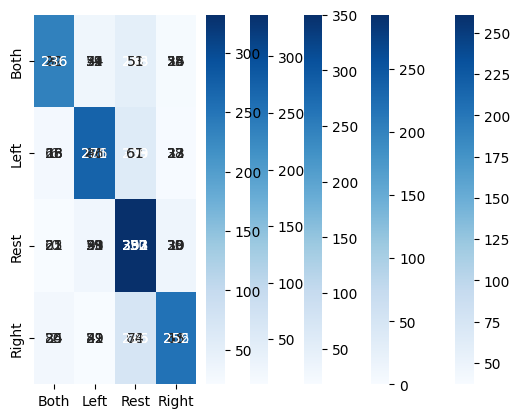

In [ ]:
#sklearn models
# for pipe in pipes_scaler:
#   fit_and_print(pipe)

for pipe in pipes_mm:
  fit_and_print(pipe)

fit_and_print(ann, X_train = X_train_scaler, X_test = X_test_scaler, y_train = dummy_y_train, y_test = dummy_y_test)
fit_and_print(ann, X_train = X_train_mm, X_test = X_test_mm, y_train = dummy_y_train, y_test = dummy_y_test)


##PCA Plot

In [ ]:
# Set PCA construct
pca = PCA(n_components=2)

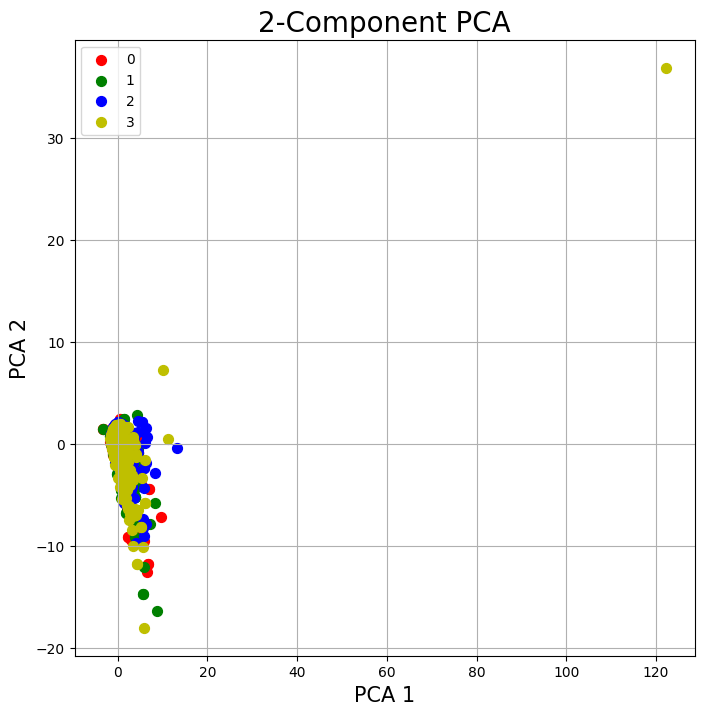

In [ ]:
# TRAINING data
principalComponents_train = pca.fit_transform(X_train_scaler)
principalDf_train = pd.DataFrame(data = principalComponents_train, columns = ['principal component 1', 'principal component 2'])
finalDf_train = pd.concat([principalDf_train, y_train], axis = 1)


fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('PCA 1', fontsize = 15)
ax.set_ylabel('PCA 2', fontsize = 15)
ax.set_title('2-Component PCA', fontsize = 20)

targets = [0, 1, 2, 3]
colors = ['r', 'g', 'b', 'y']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf_train[0] == target
    ax.scatter(finalDf_train.loc[indicesToKeep, 'principal component 1']
               , finalDf_train.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

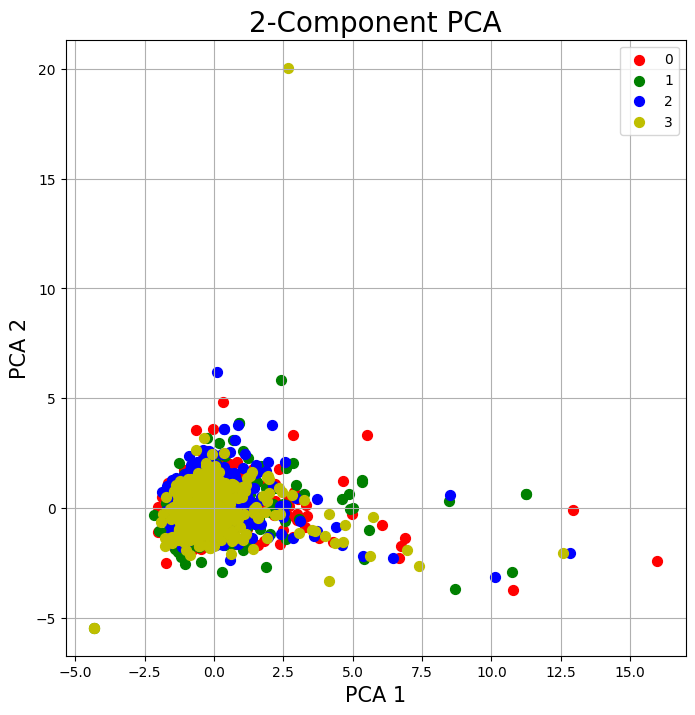

In [ ]:
# TESTING data
principalComponents_test = pca.fit_transform(X_test_scaler)
principalDf_test = pd.DataFrame(data = principalComponents_test, columns = ['principal component 1', 'principal component 2'])
finalDf_test= pd.concat([principalDf_test, y_test], axis = 1)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('PCA 1', fontsize = 15)
ax.set_ylabel('PCA 2', fontsize = 15)
ax.set_title('2-Component PCA', fontsize = 20)

targets = [0, 1, 2, 3]
colors = ['r', 'g', 'b', 'y']
for target, color in zip(targets,colors):
    indicesToKeep = finalDf_test[0] == target
    ax.scatter(finalDf_test.loc[indicesToKeep, 'principal component 1']
               , finalDf_test.loc[indicesToKeep, 'principal component 2']
               , c = color
               , s = 50)
ax.legend(targets)
ax.grid()

##Unsupervized Clustering of PCA_1 + PCA_2

Set Up A Classifier

In [ ]:
# Create model to test PCA
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(random_state = 0)
classifier.fit(principalComponents_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(random_state=0)

Unsupervised: Train Data

Shape of X_set: (6100, 2)


<ipython-input-72-eda8aefd86b6>:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_set[y_set.flatten() == j, 0], X_set[y_set.flatten() == j, 1],


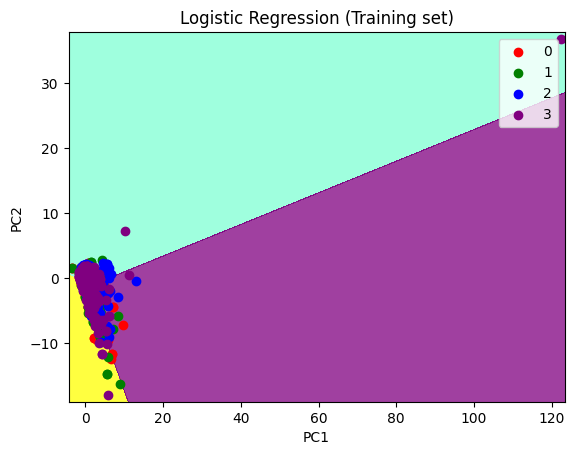

In [ ]:
from matplotlib.colors import ListedColormap

X_set, y_set = principalComponents_train[:, :2], y_train
y_set = y_set.values

X1, X2 = np.meshgrid(
    np.arange(start=X_set[:, 0].min() - 1, stop=X_set[:, 0].max() + 1, step=0.01),
    np.arange(start=X_set[:, 1].min() - 1, stop=X_set[:, 1].max() + 1, step=0.01)
)

plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape), alpha=0.75,
             cmap=ListedColormap(('yellow', 'white', 'aquamarine', 'purple')))

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

print("Shape of X_set:", X_set.shape)

for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set.flatten() == j, 0], X_set[y_set.flatten() == j, 1],
                c=ListedColormap(('red', 'green', 'blue', 'purple'))(i), label=j)

plt.title('Logistic Regression (Training set)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()


Unsupervised: Test Data

Shape of X_set: (1526, 2)


<ipython-input-74-d1e329a5cc90>:20: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_set[y_set.flatten() == j, 0], X_set[y_set.flatten() == j, 1],


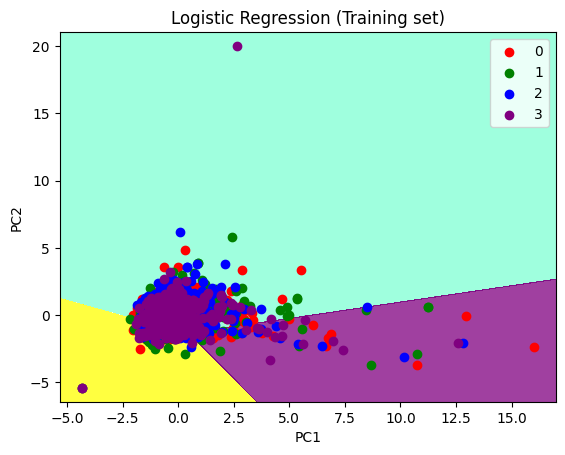

In [ ]:
from matplotlib.colors import ListedColormap

X_set, y_set = principalComponents_test[:, :2], y_test
y_set = y_set.values

X1, X2 = np.meshgrid(
    np.arange(start=X_set[:, 0].min() - 1, stop=X_set[:, 0].max() + 1, step=0.01),
    np.arange(start=X_set[:, 1].min() - 1, stop=X_set[:, 1].max() + 1, step=0.01)
)

plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape), alpha=0.75,
             cmap=ListedColormap(('yellow', 'white', 'aquamarine', 'purple')))

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

print("Shape of X_set:", X_set.shape)

for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set.flatten() == j, 0], X_set[y_set.flatten() == j, 1],
                c=ListedColormap(('red', 'green', 'blue', 'purple'))(i), label=j)

plt.title('Logistic Regression (Training set)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()


###K-Means Clustering

Set K-Means

In [ ]:
from sklearn.cluster import KMeans

# Set labels as word categories
label_names = {0: "Both", 1: "Left", 2: "Rest", 3: "Right"}
cmap = plt.cm.get_cmap('viridis', 4)  # Choose a colormap with 4 colors
cluster_labels = ['Both', 'Left', 'Rest', 'Right']

# Plot the training data points with cluster labels

# Create an instance of the KMeans class
kmeans = KMeans(n_clusters=4, random_state=42)  # Specify the number of clusters

# Fit the KMeans model to the PCA-transformed training data
kmeans.fit(principalComponents_train)

# Get the cluster labels for each data point in the PCA-transformed training data
cluster_labels_train = kmeans.labels_

# Perform clustering on the PCA-transformed test data
principalComponents_test = pca.transform(X_test_scaler)  # Transform test data using the same PCA object
cluster_labels_test = kmeans.predict(principalComponents_test)

# Print the cluster labels for the training data
print("Cluster labels for the training data:")
print(cluster_labels_train)

# Print the cluster labels for the test data
print("Cluster labels for the test data:")
print(cluster_labels_test)


<ipython-input-75-7334eba1d4ae>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', 4)  # Choose a colormap with 4 colors
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster labels for the training data:
[2 2 2 ... 2 0 2]
Cluster labels for the test data:
[2 2 2 ... 0 2 2]


Plot Training Clusters

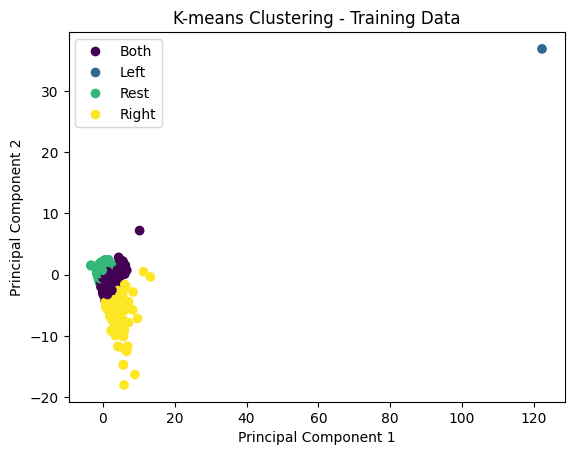

In [ ]:
plt.scatter(principalDf_train['principal component 1'], principalDf_train['principal component 2'], c=cluster_labels_train, cmap=cmap)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering - Training Data')
#plt.colorbar(label='Cluster Labels')
# Create legend handles and labels
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=8) for label, color in zip(cluster_labels, cmap(np.arange(4)))]
plt.legend(handles=legend_handles)
plt.show()

Plot Testing Clusters

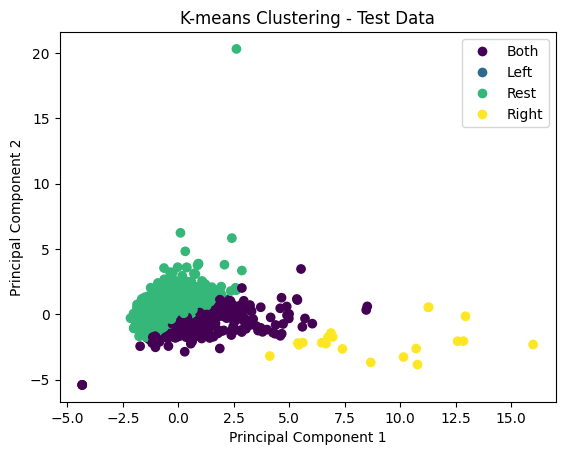

In [ ]:
plt.scatter(principalComponents_test[:, 0], principalComponents_test[:, 1], c=cluster_labels_test, cmap=cmap)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering - Test Data')
#plt.colorbar(label='Cluster Labels')
# Create legend handles and labels
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=8) for label, color in zip(cluster_labels, cmap(np.arange(4)))]
plt.legend(handles=legend_handles)
plt.show()

##LDA Plot

In [ ]:
#FOR LDA 3 ONLY

# Remove "Both"
power_data_3_lda = power_data_mod[power_data_mod['task'] != 'Both']

# Set features & classifiers (unique lda names)
feat_lda = power_data_3_lda.drop(columns=('task'))
class_lda = power_data_3_lda['task']

# Standard Scaler to lda features
feat_lda_ss = StandardScaler().fit_transform(feat_lda)

# establish X_lda & y_lda
X_lda = feat_lda_ss
y_lda = class_lda

#encode to numeric categories
encoder_lda = LabelEncoder()
encoder_lda.fit(y_lda)

#this gives the 0-2 integer outputs
encoded_lda_y = encoder_lda.transform(y_lda)

# dividing X, y into train and test data
X_lda_train, X_lda_test, y_lda_train, y_lda_test = train_test_split(X_lda, encoded_lda_y, train_size = 0.8, random_state = 0)

#reformat
y_lda_train = pd.DataFrame(y_lda_train)
y_lda_test = pd.DataFrame(y_lda_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


<Axes: xlabel='LDA1', ylabel='LDA2'>

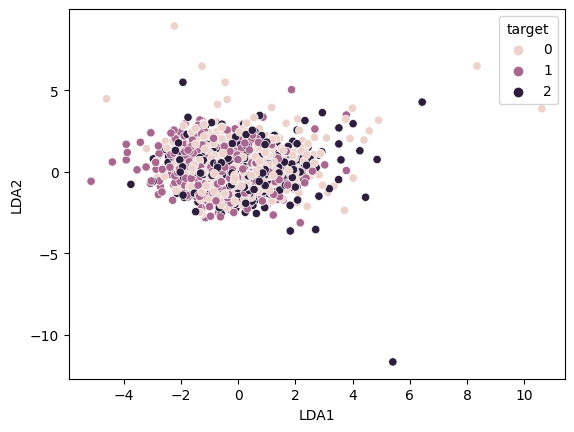

In [ ]:
# Set LDA construct
lda = LinearDiscriminantAnalysis()

# TRAINING data
lda.fit(X_lda_train, y_lda_train)
y_lda_pred_train = lda.predict(X_lda_train)
y_lda_pred_test = lda.predict(X_lda_test)

X_train_lda_df = lda.transform(X_lda_train)

lda_train_plot = pd.DataFrame({'LDA1': X_train_lda_df[:, 0], 'LDA2': X_train_lda_df[:, 1], 'target': y_lda_train.values.ravel()})

sns.scatterplot(x="LDA1", y="LDA2", hue="target", data=lda_train_plot)





<Axes: xlabel='LDA1', ylabel='LDA2'>

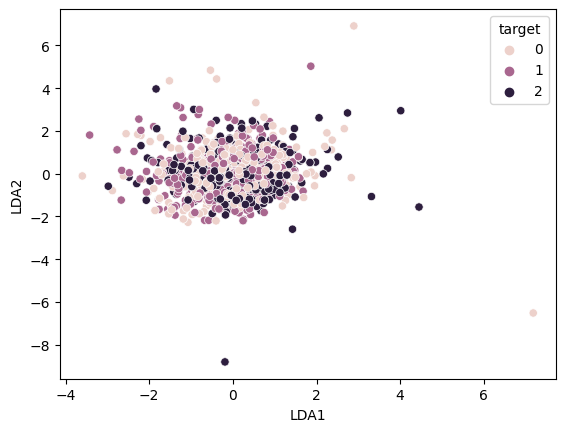

In [ ]:
# TESTING data
X_test_lda_df = lda.transform(X_lda_test)

lda_test_plot = pd.DataFrame({'LDA1': X_test_lda_df[:, 0], 'LDA2': X_test_lda_df[:, 1], 'target': y_lda_test.values.ravel()})

sns.scatterplot(x="LDA1", y="LDA2", hue="target", data=lda_test_plot)


##Unsupervized Clustering of LDA_1 + LDA_2

Set Up A Classifier

In [ ]:
# Create model to test PCA
from sklearn.linear_model import LogisticRegression
lda_train_plot_x = lda_train_plot.drop(columns=('target'))

classifier = LogisticRegression(random_state = 0)
classifier.fit(lda_train_plot_x, y_lda_train)
#lda_train_plot

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(random_state=0)

Unsupervised: Train Data

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Shape of X_set: (4658, 2)


<ipython-input-82-f67255379ffe>:21: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_set[y_set.flatten() == j, 0], X_set[y_set.flatten() == j, 1],


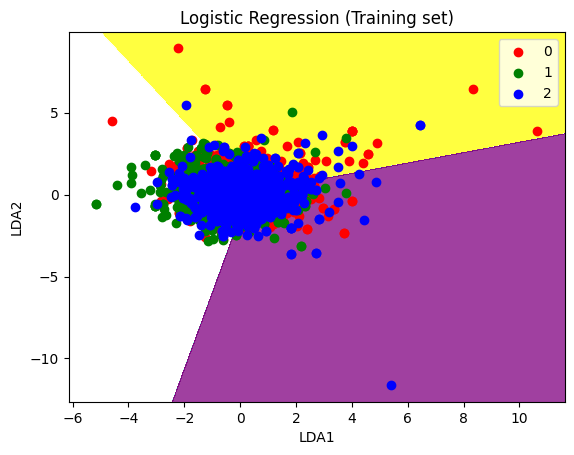

In [ ]:
from matplotlib.colors import ListedColormap

X_set, y_set = lda_train_plot_x , y_lda_train
X_set = X_set.values
y_set = y_set.values

X1, X2 = np.meshgrid(
    np.arange(start=X_set[:, 0].min() - 1, stop=X_set[:, 0].max() + 1, step=0.01),
    np.arange(start=X_set[:, 1].min() - 1, stop=X_set[:, 1].max() + 1, step=0.01)
)

plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape), alpha=0.75,
             cmap=ListedColormap(('yellow', 'white', 'aquamarine', 'purple')))

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

print("Shape of X_set:", X_set.shape)

for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set.flatten() == j, 0], X_set[y_set.flatten() == j, 1],
                c=ListedColormap(('red', 'green', 'blue', 'purple'))(i), label=j)

plt.title('Logistic Regression (Training set)')
plt.xlabel('LDA1')
plt.ylabel('LDA2')
plt.legend()
plt.show()


Unsupervised: Test Data

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


Shape of X_set: (1165, 2)


<ipython-input-83-577822727bc1>:23: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(X_set[y_set.flatten() == j, 0], X_set[y_set.flatten() == j, 1],


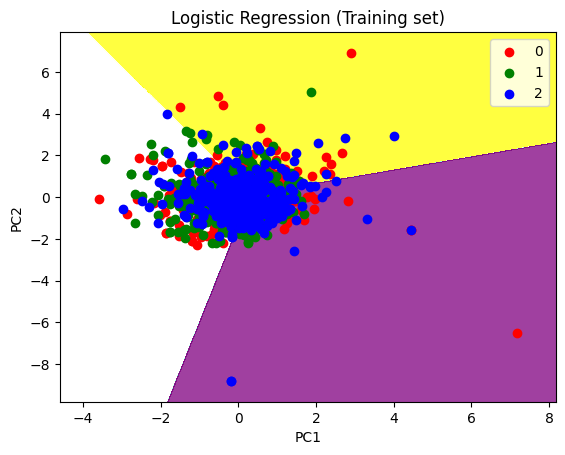

In [ ]:
from matplotlib.colors import ListedColormap
lda_test_plot_x = lda_test_plot.drop(columns=('target'))


X_set, y_set =  lda_test_plot_x , y_lda_test
X_set = X_set.values
y_set = y_set.values

X1, X2 = np.meshgrid(
    np.arange(start=X_set[:, 0].min() - 1, stop=X_set[:, 0].max() + 1, step=0.01),
    np.arange(start=X_set[:, 1].min() - 1, stop=X_set[:, 1].max() + 1, step=0.01)
)

plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape), alpha=0.75,
             cmap=ListedColormap(('yellow', 'white', 'aquamarine', 'purple')))

plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())

print("Shape of X_set:", X_set.shape)

for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set.flatten() == j, 0], X_set[y_set.flatten() == j, 1],
                c=ListedColormap(('red', 'green', 'blue', 'purple'))(i), label=j)

plt.title('Logistic Regression (Training set)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()


###K-Means Clustering

Set K-Means

In [ ]:
from sklearn.cluster import KMeans

# Set labels as word categories
label_names = {0: "Both", 1: "Left", 2: "Rest", 3: "Right"}
cmap = plt.cm.get_cmap('viridis', 3)  # Choose a colormap with 3 colors while "both" is removed
cluster_labels = ['Left', 'Rest', 'Right'] #'Both'

# Plot the training data points with cluster labels

# Create an instance of the KMeans class
kmeans = KMeans(n_clusters=4, random_state=42)  # Specify the number of clusters

# Fit the KMeans model to the LDA-transformed training data
kmeans.fit(lda_train_plot_x)

# Get the cluster labels for each data point in the LDA-transformed training data
cluster_labels_train = kmeans.labels_

# Perform clustering on the LDA-transformed test data
cluster_labels_test = kmeans.predict(lda_test_plot_x)

# Print the cluster labels for the training data
print("Cluster labels for the training data:")
print(cluster_labels_train)

# Print the cluster labels for the test data
print("Cluster labels for the test data:")
print(cluster_labels_test)


<ipython-input-84-d208ad17141d>:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('viridis', 3)  # Choose a colormap with 3 colors while "both" is removed
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Cluster labels for the training data:
[2 3 3 ... 1 1 1]
Cluster labels for the test data:
[2 1 2 ... 3 3 3]


Plot Training Clusters

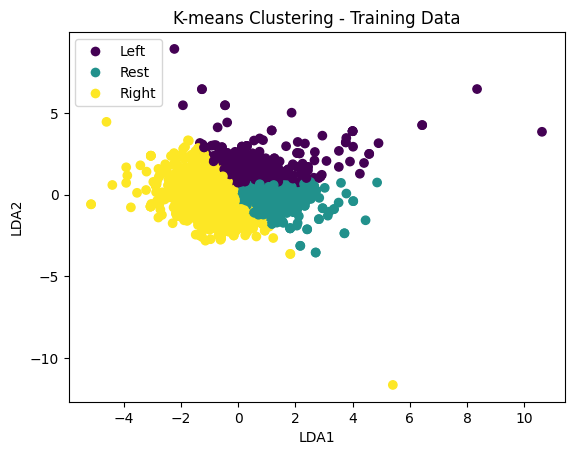

In [ ]:
plt.scatter(lda_train_plot_x['LDA1'], lda_train_plot_x['LDA2'], c=cluster_labels_train, cmap=cmap)
plt.xlabel('LDA1')
plt.ylabel('LDA2')
plt.title('K-means Clustering - Training Data')
#plt.colorbar(label='Cluster Labels')
# Create legend handles and labels
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=8) for label, color in zip(cluster_labels, cmap(np.arange(4)))]
plt.legend(handles=legend_handles)
plt.show()

Plot Testing Clusters

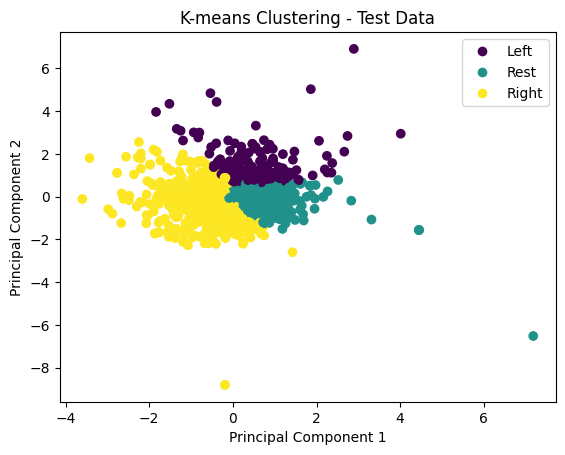

In [ ]:
plt.scatter(lda_test_plot_x['LDA1'], lda_test_plot_x['LDA2'], c=cluster_labels_test, cmap=cmap)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('K-means Clustering - Test Data')
#plt.colorbar(label='Cluster Labels')
# Create legend handles and labels
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label, markerfacecolor=color, markersize=8) for label, color in zip(cluster_labels, cmap(np.arange(4)))]
plt.legend(handles=legend_handles)
plt.show()

##Machine-Learning Models

###LazyPredict **does not work*

In [ ]:
#!pip install lazypredict
#!pip install --upgrade lazypredict
#!conda install -c conda-forge xgboost
#!conda install -c conda-forge lightgbm
import lazypredict
from lazypredict.Supervised import LazyClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from scipy import sparse

X_train2, X_test2, y_train2, y_test2 = train_test_split(X, classifier, train_size = 0.8, random_state = 0)

# Create and fit the LazyClassifier
clf = LazyClassifier(verbose=0, ignore_warnings=True, custom_metric=None)
models, predictions = clf.fit(X_train_scaler, X_test, y_train, y_test)

# Print the model performance
models

###Random Forest

In [ ]:
# quick Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(max_depth=50, max_features='auto', min_samples_leaf=2, n_estimators=2000, random_state=42)
rf_model.fit(X_train, y_train)



# model accuracy for X_test
accuracy = rf_model.score(X_test, y_test)
rf_predictions = rf_model.predict(X_test)
rf_predictions_proba = rf_model.predict_proba(X_test)

print(accuracy)

<ipython-input-87-ac5f17726bee>:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf_model.fit(X_train, y_train)
/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_forest.py:424: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features='sqrt'` or remove this parameter as it is also the default value for RandomForestClassifiers and ExtraTreesClassifiers.
  warn(


0.7411533420707732


Text(0, 0.5, 'Mean decrease in impurity')

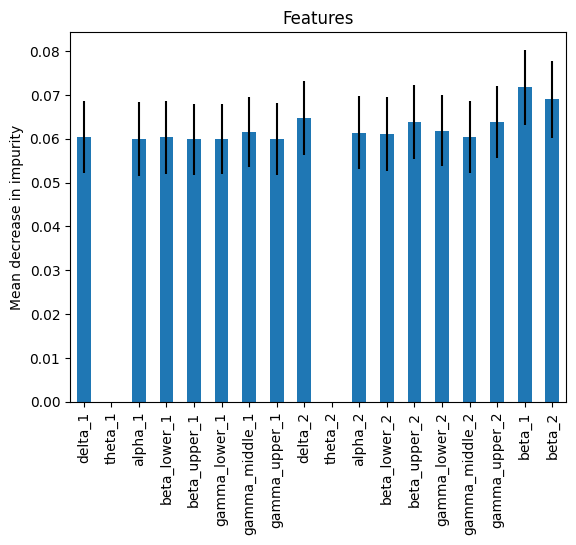

In [ ]:
#Feature Importance
importances = rf_model.feature_importances_
forest_importances = pd.Series(importances, index=features.columns)
std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

fig1, ax1 = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax1)
ax1.set_title("Features")
ax1.set_ylabel("Mean decrease in impurity")

Confusion Matrix

[Text(0, 0.5, 'Both'),
 Text(0, 1.5, 'Left'),
 Text(0, 2.5, 'Rest'),
 Text(0, 3.5, 'Right')]

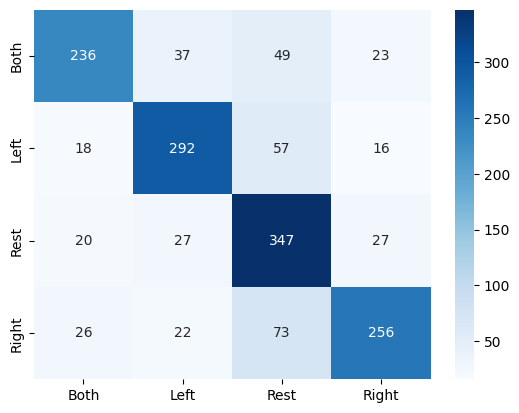

In [ ]:
# creating a confusion matrix
cm_rf = confusion_matrix(y_test, rf_predictions)
accuracy

#confusion matrix
categories = ['Both','Left','Rest','Right']
ax = sns.heatmap(cm_rf, annot=True,fmt='d',cmap='Blues')
ax.set_xticklabels(categories)
ax.set_yticklabels(categories)


###Gradient Boost

In [ ]:
# training a RF classifier

gb_model = GradientBoostingClassifier(max_depth=15, max_features='sqrt',
                           min_samples_leaf=2, n_estimators=1500, random_state=42)
gb_model.fit(X_train, y_train)


# model accuracy for X_test
accuracy = gb_model.score(X_test, y_test)
gb_predictions = gb_model.predict(X_test)

print(accuracy)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_gb.py:437: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.7201834862385321


[Text(0, 0.5, 'Both'),
 Text(0, 1.5, 'Left'),
 Text(0, 2.5, 'Rest'),
 Text(0, 3.5, 'Right')]

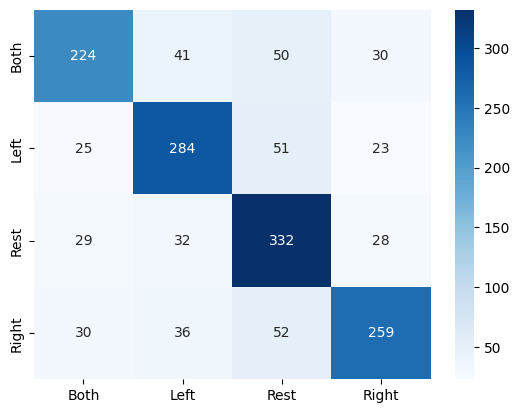

In [ ]:
cm_rf = confusion_matrix(y_test, gb_predictions)
accuracy

#confusion matrix
categories = ['Both','Left','Rest','Right']
ax = sns.heatmap(cm_rf, annot=True,fmt='d',cmap='Blues')
ax.set_xticklabels(categories)
ax.set_yticklabels(categories)

In [ ]:
precision_gb  = metrics.precision_recall_fscore_support(y_test,gb_predictions)[0][1]
specificity_gb = metrics.precision_recall_fscore_support(y_test,gb_predictions)[1][0]
sensitivity_gb = metrics.precision_recall_fscore_support(y_test,gb_predictions)[1][1]
accuracy_gb = accuracy_score(y_test, gb_predictions)
metrics_gb = pd.DataFrame([accuracy_gb,precision_gb,specificity_gb,sensitivity_gb])
metrics_gb

0
0  0.720183
1  0.722646
2  0.649275
3  0.741514

###Decision Trees

In [ ]:
# Create Decision Trees Model
dtree_model = DecisionTreeClassifier(criterion='entropy', max_depth=5, max_features=5, min_samples_leaf=8)
dtree_model.fit(X_train, y_train)
dtree_predictions = dtree_model.predict(X_test)

# creating a confusion matrix
cm_dtree = confusion_matrix(y_test, dtree_predictions)

print(accuracy_score(y_test, dtree_predictions))

In [ ]:
precision_dtree  = metrics.precision_recall_fscore_support(y_test,dtree_predictions)[0][1]
specificity_dtree = metrics.precision_recall_fscore_support(y_test,dtree_predictions)[1][0]
sensitivity_dtree = metrics.precision_recall_fscore_support(y_test,dtree_predictions)[1][1]
accuracy_dtree = accuracy_score(y_test, dtree_predictions)
metrics_dtree = pd.DataFrame([accuracy_dtree,precision_dtree,specificity_dtree,sensitivity_dtree])
metrics_dtree

In [ ]:
categories = ['Both','Left','Rest','Right']
ax = sns.heatmap(cm_dtree, annot=True,fmt='d',cmap='Blues')
ax.set_xticklabels(categories)
ax.set_yticklabels(categories)

###Logistical Regression

In [ ]:
# Create Logistical Regression structure
log_regression = LogisticRegression(C=3792.690190732246, multi_class='multinomial')
log_regression.fit(X_train,y_train)
log_predictions = log_regression.predict(X_test)

# creating a confusion matrix
cm_log = confusion_matrix(y_test, log_predictions)

print(accuracy_score(y_test, log_predictions))

In [ ]:
precision_log  = metrics.precision_recall_fscore_support(y_test,log_predictions)[0][1]
specificity_log = metrics.precision_recall_fscore_support(y_test,log_predictions)[1][0]
sensitivity_log = metrics.precision_recall_fscore_support(y_test,log_predictions)[1][1]
accuracy_log = accuracy_score(y_test, log_predictions)
metrics_log = pd.DataFrame([accuracy_log,precision_log,specificity_log,sensitivity_log])
metrics_log

In [ ]:
categories = ['Both','Left','Rest','Right']
ax = sns.heatmap(cm_log, annot=True,fmt='d',cmap='Blues')
ax.set_xticklabels(categories)
ax.set_yticklabels(categories)

###Gaussian Naive Bayes

In [ ]:
# Gaussian Naive Bayes model
gnb = GaussianNB(var_smoothing=1e-07)
gnb_predictions = gnb.fit(X_train, y_train).predict(X_test)



# accuracy on X_test
accuracy = gnb.score(X_test, y_test)
print(accuracy)

In [ ]:
precision_gnb  = metrics.precision_recall_fscore_support(y_test,gnb_predictions)[0][1]
specificity_gnb = metrics.precision_recall_fscore_support(y_test,gnb_predictions)[1][0]
sensitivity_gnb = metrics.precision_recall_fscore_support(y_test,gnb_predictions)[1][1]
accuracy_gnb = accuracy_score(y_test, log_predictions)
metrics_gnb = pd.DataFrame([accuracy_gnb,precision_gnb,specificity_gnb,sensitivity_gnb])
metrics_gnb

In [ ]:
# creating a confusion matrix
cm_gnb = confusion_matrix(y_test, gnb_predictions)
accuracy

#confusion matrix
categories = ['Both','Left','Rest','Right']
ax = sns.heatmap(cm_gnb, annot=True,fmt='d',cmap='Blues')
ax.set_xticklabels(categories)
ax.set_yticklabels(categories)

###K-Nearest Neighbors (KNN)

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 55,weights='distance').fit(X_train, y_train)

# accuracy on X_test
accuracy = knn.score(X_test, y_test)
print(accuracy)

# creating a confusion matrix
knn_predictions = knn.predict(X_test)

In [ ]:
precision_knn  = metrics.precision_recall_fscore_support(y_test,knn_predictions)[0][1]
specificity_knn = metrics.precision_recall_fscore_support(y_test,knn_predictions)[1][0]
sensitivity_knn = metrics.precision_recall_fscore_support(y_test,knn_predictions)[1][1]
accuracy_knn = accuracy_score(y_test, log_predictions)
metrics_knn = pd.DataFrame([accuracy_knn,precision_knn,specificity_knn,sensitivity_knn])
metrics_knn

In [ ]:
# creating a confusion matrix
cm_knn = confusion_matrix(y_test, knn_predictions)
accuracy

#confusion matrix
categories = ['Both','Left','Rest','Right']
ax = sns.heatmap(cm_gnb, annot=True,fmt='d',cmap='Blues')
ax.set_xticklabels(categories)
ax.set_yticklabels(categories)

###Support Vector Machines

In [ ]:
svm = SVC() #LinearSVC() can be used also
svm.fit(X_train, y_train)

# model accuracy for X_test
accuracy = svm.score(X_test, y_test)
svm_predictions = svm.predict(X_test)
#svm_predictions_proba = svm.predict_proba(X_test)

print(accuracy)

In [ ]:
precision_svm  = metrics.precision_recall_fscore_support(y_test,svm_predictions)[0][1]
specificity_svm = metrics.precision_recall_fscore_support(y_test,svm_predictions)[1][0]
sensitivity_svm = metrics.precision_recall_fscore_support(y_test,svm_predictions)[1][1]
accuracy_svm = accuracy_score(y_test, svm_predictions)
metrics_svm = pd.DataFrame([accuracy_svm,precision_svm,specificity_svm,sensitivity_svm])
metrics_svm

In [ ]:
# creating a confusion matrix
cm_svm = confusion_matrix(y_test, svm_predictions)
accuracy

#confusion matrix
categories = ['Both','Left','Rest','Right']
ax = sns.heatmap(cm_svm, annot=True,fmt='d',cmap='Blues')
ax.set_xticklabels(categories)
ax.set_yticklabels(categories)

###ANN

In [ ]:
model = tf.keras.Sequential([
      tf.keras.layers.Dense(10, input_shape=(18,), activation='relu'),
      tf.keras.layers.Dense(8, activation='relu'),
      tf.keras.layers.Dense(6, activation='relu'),
      tf.keras.layers.Dense(4, activation='softmax')
  ])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train_scaler, dummy_y_train, epochs=25, batch_size=25)


# make class predictions with the model
probability_model = tf.keras.Sequential([model, tf.keras.layers.Softmax()])
predictions = probability_model.predict(X_test_scaler)

#convert one-hot code arrays to classifiers (0/1/2/3)
model_label = tf.argmax(dummy_y_test, axis = 1)
model_label = pd.DataFrame(model_label)

predictions_label = tf.argmax(predictions, axis=1)
predictions_label = pd.DataFrame(predictions_label)

#confusion matrix
cm_ann = confusion_matrix(model_label, predictions_label)
print(cm_ann)

#confusion matrix
categories = ['NAWM','NPF','Tumor','PF',]
ax = sns.heatmap(cm_ann, annot=True,fmt='d',cmap='Blues')
ax.set_xticklabels(categories)
ax.set_yticklabels(categories)

###others...